In [3]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import numpy as np
from hilbert import decode, encode
import pandas as pd
from tqdm import tqdm
import torch
from comet_ml import Experiment

import torch
import torch.nn as nn
import torch.nn.functional as F

import os
os.environ["COMET_API_KEY"] = "uM0HPEvEu6OyX3dTEuB4Fihgz"
hyper_params = {"batch_size": 64, "num_epochs": 5, "learning_rate": 0.0015,"trainset":"_4layer_w_volume","loss_metric":"MSE","regularizer":"L1"}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
class HilbertImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.img_labels = pd.read_parquet(os.path.join(self.img_dir, annotations_file))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path1 = os.path.join(self.img_dir, self.img_labels.iloc[idx, -1])
        img_path2 = os.path.join(self.img_dir, "s_"+self.img_labels.iloc[idx, -1])
        img_path3 = os.path.join(self.img_dir, "s8_"+self.img_labels.iloc[idx, -1])
        
        image1 = np.load(img_path1)
        image2 = np.load(img_path2)
        image3 = np.load(img_path3)
        
        
        label = self.img_labels.iloc[idx, :-1].values.astype("float64")
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
            image2 = self.transform(image3)
            
            
        if self.target_transform:
            label = self.target_transform(label)
        return image1,image2,image3, label
train_ds = HilbertImageDataset(annotations_file="target_next_20.parquet",img_dir="imgs/train"+hyper_params["trainset"]+"/")
test_ds = HilbertImageDataset(annotations_file="target_next_20.parquet",img_dir="imgs/test"+hyper_params["trainset"]+"/")
trainloader = DataLoader(train_ds, batch_size=hyper_params["batch_size"], shuffle=True)
testloader = DataLoader(test_ds, batch_size=hyper_params["batch_size"], shuffle=True)

cuda:0


In [4]:
class Net_w_16(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1a = nn.Conv2d(5, 8, 5,dilation=4,padding="same")
        torch.nn.init.xavier_uniform_(self.conv1a.weight)
        
        self.conv2a = nn.Conv2d(8, 16, 5,dilation=3,padding="same")
        torch.nn.init.xavier_uniform_(self.conv2a.weight)
        self.conv3a = nn.Conv2d(16, 24, 3,dilation=2)
        self.conv4a = nn.Conv2d(24, 48, 2)
        self.conv5a = nn.Conv2d(48, 64, 2)
        
        self.conv1b = nn.Conv2d(5, 8, 4,dilation=3,padding="same")
        torch.nn.init.xavier_uniform_(self.conv1b.weight)
        
        self.conv2b = nn.Conv2d(8, 16, 3,dilation=2,padding="same")
        torch.nn.init.xavier_uniform_(self.conv2b.weight)
        self.conv3b = nn.Conv2d(16, 24, 2,dilation=1)
        
        
        
        
        self.conv1 = nn.Conv2d(5, 8, 5,dilation=4,padding="same")
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.pool = nn.MaxPool2d(3, 2)
        self.pool2 = nn.AvgPool2d(3, 2)
        
        self.conv2 = nn.Conv2d(8, 16, 5,dilation=3,padding="same")
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        
        self.conv3 = nn.Conv2d(16, 24, 3,dilation=2)
        self.conv4 = nn.Conv2d(24, 48, 2)
        self.conv5 = nn.Conv2d(48, 64, 2)
        self.conv6 = nn.Conv2d(64, 128, 1)
        
        self.fc1a = nn.Linear(600, 512)
        self.fc2a = nn.Linear(512, 128)
        
        self.fc1b = nn.Linear(600, 512)
        self.fc2b = nn.Linear(512, 128)
        
        self.fc1c = nn.Linear(216, 128)
        
        
        self.fc1 = nn.Linear(1152, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 16)
        
        self.fc8 = nn.Linear(16, 8)
        
        self.batch1=nn.BatchNorm2d(8)
        self.batch2=nn.BatchNorm2d(16)
        self.batch3=nn.BatchNorm2d(24)
        self.batch4=nn.BatchNorm2d(64)
        
        self.dropout1=nn.Dropout2d(p=0.2)
        

    def forward(self, xl):
        x1=xl[0]
        x2=xl[1]
        x3=xl[2]
        
        x2 = self.dropout1(self.batch1(F.relu(self.conv1a(x2))))
        x2 = self.batch2(F.relu(self.conv2a(x2)))
        x2 = self.pool2(self.batch3(F.relu(self.conv3a(x2))))

        x3 = self.dropout1(self.batch1(F.relu(self.conv1b(x3))))
        x3 = self.batch2(F.relu(self.conv2b(x3)))
        x3 = self.pool2(self.batch3(F.relu(self.conv3b(x3))))
        
        
        
        x1 = self.dropout1(self.batch1(F.relu(self.conv1(x1))))
        x1 = self.pool(self.batch2(F.relu(self.conv2(x1))))
        x1 = self.pool2(self.batch3(F.relu(self.conv3(x1))))
        x1 = F.relu(self.conv4(x1))
        x1 = F.relu(self.conv5(x1))
        x1 = F.relu(self.conv6(x1))
        
        x1 = torch.flatten(x1, 1) # flatten all dimensions except batch
        x2 = torch.flatten(x2, 1) # flatten all dimensions except batch
        x3 = torch.flatten(x3, 1) # flatten all dimensions except batch
        #
        x1 = F.relu(self.fc1(x1))
        x1 = F.relu(self.fc2(x1))
        #x1 = F.relu(self.fc3(x1))
        
        x2 = F.relu(self.fc1a(x2))
        x2 = F.relu(self.fc2a(x2))
        
        x3 = F.relu(self.fc1c(x3))
        #print(x1.shape,x2.shape,x3.shape)
        x=torch.cat([x1,x2,x3],1)
        
        #print(x1.shape,x2.shape,x3.shape)
        
        
        x = F.leaky_relu(self.fc4(x))
        x = F.leaky_relu(self.fc5(x))
        
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        x = self.fc8(x)
        
        return x
net=Net_w_16()


In [5]:
df = pd.read_parquet("data/F_BTCUSDT_1m.parquet")
tc = ["Open",
"High",
"Low",
"Close",
"Volume"]
for i in tc:
    df[i]=df[i].astype("float")

In [60]:
pd.to_datetime("2020-11-30")

Timestamp('2020-11-30 00:00:00')

In [32]:
df.iloc[1424681:]

,OpenTime,Open,High,Low,Close,Volume,CloseTime,QuoteAsset,NumberOfTrades,TakerBuybaseassetvolume,TakerBuyquoteassetvolume,Ignore
1424681,2022-06-16 08:41:00,22075.9,22095.0,22066.6,22092.8,173.130,1655358119999,3821618.90830,2206,94.048,2076019.74690,0
1424682,2022-06-16 08:42:00,22092.8,22100.1,22073.3,22089.8,150.985,1655358179999,3334987.00850,1655,69.647,1538393.39780,0
1424683,2022-06-16 08:43:00,22089.8,22102.6,22056.5,22065.2,288.537,1655358239999,6369822.68290,2630,129.628,2861840.87250,0
1424684,2022-06-16 08:44:00,22065.1,22078.6,22047.2,22077.8,233.185,1655358299999,5143806.97550,2720,118.397,2611893.83000,0
1424685,2022-06-16 08:45:00,22077.9,22081.1,22065.5,22077.3,140.532,1655358359999,3102302.21130,1907,76.191,1681934.22350,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1583995,2022-10-04 23:55:00,20357.5,20375.0,20355.2,20355.3,954.064,1664916959999,19430279.00560,5093,509.076,10367821.83960,0
1583996,2022-10-04 23:56:00,20355.2,20370.7,20353.3,20353.3,371.426,1664917019999,7562153.35400,3115,163.501,3328771.53970,0
1583997,2022-10-04 23:57:00,20353.4,20355.3,20323.5,20330.0,1098.885,1664917079999,22345525.97800,6736,442.725,9001848.01150,0
1583998,2022-10-04 23:58:00,20329.9,20360.4,20329.9,20344.0,595.273,1664917139999,12111296.57470,3793,384.144,7815856.88280,0


In [61]:
df[df.OpenTime>pd.to_datetime("2020-11-30")]

,OpenTime,Open,High,Low,Close,Volume,CloseTime,QuoteAsset,NumberOfTrades,TakerBuybaseassetvolume,TakerBuyquoteassetvolume,Ignore
613441,2020-11-30 00:01:00,18212.65,18250.00,18209.45,18248.83,738.662,1606683719999,13468651.60655,2666,593.351,10819572.86343,0
613442,2020-11-30 00:02:00,18249.08,18285.71,18244.12,18269.33,1729.722,1606683779999,31596659.13938,5303,1176.008,21481227.60954,0
613443,2020-11-30 00:03:00,18269.33,18287.52,18263.85,18276.01,654.442,1606683839999,11962138.68654,1905,396.144,7240977.87569,0
613444,2020-11-30 00:04:00,18276.00,18286.00,18267.61,18284.08,327.197,1606683899999,5979859.77600,1132,186.771,3413625.34848,0
613445,2020-11-30 00:05:00,18284.92,18323.90,18280.00,18320.16,1277.371,1606683959999,23377595.46590,3969,1002.403,18346092.97826,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1583995,2022-10-04 23:55:00,20357.50,20375.00,20355.20,20355.30,954.064,1664916959999,19430279.00560,5093,509.076,10367821.83960,0
1583996,2022-10-04 23:56:00,20355.20,20370.70,20353.30,20353.30,371.426,1664917019999,7562153.35400,3115,163.501,3328771.53970,0
1583997,2022-10-04 23:57:00,20353.40,20355.30,20323.50,20330.00,1098.885,1664917079999,22345525.97800,6736,442.725,9001848.01150,0
1583998,2022-10-04 23:58:00,20329.90,20360.40,20329.90,20344.00,595.273,1664917139999,12111296.57470,3793,384.144,7815856.88280,0


In [6]:


from comet_ml.integration.pytorch import load_model
model=Net_w_16()

# Load the model state dict from a Comet Experiment
checkpoint = load_model("experiment://80af5f3cad3747c09c815d1cdd19e130/4_layer_w_volume_w_16_8",)
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
model.to(device)



Net_w_16(
  (conv1a): Conv2d(5, 8, kernel_size=(5, 5), stride=(1, 1), padding=same, dilation=(4, 4))
  (conv2a): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=same, dilation=(3, 3))
  (conv3a): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), dilation=(2, 2))
  (conv4a): Conv2d(24, 48, kernel_size=(2, 2), stride=(1, 1))
  (conv5a): Conv2d(48, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv1b): Conv2d(5, 8, kernel_size=(4, 4), stride=(1, 1), padding=same, dilation=(3, 3))
  (conv2b): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(2, 2))
  (conv3b): Conv2d(16, 24, kernel_size=(2, 2), stride=(1, 1))
  (conv1): Conv2d(5, 8, kernel_size=(5, 5), stride=(1, 1), padding=same, dilation=(4, 4))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): AvgPool2d(kernel_size=3, stride=2, padding=0)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=same, dilation=(3, 3))
  (conv3): Conv2d(16, 24, kernel_siz

In [17]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
class HilbertImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.img_labels = pd.read_parquet(os.path.join(self.img_dir, annotations_file))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, -1])
        image = np.load(img_path)
        label = self.img_labels.iloc[idx, :-1].values.astype("float64")
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
train_ds = HilbertImageDataset(annotations_file="target_line_3.parquet",img_dir="imgs/train_4layer_w_volume/")
test_ds = HilbertImageDataset(annotations_file="target_line_3.parquet",img_dir="imgs/test_4layer_w_volume/")
trainloader = DataLoader(train_ds, batch_size=64, shuffle=True)
testloader = DataLoader(test_ds, batch_size=64, shuffle=True)

In [96]:
dataiter = iter(testloader)
cols = list(pd.concat([pd.read_parquet("imgs/train_4layer_w_volume/target_line_3.parquet"),
pd.read_parquet("imgs/test_4layer_w_volume/target_line_3.parquet")]).iloc[:,:-1].columns)
fcs = [[i+"_target",i+"_pred"] for i in cols]
fullcols = [item for sublist in fcs for item in sublist]
tl = []
output_history=[]
for images1,images2,images3,labels in dataiter:
    images1 = images1.float().to(device)
    images2 = images2.float().to(device)
    images3 = images3.float().to(device)
    
    labels = labels.float().to(device)
    outputs = model([images1,images2,images3])
    output_history.append(output)    
    evaldf = pd.DataFrame(labels.cpu(),columns=[i+"_target" for i in cols]).join(pd.DataFrame(outputs.cpu().tolist(),columns=[i+"_pred" for i in cols]))
    tl.append(evaldf[fullcols])
tf = pd.concat(tl)

/home/caliban/.local/lib/python3.8/site-packages/torch/nn/modules/conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  return F.conv2d(input, weight, bias, self.stride,


In [99]:
output_history[0]

[-0.001214020885527134,
 0.0017785904929041862,
 -0.0003831125795841217,
 0.0024455618113279343,
 -0.000425857724621892,
 0.0031168945133686066,
 -0.0002864208072423935,
 0.002397464122623205]

In [7]:
ohlc_mean,ohlc_std,vol_mean,vol_std = 27993.054512542625, 17832.786089817815, 248.04630290656564, 426.867918968892

In [28]:
data1 = np.array(range(32*32))
locs1 = decode(data1, 2, 5)
data2 = np.array(range(16*16))
locs2 = decode(data2, 2, 4)
data3 = np.array(range(8*8))
locs3 = decode(data3, 2, 3)
position_history = []
output_history=[]
verbose = 1
open_position=False
profit_margin=1.0
current_position={}
margin=1
#odf_s  =np.array([odf.iloc[:,range(0,8,2)].values.std() if not i%2 else odf.iloc[:,range(1,9,2)].values.std() for i in range(8)])
#odf_m = np.array([odf.iloc[:,range(0,8,2)].values.mean() if not i%2 else odf.iloc[:,range(1,9,2)].values.mean() for i in range(8)])

odf_s,odf_m = np.array([0.00088979, 0.00134634, 0.00088979, 0.00134634, 0.00088979,
        0.00134634, 0.00088979, 0.00134634]),np.array([-0.00102187,  0.00315814, -0.00102187,  0.00315814, -0.00102187,
         0.00315814, -0.00102187,  0.00315814])

#odf_s,odf_m=np.array([0.00193735, 0.00205956, 0.00193735, 0.00205956, 0.00193735,
#        0.00205956, 0.00193735, 0.00205956]),np.array([0.00061292, 0.00322534, 0.00061292, 0.00322534, 0.00061292,
#        0.00322534, 0.00061292, 0.00322534])

for i in tqdm(range(1424681,1424681+1440*30)):
    if verbose>0:
        print(profit_margin)
    current_ts = df.iloc[i]
    if not open_position:
        pos_dict_open = {}
        temp_f1 = df.iloc[i-32*32:i]
        temp_f2 = df.iloc[i-16*16:i]
        temp_f3 = df.iloc[i-8*8:i]
        lv = temp_f1.Close.iloc[-1]
        o1 = np.zeros((5,32,32))
        o2 = np.zeros((5,16,16))
        o3 = np.zeros((5,8,8))
        
        vals = temp_f1[["Open","High","Low","Close","Volume"]].values
        for j in range(len(data1)):
            o1[:,locs1[j][0],locs1[j][1]] = vals[j]
        ohlc = o1[:4,:,:]
        vol = o1[-1:,:,:]
        ohlc = (ohlc-ohlc_mean)/ohlc_std
        vol = (vol-vol_mean)/vol_std
        on1 = torch.Tensor(np.concatenate((ohlc,vol),axis=0).reshape((1,*o1.shape)))
        
        vals = temp_f2[["Open","High","Low","Close","Volume"]].values
        for j in range(len(data2)):
            o2[:,locs2[j][0],locs2[j][1]] = vals[j]
        ohlc = o2[:4,:,:]
        vol = o2[-1:,:,:]
        ohlc = (ohlc-ohlc_mean)/ohlc_std
        vol = (vol-vol_mean)/vol_std
        on2 = torch.Tensor(np.concatenate((ohlc,vol),axis=0).reshape((1,*o2.shape)))
        
        vals = temp_f3[["Open","High","Low","Close","Volume"]].values
        for j in range(len(data3)):
            o3[:,locs3[j][0],locs3[j][1]] = vals[j]
        ohlc = o3[:4,:,:]
        vol = o3[-1:,:,:]
        ohlc = (ohlc-ohlc_mean)/ohlc_std
        vol = (vol-vol_mean)/vol_std
        on3 = torch.Tensor(np.concatenate((ohlc,vol),axis=0).reshape((1,*o3.shape)))
        
        output=model([on1.to(device),on2.to(device),on3.to(device)]).tolist()[0]
        output_history.append(output)
        short = np.mean(output[::2])
        long = np.mean(output[1::2])
        #short_index = output.index(short)//2
        #long_index = output.index(long)//2
        short_index=0
        long_index
        norm_max = np.abs(np.array(output)).argmax()
        if norm_max%2:
            low_slope=0
            high_slope=1
        else:
            low_slope=1
            high_slope=0
        low_slope = ((-((output[2]/output[0])-1)) + (-((output[4]/output[2])-1)) + (-((output[6]/output[4])-1)))/3
        high_slope = ((((output[3]/output[1])-1)) + (((output[5]/output[3])-1)) + (((output[7]/output[5])-1)))/3

        print(low_slope,high_slope)

        
        if abs(short)<abs(long):
            print(i)
            open_position=True
            #long=long*1.25
            if long_index==0:
                stop_loss=short/5
            else:
                stop_loss = short/5
            pos_dict_open["status"]="Opened"
            pos_dict_open["time"]=current_ts["OpenTime"]
            pos_dict_open["price"]=current_ts["Close"]
            pos_dict_open["type"]="long"
            current_position["type"]="long"
            pos_dict_open["take_profit"]=lv*(1+long)
            current_position["take_profit"]=lv*(1+long)
            pos_dict_open["stop_loss"]=lv*(1+(stop_loss))
            current_position["stop_loss"]=lv*(1+(stop_loss))
            pos_dict_open["take_profit_ratio"]=(1+long*margin)
            current_position["take_profit_ratio"]=(1+long*margin)
            pos_dict_open["stop_loss_ratio"]=(1+(stop_loss)*margin)
            current_position["stop_loss_ratio"]=(1+(stop_loss)*margin)
            pos_dict_open["result"]=None
            if verbose==2:
                print("\nOpened Position",pos_dict_open)
        
        elif abs(long)<abs(short):
            print(i)
            open_position=True
            #short=short*1.25
            
            if short_index == 0:
                stop_loss = long/6
            else:
                stop_loss = long/6
            
            pos_dict_open["status"]="Opened"
            pos_dict_open["time"]=current_ts["OpenTime"]
            pos_dict_open["price"]=current_ts["Close"]
            pos_dict_open["type"]="short"
            current_position["type"]="short"
            pos_dict_open["take_profit"]=lv*(1+short)
            current_position["take_profit"]=lv*(1+short)
            pos_dict_open["stop_loss"]=lv*(1+(stop_loss))
            current_position["stop_loss"]=lv*(1+(stop_loss))
            pos_dict_open["take_profit_ratio"]=(1-short*margin)
            current_position["take_profit_ratio"]=(1-short*margin)
            pos_dict_open["stop_loss_ratio"]=(1-(stop_loss)*margin)
            current_position["stop_loss_ratio"]=(1-(stop_loss)*margin)
            pos_dict_open["result"]=None
            if verbose==2:
                print("\nOpened Position",pos_dict_open)

        position_history.append(pos_dict_open)
        
        #print(current_position)
        continue #skip current candle
    elif open_position:
        pos_dict_closed={}
        current = df.iloc[i]
        if current_position["type"]=="long":
            if current.Low<current_position["stop_loss"]:
                pos_dict_closed["status"]="Closed"
                pos_dict_closed["time"]=current_ts["OpenTime"]
                pos_dict_closed["price"]=current_ts["Low"]
                pos_dict_closed["result"] = "loss"
                profit_margin*=current_position["stop_loss_ratio"]*0.99985

                open_position=False
            elif current.High>current_position["take_profit"]:
                pos_dict_closed["status"]="Closed"
                pos_dict_closed["time"]=current_ts["OpenTime"]
                pos_dict_closed["price"]=current_ts["High"]
                pos_dict_closed["result"] = "profit"
                profit_margin*=current_position["take_profit_ratio"]*0.99985
                open_position=False
        elif current_position["type"]=="short":
            if current.High>current_position["stop_loss"]:
                pos_dict_closed["status"]="Closed"
                pos_dict_closed["time"]=current_ts["OpenTime"]
                pos_dict_closed["price"]=current_ts["High"]
                pos_dict_closed["result"] = "loss"
                profit_margin*=current_position["stop_loss_ratio"]*0.99985
                open_position=False
            elif current.Low<current_position["take_profit"]:
                pos_dict_closed["status"]="Closed"
                pos_dict_closed["time"]=current_ts["OpenTime"]
                pos_dict_closed["price"]=current_ts["Low"]
                pos_dict_closed["result"] = "profit"
                profit_margin*=current_position["take_profit_ratio"]*0.99985

                open_position=False
        else:
            print("Error")
            break
        
        if not open_position:
            pos_dict_closed["type"] = current_position["type"]
            pos_dict_closed["take_profit"] = current_position["take_profit"]
            pos_dict_closed["stop_loss"] = current_position["stop_loss"]
            pos_dict_closed["take_profit_ratio"] = current_position["take_profit_ratio"]
            pos_dict_closed["stop_loss_ratio"] = current_position["stop_loss_ratio"]
            position_history.append(pos_dict_closed)
            if verbose==2:
                print("\nClosed Position", pos_dict_closed)
        
                
        

    if i>=1424681+1440*90:
        break


  0%|                                       | 50/43200 [00:00<01:27, 492.16it/s]

1.0
-1.345266294513074 0.7847494670320426
1424681
1.0
0.9999795102180821
-1.1392340460749892 0.9328070873336513
1424683
0.9999795102180821
0.9999842298809921
-5.2395014645084945 0.5098667384547408
1424685
0.9999842298809921
0.9998367970561765
-1.1944993220831517 0.915842197101656
1424687
0.9998367970561765
0.9998391912613463
0.012047497431273277 0.6077772676320078
1424689
0.9998391912613463
0.9997538594338289
13.942558920921599 0.4242915733997629
1424691
0.9997538594338289
0.9995610460468095
69.4680148078083 0.4412531035893763
1424693
0.9995610460468095
0.9995610460468095
0.9993829956234533
0.5908637009615142 0.15903788428581236
1424696
0.9993829956234533
0.998837878823453
2.5671766981517807 0.36686992564332216
1424698
0.998837878823453
0.9985932070499017
2.0967594662998073 0.34072004165947395
1424700
0.9985932070499017
0.9985932070499017
0.9983302211078525
0.9004774665543684 0.22330627636018852
1424703
0.9983302211078525
0.9983302211078525
0.9983302211078525
0.9983302211078525
0.99833

  1%|▏                                     | 284/43200 [00:00<00:43, 996.69it/s]

0.513892102862669 0.12746592325577
1424854
1.000328579692241
0.9997199696252461
0.41988705004251453 0.08900626268358473
1424856
0.9997199696252461
0.9997199696252461
0.9997199696252461
0.9997199696252461
0.9990276726026347
0.1539894649586734 -0.02332107830394355
1424861
0.9990276726026347
0.9990276726026347
0.9990276726026347
0.9990276726026347
0.9976037715595569
0.7101908875736481 0.19273883681470583
1424866
0.9976037715595569
0.99714308225047
0.6261196628781972 0.17109388690981966
1424868
0.99714308225047
0.99714308225047
0.9966301072986322
0.43163229411081755 0.09602619947015685
1424871
0.9966301072986322
0.9966301072986322
0.9966301072986322
0.9966301072986322
0.9966301072986322
0.9966301072986322
0.9966301072986322
0.9966301072986322
0.9966301072986322
0.9966301072986322
0.9966301072986322
0.995949751245382
0.41331789959675636 0.07442682469828821
1424883
0.995949751245382
0.9952480976559922
0.3922023572675082 0.0638315653480157
1424885
0.9952480976559922
0.9945252605904267
0.18071

  1%|▌                                    | 608/43200 [00:00<00:30, 1378.82it/s]

0.15133586787532108 -0.013516091720258508
1425107
0.9856587855583111
0.9856587855583111
0.9856587855583111
0.9856587855583111
0.9840267523932715
0.16648723979814298 -0.008674189627732662
1425112
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9840267523932715
0.9824193846132855
0.15128

  2%|▊                                    | 949/43200 [00:00<00:27, 1550.87it/s]

0.31611282780383465 0.05195397074021094
1425444
1.0086551576720117
1.0086551576720117
1.0086551576720117
1.0086551576720117
1.0086551576720117
1.0086551576720117
1.0086551576720117
1.0086551576720117
1.0086551576720117
1.0086551576720117
1.0086551576720117
1.0078006517048617
0.18959815244918213 -0.013317241809683042
1425456
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006517048617
1.0078006

  3%|█                                   | 1237/43200 [00:01<00:34, 1218.28it/s]

0.7786789523253422 0.21011568504972308
1425706
1.0191147706266945
1.0186782809042205
1.1057487638563652 0.2538234780044553
1425708
1.0186782809042205
1.0186782809042205
1.0183183519509091
0.7738979730087351 0.2067814210415527
1425711
1.0183183519509091
1.0178793961652863
0.19783523599411354 -0.020241942770831727
1425713
1.0178793961652863
1.0178793961652863
1.0165308882510529
0.27641199491119434 0.017565912954469926
1425716
1.0165308882510529
1.0165308882510529
1.0155801117232495
0.5020235843660551 0.12123257898121335
1425719
1.0155801117232495
1.0155801117232495
1.0155801117232495
1.0155801117232495
1.0149542073613893
0.6593877839850415 0.17691013434935896
1425724
1.0149542073613893
1.0144514332268162
0.34070157373863924 0.0436656612143432
1425726
1.0144514332268162
1.0136291229210725
0.2931669482077031 0.023450592591153747
1425728
1.0136291229210725
1.0126810410139315
0.3668813331990286 0.06507268065528111
1425730
1.0126810410139315
1.0119391157427515
0.24006734011706132 0.0077969968

  3%|█▏                                  | 1383/43200 [00:01<00:32, 1282.39it/s]

0.3244094523842101 0.06348599672736976
1425924
1.0365032748502885
1.0356248183258008
0.15395087920132566 -0.02436863861258513
1425926
1.0356248183258008
1.0356248183258008
1.0356248183258008
1.0356248183258008
1.0356248183258008
1.0356248183258008
1.0356248183258008
1.0356248183258008
1.0356248183258008
1.0356248183258008
1.0356248183258008
1.0340420520666482
0.19876068575400874 0.013720753449947906
1425938
1.0340420520666482
1.0326716374729312
0.5238571767709636 0.136221895166305
1425940
1.0326716374729312
1.0320613230377416
0.150068067565743 -0.015667384848311466
1425942
1.0320613230377416
1.0320613230377416
1.0320613230377416
1.0320613230377416
1.0320613230377416
1.0320613230377416
1.0320613230377416
1.0320613230377416
1.0320613230377416
1.0320613230377416
1.0320613230377416
1.0320613230377416
1.0320613230377416
1.0303156112368428
0.13862774918336032 -0.022124844724812687
1425956
1.0303156112368428
1.0286826187257043
0.24389162800378425 0.015956118272073105
1425958
1.028682618725704

  4%|█▎                                  | 1642/43200 [00:01<00:34, 1189.59it/s]

0.6111087282481439 0.16505081493767162
1426178
1.053016536509968
1.053016536509968
1.053016536509968
1.053016536509968
1.053016536509968
1.053016536509968
1.053016536509968
1.053016536509968
1.059257854035566
0.4535165929438601 0.1036452165260607
1426187
1.059257854035566
1.0585587567572883
0.17352087892664922 -0.007224742583528972
1426189
1.0585587567572883
1.0567986906502322
0.15205856965832598 -0.031755389361927566
1426191
1.0567986906502322
1.0551792527126005
0.3320498618316083 0.05205032448929433
1426193
1.0551792527126005
1.0543345927673762
0.23971748239309873 0.004455089000064194
1426195
1.0543345927673762
1.0543345927673762
1.0543345927673762
1.0543345927673762
1.0543345927673762
1.0543345927673762
1.0543345927673762
1.0543345927673762
1.0543345927673762
1.0543345927673762
1.0543345927673762
1.0543345927673762
1.0543345927673762
1.0543345927673762
1.0543345927673762
1.0543345927673762
1.0543345927673762
1.0532227399780811
0.2575573669457667 0.006292227794573428
1426213
1.053222

  4%|█▌                                  | 1931/43200 [00:01<00:33, 1232.91it/s]

0.5197798841910988 0.11912103873253026
1426459
1.0682199092083746
1.0675948450544006
0.1768429984163995 -0.020446863781228508
1426461
1.0675948450544006
1.0675948450544006
1.0675948450544006
1.0675948450544006
1.0675948450544006
1.0675948450544006
1.0675948450544006
1.0662310767731176
1.8285220392779618 0.33614533782698675
1426469
1.0662310767731176
1.0662310767731176
1.0662310767731176
1.0662310767731176
1.070934673385359
1.788170743219591 0.31838279057486557
1426474
1.070934673385359
1.070632804418418
0.7037574002405392 0.1869130723960132
1426476
1.070632804418418
1.070127507244784
1.0730256843104313 0.259137112522392
1426478
1.070127507244784
1.069748732921472
1.0549135001642858 0.25496200113866235
1426480
1.069748732921472
1.0693680017858422
0.1771577026324989 -0.012101970945016674
1426482
1.0693680017858422
1.0693680017858422
1.0679713649180214
0.8242427487609181 0.21692686818788406
1426485
1.0679713649180214
1.0679713649180214
1.0679713649180214
1.0675296199462325
3.2742880940506

  5%|█▊                                  | 2174/43200 [00:01<00:26, 1555.84it/s]

0.1484360063616448 0.02552235320141801
1426694
1.0572966196155231
1.055241184991763
0.13294972416878956 0.013591648714624557
1426696
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.055241184991763
1.0

  5%|█▉                                  | 2335/43200 [00:01<00:34, 1201.30it/s]

-0.8987602400234328 1.0763649865909954
1426975
1.0563051041485256
1.0563266865540912
-1.4612666184924488 0.7560564504005981
1426977
1.0563266865540912
1.0562999549056538
-1.1326794436025627 0.9560449010834611
1426979
1.0562999549056538
1.0563077873437647
-2.2932482774161387 0.720754041307961
1426981
1.0563077873437647
1.0562662441011366
1.7937173070293964 0.6394426214098513
1426983
1.0562662441011366
1.05619191357474
-3.0150450909741977 0.7048670278024728
1426985
1.05619191357474
1.0561440991258553
-1.2018090632741119 0.917082849573937
1426987
1.0561440991258553
1.0561465717134706
0.7913931822708129 0.6228892504541462
1426989
1.0561465717134706
1.0560638327165301
7.6794507030534085 0.6567407198451048
1426991
1.0560638327165301
1.0560638327165301
1.0560638327165301
1.0560638327165301
1.0560638327165301
1.0560638327165301
1.0560638327165301
1.0560638327165301
1.0560638327165301
1.0560638327165301
1.0595091382770234
-0.6303242052756249 0.5699385146940988
1427002
1.0595091382770234
1.05950

  6%|██                                   | 2471/43200 [00:02<00:41, 990.33it/s]

-0.14184159281328798 1.9322351718370632
1427112
1.0658708491705498
1.0659441035129458
-0.46851135204730426 1.438820457566959
1427114
1.0659441035129458
1.0659955382422952
-1.191948687543337 0.9093853063530785
1427116
1.0659955382422952
1.06599594161374
-0.6406435677123131 1.2932777859500144
1427118
1.06599594161374
1.066035757445524
-1.3423267749319363 0.8000047720938959
1427120
1.066035757445524
1.066017800527928
4.461909073566277 0.39892951389601433
1427122
1.066017800527928
1.066017800527928
1.066017800527928
1.0657861070791026
-3.683871556897268 0.4977164042793618
1427126
1.0657861070791026
1.0657861070791026
1.0657861070791026
1.0657861070791026
1.0657861070791026
1.0657861070791026
1.0656319318090486
2.321107524181464 0.3590534445340307
1427133
1.0656319318090486
1.0653622267078564
1.958970350126675 0.32451094514243944
1427135
1.0653622267078564
1.0650695886610484
6.506859819569949 0.3984115969981093
1427137
1.0650695886610484
1.0650695886610484
1.0650695886610484
1.0650695886610

  6%|██▎                                  | 2687/43200 [00:02<00:44, 908.54it/s]

-0.9558910556844658 0.5721557327346024
1427258
1.0814616946333462
1.0813461373188384
2.102923376469793 0.3169782831837297
1427260
1.0813461373188384
1.0810541699842042
1.067922462507991 0.24634301732548
1427262
1.0810541699842042
1.0806628040304314
0.9892717716291193 0.23757582016652656
1427264
1.0806628040304314
1.0806628040304314
1.0802574986782365
-0.9067507943928103 0.5575090718456539
1427267
1.0802574986782365
1.0801425649468586
-1.2370621448772008 0.869848143349631
1427269
1.0801425649468586
1.0801425649468586
1.0801425649468586
1.0801425649468586
1.0801425649468586
1.080137610087727
1.5770624783765734 0.6332935231293444
1427275
1.080137610087727
1.080058662153135
-2.5912240470115093 0.5200645905074918
1427277
1.080058662153135
1.0799126907583814
-5.112530612616427 0.505813474028822
1427279
1.0799126907583814
1.0799126907583814
1.0799126907583814
1.0799126907583814
1.0799126907583814
1.0799126907583814
1.0799126907583814
1.0799126907583814
1.0799126907583814
1.0799126907583814
1.

  6%|██▍                                  | 2787/43200 [00:02<00:49, 822.84it/s]

-0.7199525301542478 1.2227848326244084
1427425
1.0882074291091317
1.0882433970726884
-0.7452104524904914 1.1468097295466533
1427427
1.0882433970726884
1.0882735787599012
0.3961550234634214 3.2143020442578787
1427429
1.0882735787599012
1.088373333182164
-0.18133682080652166 1.7506121365565068
1427431
1.088373333182164
1.0884416303885
-0.5957540244153932 1.3121503883081782
1427433
1.0884416303885
1.0884847592402487
-0.2908027453383517 1.6427927666089268
1427435
1.0884847592402487
1.0884847592402487
1.0885483928696285
-0.2766796094991492 1.7375622209738528
1427438
1.0885483928696285
1.0885483928696285
1.0886150928237932
-0.7861023283835188 1.1122543324835343
1427441
1.0886150928237932
1.0886426611620843
-0.2803289368145254 1.7005855942661785
1427443
1.0886426611620843
1.0887081447451177
-0.5970483808791894 1.2665600964876054
1427445
1.0887081447451177
1.0887495282793263
-0.27813734297387976 1.7277439599824411
1427447
1.0887495282793263
1.0888162365026066
-0.32963077959705345 1.64327857625

  7%|██▌                                  | 2956/43200 [00:02<00:55, 719.65it/s]

-0.728345099570119 1.2206069603945655
1427543
1.0959574376019294
1.0959930000064926
-0.05139647740528893 2.0423815741778912
1427545
1.0959930000064926
1.0959930000064926
1.0959930000064926
1.0959930000064926
1.0960726689226443
-0.04725578262889737 2.1126297982980478
1427550
1.0960726689226443
1.096153875208553
0.10618136564361554 2.3515950578463274
1427552
1.096153875208553
1.0962410068686967
-0.36218643736690764 1.592295158961396
1427554
1.0962410068686967
1.09630225161619
0.4528258517122136 3.4365242992049496
1427556
1.09630225161619
1.0964057963774902
0.7734342922279708 4.04838595896954
1427558
1.0964057963774902
1.0965154509162698
-0.04967300117291303 2.149914199651606
1427560
1.0965154509162698
1.0965974939870122
0.46935616438612254 3.4612599328622924
1427562
1.0965974939870122
1.0967013337620315
-0.42743526984873254 1.5415193007851098
1427564
1.0967013337620315
1.0967591177495277
0.5373644112749534 3.5835493910992855
1427566
1.0967591177495277
1.096864984348744
1.007025712843978 

  7%|██▋                                  | 3101/43200 [00:03<00:59, 669.74it/s]

0.17371362651619007 0.03656136318226363
1427665
1.1284979868184282
1.1263178623583223
0.20757628136010375 -0.010477887267752783
1427667
1.1263178623583223
1.1246794298161236
0.2451072629625086 -0.0005052343769784695
1427669
1.1246794298161236
1.1246794298161236
1.1246794298161236
1.1246794298161236
1.1232135997437613
0.6214714924396195 0.14858857713245643
1427674
1.1232135997437613
1.1232135997437613
1.1232135997437613
1.1299175464465168
0.2700756994313927 0.011543906731692996
1427678
1.1299175464465168
1.1285970770374185
0.4348962413093503 0.10661356029398113
1427680
1.1285970770374185
1.1278220380979562
0.23997570732269757 0.0012867404180282687
1427682
1.1278220380979562
1.1278220380979562
1.1278220380979562
1.1278220380979562
1.1278220380979562
1.1278220380979562
1.1278220380979562
1.1386047934107506
0.6143563617145555 0.17471241064654666
1427690
1.1386047934107506
1.1380253450839293
0.31078778107791877 0.0560011106446241
1427692
1.1380253450839293
1.136962260579727
0.96670728061113

  8%|██▊                                  | 3346/43200 [00:03<00:45, 866.67it/s]

0.32036207960121565 0.04457312569951544
1427798
1.1236677284001628
1.122670030475568
0.20632756911370628 -0.003745661350240903
1427800
1.122670030475568
1.1213541656215134
0.16354312658739034 -0.020569715566262192
1427802
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1213541656215134
1.1336064716301448
0.23000465189510508 0.008260926200142923
1427825
1.1336064716301448
1.1323372457762804
0.2146248977261136 -0.0023745394501043147
1427827
1.1323372457762804
1.1323372457762804
1.1323372457762804
1.1323372457762804
1.1323372457762804
1.1323372457762804
1.1323372457762804
1.1323372457762804
1.1323372457762804
1.142759081069973
0.1439310813108

  8%|██▉                                  | 3436/43200 [00:03<00:47, 836.20it/s]

2.4241951011485305 0.35339185131073475
1428029
1.143102508474382
1.142814949372623
3.4493191681553395 0.38130797300335084
1428031
1.142814949372623
1.142814949372623
1.142814949372623
1.142814949372623
1.142554581271718
-3.10694778226544 0.7009250592506652
1428036
1.142554581271718
1.1425033393042916
-10.301301489719641 0.464391857435215
1428038
1.1425033393042916
1.142316778199538
0.9110899162052603 0.2334553253064542
1428040
1.142316778199538
1.1418726482175239
2.0810717690462166 0.34143802331177625
1428042
1.1418726482175239
1.1415703505749861
1.0559242541072076 0.2547047885587946
1428044
1.1415703505749861
1.1415703505749861
1.1415703505749861
1.1415703505749861
1.1415703505749861
1.1415703505749861
1.1415703505749861
1.1415703505749861
1.1415703505749861
1.1415703505749861
1.1415703505749861
1.147170709368233
3.1688063135167006 0.3867225423508704
1428056
1.147170709368233
1.147170709368233
1.147170709368233
1.147170709368233
1.147170709368233
1.1519533768432877
1.1726523554583583 

  8%|███                                  | 3620/43200 [00:03<00:46, 854.69it/s]

0.6923437082829639 0.16752042212081153
1428183
1.1442196843199535
1.1436703910645956
0.7701513910117662 0.19277530100814433
1428185
1.1436703910645956
1.143165205738486
1.0080571085123187 0.2420148391298608
1428187
1.143165205738486
1.143165205738486
1.143165205738486
1.143165205738486
1.143165205738486
1.143165205738486
1.143165205738486
1.1427414528892608
0.7538136236324893 0.19790278439547734
1428195
1.1427414528892608
1.1427414528892608
1.1427414528892608
1.1427414528892608
1.1427414528892608
1.1427414528892608
1.1427414528892608
1.1427414528892608
1.1427414528892608
1.1489335468502866
1.155490792117341 0.2572625049130019
1428205
1.1489335468502866
1.1485362676579967
0.5787973814028602 0.14565258068723722
1428207
1.1485362676579967
1.147922862680206
0.666931667327641 0.17084026905051256
1428209
1.147922862680206
1.1473515975276576
1.2916532898292823 0.27329979709361557
1428211
1.1473515975276576
1.146978273431815
0.5983608555183406 0.15507554985728267
1428213
1.146978273431815
1.14

  9%|███▎                                 | 3795/43200 [00:03<00:46, 852.70it/s]

0.1527689408156906 -0.01440297307763394
1428362
1.1252044297162198
1.1233807127301605
0.18382302178651677 -0.009351263859299222
1428364
1.1233807127301605
1.121586532417897
0.206418246636608 -0.007162177021921272
1428366
1.121586532417897
1.1202046395818557
0.24761600035264267 0.009499862667005718
1428368
1.1202046395818557
1.1202046395818557
1.1202046395818557
1.1202046395818557
1.1202046395818557
1.1202046395818557
1.1202046395818557
1.1202046395818557
1.1299989819234253
0.1629790431759713 -0.0030883020999947406
1428377
1.1299989819234253
1.128061851207394
0.15239696448182727 0.006563691117972985
1428379
1.128061851207394
1.128061851207394
1.128061851207394
1.128061851207394
1.128061851207394
1.128061851207394
1.128061851207394
1.128061851207394
1.128061851207394
1.128061851207394
1.128061851207394
1.128061851207394
1.128061851207394
1.128061851207394
1.128061851207394
1.128061851207394
1.128061851207394
1.128061851207394
1.126045878693373
0.15910390110098638 0.00683196507544918
1428

  9%|███▍                                 | 3972/43200 [00:03<00:45, 865.20it/s]

0.20183431515798253 -0.009816967413899924
1428536
1.2053787551650912
1.2053787551650912
1.2053787551650912
1.2037605822480935
0.18848929974946146 -0.007938035058965435
1428540
1.2037605822480935
1.2018893800675183
0.1854951619918704 0.02671957741614228
1428542
1.2018893800675183
1.2018893800675183
1.2018893800675183
1.2018893800675183
1.2018893800675183
1.2018893800675183
1.2153744870493524
0.2028544196241303 -0.0028393987380162336
1428549
1.2153744870493524
1.2138578410371748
0.1814433318488651 -0.01148821853331102
1428551
1.2138578410371748
1.2138578410371748
1.2138578410371748
1.2138578410371748
1.2121592954172087
0.2916686725880406 0.053458146067899635
1428556
1.2121592954172087
1.2121592954172087
1.2121592954172087
1.2121592954172087
1.2121592954172087
1.2121592954172087
1.2121592954172087
1.221811096477615
0.19851407965995105 0.0007908843115753683
1428564
1.221811096477615
1.2203393067085122
0.25053097256016793 0.013654996824240095
1428566
1.2203393067085122
1.231524557529067
0.1

 10%|███▌                                 | 4166/43200 [00:04<00:42, 910.58it/s]

0.36224468407206967 0.06598567273055737
1428727
1.224709140385976
1.224709140385976
1.224709140385976
1.224709140385976
1.224709140385976
1.224709140385976
1.224709140385976
1.224709140385976
1.224709140385976
1.224709140385976
1.224709140385976
1.224709140385976
1.2237738478238436
1.351688800384481 0.2872063303414956
1428740
1.2237738478238436
1.223386112287976
0.1448481592683666 -0.02916636228212995
1428742
1.223386112287976
1.223386112287976
1.223386112287976
1.223386112287976
1.223386112287976
1.223386112287976
1.223386112287976
1.223386112287976
1.223386112287976
1.2214864947245734
0.6248884256301975 0.1667788219560887
1428752
1.2214864947245734
1.2208598339990608
0.3732646394958639 0.06032426706147594
1428754
1.2208598339990608
1.219937176213613
0.28626243068197166 0.01808975507515953
1428756
1.219937176213613
1.2187671258844355
1.095531313474385 0.25345380827142
1428758
1.2187671258844355
1.2183372804737724
0.3971403015211989 0.07113547108656466
1428760
1.2183372804737724
1.2174

 10%|███▋                                 | 4362/43200 [00:04<00:43, 891.19it/s]

0.3478611232900278 0.053762579294487134
1428906
1.2182510584488664
1.2182510584488664
1.2182510584488664
1.2182510584488664
1.2270683595076834
0.1623258351314525 -0.03704774537165715
1428911
1.2270683595076834
1.2252333397518216
0.35979480571001893 0.06186042462287222
1428913
1.2252333397518216
1.2243245028951677
0.48515694455936026 0.1105484817815896
1428915
1.2243245028951677
1.2243245028951677
1.2243245028951677
1.2243245028951677
1.223557519498972
0.9124813979092342 0.23196980162050637
1428920
1.223557519498972
1.223557519498972
1.2230805976482297
0.25419777563787127 0.010584192934904832
1428923
1.2230805976482297
1.2230805976482297
1.2230805976482297
1.2230805976482297
1.2230805976482297
1.2230805976482297
1.2230805976482297
1.2218416823886942
1.0245416718235172 0.24601407254833565
1428931
1.2218416823886942
1.2213942533044824
0.3737343823791039 0.07615081761957976
1428933
1.2213942533044824
1.229921055497164
0.257938996369913 0.013451145886631951
1428935
1.229921055497164
1.22871

 11%|███▉                                 | 4544/43200 [00:04<00:47, 817.68it/s]

0.15692726187159023 -0.020988122630279122
1429103
1.2505591877220148
1.2488289237290915
0.6044095358354044 0.16629742493039382
1429105
1.2488289237290915
1.2481681505451803
0.33980653304858155 0.049744960912246304
1429107
1.2481681505451803
1.2481681505451803
1.2481681505451803
1.2481681505451803
1.2481681505451803
1.2471643237214332
0.8248823948549288 0.2149305609391352
1429113
1.2471643237214332
1.2466465167160588
0.3191339836819295 0.04332817685803284
1429115
1.2466465167160588
1.2466465167160588
1.2466465167160588
1.2466465167160588
1.2466465167160588
1.2466465167160588
1.2466465167160588
1.2466465167160588
1.2466465167160588
1.2456200753594202
2.9419662025822433 0.3762788380429254
1429125
1.2456200753594202
1.2456200753594202
1.2453248519801643
8.26907837883304 0.4186337788100964
1429128
1.2453248519801643
1.2450777687459644
2.0021623578686008 0.33075969111156733
1429130
1.2450777687459644
1.2447408628648144
-3.7238045063238245 0.48942220146178167
1429132
1.2447408628648144
1.2445

 11%|████                                 | 4727/43200 [00:04<00:45, 839.10it/s]

0.1593445874288901 0.04005853489818082
1429249
1.2882751729101338
1.285698704957148
0.24514358128258096 0.01005863847479412
1429251
1.285698704957148
1.2840922869787947
0.23295726514023885 0.012366730332913764
1429253
1.2840922869787947
1.2826466374189618
0.16188184529847072 -0.027008231255284287
1429255
1.2826466374189618
1.2807458368878215
0.18851368798411194 -0.008954052135588383
1429257
1.2807458368878215
1.2807458368878215
1.2807458368878215
1.2807458368878215
1.2791463487219092
0.23753035264514574 0.01517196575935779
1429262
1.2791463487219092
1.2791463487219092
1.2791463487219092
1.2791463487219092
1.2791463487219092
1.2791463487219092
1.2791463487219092
1.2791463487219092
1.2791463487219092
1.2791463487219092
1.290287655914894
0.1734672065698499 0.0026641737507175542
1429273
1.290287655914894
1.290287655914894
1.290287655914894
1.305906904697322
0.17546767353992285 -0.014097143627249564
1429277
1.305906904697322
1.3038090689678938
0.2345708690484263 0.0035882162865631764
142927

 11%|████▏                                | 4953/43200 [00:05<00:40, 935.66it/s]

0.34346786803500606 0.0616252986430994
1429434
1.350196079253246
1.3489692720442044
0.19070427458736183 -0.016781016240692653
1429436
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.3489692720442044
1.36258810189918
0.16394630825077527 -0.020961694863163387
1429459
1.36258810189918
1.3606485717460437
0.3160571750579018 0.046207845754048384
1429461
1.3606485717460437
1.3594522594955425
0.8175444315231696 0.22200529718054396
1429463
1.3594522594955425
1.358891518495833
0.16287198012057738 -0.026765022339669337
1429465
1.358891518495833
1.358891518495833
1.358891518495833
1.358891518495833
1.358891518495833
1.358891518495833
1.358891518495833

 12%|████▎                                | 5049/43200 [00:05<00:40, 933.49it/s]

1.1275240372400086 0.24975791107330467
1429638
1.3830657725248727
1.3825798181355926
0.2750748168193541 0.014002884191351836
1429640
1.3825798181355926
1.3825798181355926
1.3825798181355926
1.3810748273223779
0.8724243067015355 0.21690564720416874
1429644
1.3810748273223779
1.3810748273223779
1.3810748273223779
1.3810748273223779
1.3810748273223779
1.3810748273223779
1.3810748273223779
1.3810748273223779
1.3810748273223779
1.3810748273223779
1.3810748273223779
1.3805153133125863
0.6006266635892865 0.16434584111511516
1429656
1.3805153133125863
1.3805153133125863
1.3805153133125863
1.3805153133125863
1.3805153133125863
1.3805153133125863
1.3805153133125863
1.3805153133125863
1.3805153133125863
1.3886005727123634
0.6890814064742559 0.18538650639790366
1429666
1.3886005727123634
1.3879501754612131
0.14937505494357553 -0.017689703693455166
1429668
1.3879501754612131
1.3856476331850367
0.1843939412734482 -0.011985430500326374
1429670
1.3856476331850367
1.3856476331850367
1.3856476331850367


 12%|████▍                                | 5232/43200 [00:05<00:47, 804.33it/s]

0.14846397541441905 -0.017590408660737317
1429807
1.4289740334268854
1.4266886405078532
0.1449612570507889 -0.019592800383336773
1429809
1.4266886405078532
1.4244002472466022
0.18281883575722604 -0.012307721027164412
1429811
1.4244002472466022
1.4225796988378638
0.21381036271748344 0.00027027617407119714
1429813
1.4225796988378638
1.4209283008452962
0.16795115566700305 -0.02200157905644366
1429815
1.4209283008452962
1.4209283008452962
1.418760965618141
0.28080599129566525 0.027079295874890663
1429818
1.418760965618141
1.4172566444070278
0.1730383961989492 -0.009461919952709175
1429820
1.4172566444070278
1.4172566444070278
1.4172566444070278
1.4172566444070278
1.4172566444070278
1.4172566444070278
1.4172566444070278
1.4172566444070278
1.4172566444070278
1.4172566444070278
1.4172566444070278
1.4172566444070278
1.4172566444070278
1.433520853048717
0.5182250842319392 0.1366808949232757
1429834
1.433520853048717
1.4326307193213321
0.43111929172890173 0.09393088069188045
1429836
1.4326307193

 13%|████▋                                | 5428/43200 [00:05<00:43, 874.45it/s]

0.6066289183845909 0.16961456007717693
1429962
1.4708691950709054
1.4708691950709054
1.4708691950709054
1.4708691950709054
1.4708691950709054
1.4708691950709054
1.4708691950709054
1.4708691950709054
1.4708691950709054
1.4708691950709054
1.4708691950709054
1.4701053352304316
0.5427141505870705 0.1413852672063561
1429974
1.4701053352304316
1.4692616540213703
0.28105194985382964 0.030311886409812566
1429976
1.4692616540213703
1.4692616540213703
1.4692616540213703
1.4692616540213703
1.4692616540213703
1.4692616540213703
1.4692616540213703
1.4692616540213703
1.4692616540213703
1.4692616540213703
1.4692616540213703
1.4679088146174486
1.1379885215979846 0.2670344541856145
1429988
1.4679088146174486
1.46740549475322
0.7203498105221646 0.19425107497016988
1429990
1.46740549475322
1.46740549475322
1.475435296936054
0.573245246442491 0.14786453493539264
1429993
1.475435296936054
1.475435296936054
1.475435296936054
1.4844047436103558
0.27964871956518933 0.02138059403773111
1429997
1.48440474361035

 13%|████▊                                | 5619/43200 [00:05<00:44, 840.02it/s]

0.38329561298010933 0.069737663098752
1430171
1.4875177138315934
1.4863170319076418
0.1455847542051335 -0.017412485291100954
1430173
1.4863170319076418
1.483867728504098
0.4538766318621992 0.0931177520048138
1430175
1.483867728504098
1.4829062903366177
0.1573923932754975 -0.025274934876986548
1430177
1.4829062903366177
1.4829062903366177
1.4829062903366177
1.4829062903366177
1.4829062903366177
1.4829062903366177
1.480867680639635
0.14431840862102194 -0.01865628481600719
1430184
1.480867680639635
1.480867680639635
1.480867680639635
1.478446287296018
0.15499818502479226 -0.02202562468545029
1430188
1.478446287296018
1.4762725435674977
0.14519124114572843 0.006334695647767156
1430190
1.4762725435674977
1.4735528214982803
0.15060059570969495 -0.033928326818695544
1430192
1.4735528214982803
1.4735528214982803
1.4735528214982803
1.4735528214982803
1.4735528214982803
1.4735528214982803
1.471368661208554
0.24996819784923954 0.019233679429631317
1430199
1.471368661208554
1.469856971309007
0.189

 13%|████▉                                | 5805/43200 [00:06<00:42, 882.27it/s]

0.1964767273024585 0.0028601942451603004
1430340
1.4904865320589933
1.4904865320589933
1.4904865320589933
1.4904865320589933
1.4904865320589933
1.4904865320589933
1.4886924316100585
3.844260437347934 0.3904581265199682
1430347
1.4886924316100585
1.4886924316100585
1.4886924316100585
1.4886924316100585
1.4948353468968563
0.9957280341936737 0.24297327543735533
1430352
1.4948353468968563
1.494281563005322
0.8071262852218205 0.20844106736740545
1430354
1.494281563005322
1.4936493128351038
0.4700908414159599 0.11384617592476554
1430356
1.4936493128351038
1.4936493128351038
1.4936493128351038
1.4936493128351038
1.4936493128351038
1.5032633670832527
0.8326872951025378 0.21888359825569567
1430362
1.5032633670832527
1.5026459352278305
0.836368956532863 0.2216024366680014
1430364
1.5026459352278305
1.5020330492717455
-11.250797931535734 0.46164821726764993
1430366
1.5020330492717455
1.5017843571958396
3.4677127590686467 0.38762286604928486
1430368
1.5017843571958396
1.5014441630053121
0.71529114

 14%|█████▏                               | 6019/43200 [00:06<00:38, 974.13it/s]

2.509086079637422 0.35203971910342924
1430514
1.5262712310778255
1.525889392227168
-4.195767485726447 0.48766779646848796
1430516
1.525889392227168
1.5256610433541697
1.3475878965326766 0.2657641078362433
1430518
1.5256610433541697
1.5256610433541697
1.5256610433541697
1.5256610433541697
1.5256610433541697
1.5256610433541697
1.525164661684757
2.080778735546652 0.34059124782785277
1430525
1.525164661684757
1.5247630676501704
1.2804833842557561 0.27399018933711267
1430527
1.5247630676501704
1.5242636134209158
0.5746385870084264 0.14281006328981571
1430529
1.5242636134209158
1.5242636134209158
1.5242636134209158
1.5242636134209158
1.5234315855640566
0.4954552162635917 0.12127333708982684
1430534
1.5234315855640566
1.5225339969208518
0.5990622845458307 0.16392825302446604
1430536
1.5225339969208518
1.5217301381002566
7.941368163739267 0.43988326082984514
1430538
1.5217301381002566
1.5217301381002566
1.5217301381002566
1.5217301381002566
1.5217301381002566
1.521435122999943
0.80294548413479

 15%|█████▎                              | 6388/43200 [00:06<00:25, 1424.15it/s]

0.15064313684404948 0.05026222470358747
1430756
1.6053699802509043
1.6053699802509043
1.601950193525141
0.1316036619165534 0.0042590232594321336
1430759
1.601950193525141
1.601950193525141
1.601950193525141
1.601950193525141
1.5989560837260897
0.13686483450549683 0.0018387179918147496
1430764
1.5989560837260897
1.5989560837260897
1.5959987612867164
0.15213220224191396 0.010281680687756145
1430767
1.5959987612867164
1.5959987612867164
1.5959987612867164
1.5959987612867164
1.5959987612867164
1.5930994388595325
0.15136307446038264 0.005760836546948367
1430773
1.5930994388595325
1.5930994388595325
1.5930994388595325
1.5930994388595325
1.5930994388595325
1.5930994388595325
1.5903331842212236
0.1444832865522665 0.00038895017274772253
1430780
1.5903331842212236
1.5875189912640575
0.14789193921822638 0.0024896588650419327
1430782
1.5875189912640575
1.5875189912640575
1.5875189912640575
1.5875189912640575
1.5875189912640575
1.5875189912640575
1.5875189912640575
1.5875189912640575
1.587518991264

 15%|█████▍                              | 6532/43200 [00:06<00:30, 1211.68it/s]

0.43941212026132676 0.10028005785579104
1431103
1.600540384459447
1.5994650717354935
0.15382861719953297 0.01279878162295145
1431105
1.5994650717354935
1.5994650717354935
1.5994650717354935
1.5994650717354935
1.5964955644668994
0.18270421656544045 -0.02019584480231081
1431110
1.5964955644668994
1.5964955644668994
1.5964955644668994
1.59405381082005
0.1584820558566715 -0.032021253577442864
1431114
1.59405381082005
1.5916610871117673
0.1425678010826437 -0.020171022838733843
1431116
1.5916610871117673
1.5916610871117673
1.5916610871117673
1.5916610871117673
1.5916610871117673
1.5916610871117673
1.5916610871117673
1.5916610871117673
1.5916610871117673
1.5916610871117673
1.58909355200321
0.14185711674881143 -0.025265887689409183
1431127
1.58909355200321
1.58909355200321
1.58909355200321
1.58909355200321
1.58909355200321
1.58909355200321
1.58909355200321
1.58909355200321
1.58909355200321
1.58909355200321
1.58909355200321
1.607154775499407
0.1532044723641042 0.0026585258008963164
1431139
1.60

 16%|█████▋                              | 6799/43200 [00:06<00:34, 1050.94it/s]

0.5477083275735174 0.15035299884860978
1431320
1.60329683513834
1.60329683513834
1.60329683513834
1.60329683513834
1.60329683513834
1.6023763102015693
0.5755545865488715 0.15893341963936627
1431326
1.6023763102015693
1.6023763102015693
1.6023763102015693
1.6023763102015693
1.6023763102015693
1.6023763102015693
1.6023763102015693
1.6023763102015693
1.6023763102015693
1.6023763102015693
1.6023763102015693
1.6023763102015693
1.6119754446152643
0.4148136285867697 0.0820990824258514
1431339
1.6119754446152643
1.6119754446152643
1.6119754446152643
1.6108523863073507
0.7494605423853035 0.20228735214767002
1431343
1.6108523863073507
1.6108523863073507
1.6108523863073507
1.6101435687230325
0.6320945733815155 0.17054396458252005
1431347
1.6101435687230325
1.6093244216296487
0.22332976112174782 -0.0008347107557440762
1431349
1.6093244216296487
1.6093244216296487
1.6075471305490485
1.6919015004237572 0.3176618536077099
1431352
1.6075471305490485
1.614753327340209
0.26377371571611224 0.019735872129

 16%|█████▉                               | 6913/43200 [00:07<00:36, 981.18it/s]

0.3287586260414756 0.04490514668133653
1431481
1.6206049891423329
1.6192341813066116
2.1224844588077776 0.33900166846229024
1431483
1.6192341813066116
1.6192341813066116
1.6188057480356561
1.1818385434945275 0.26127179929777417
1431486
1.6188057480356561
1.6182531652592764
-8.807728793887081 0.4663945589783091
1431488
1.6182531652592764
1.617987845337767
1.2349779972511794 0.6310179489673492
1431490
1.617987845337767
1.617867476594258
12.277638639227506 0.44054879525846563
1431492
1.617867476594258
1.617559411542963
-9.15905740552944 0.47483523231951863
1431494
1.617559411542963
1.6172971624229966
3.5843153090847153 0.3818158510428713
1431496
1.6172971624229966
1.6172971624229966
1.6172971624229966
1.6172971624229966
1.6172971624229966
1.6172971624229966
1.6172971624229966
1.6172971624229966
1.6240173321654128
-3.409203367114348 0.6989201025856091
1431505
1.6240173321654128
1.6239406636983458
82.19670950142994 0.4545618299745709
1431507
1.6239406636983458
1.623651595124905
2.2770660874

 16%|██████                               | 7113/43200 [00:07<00:39, 914.44it/s]

1.7832807738928604 0.3223457602020699
1431646
1.6477740606618891
1.6477740606618891
1.6477740606618891
1.6477740606618891
1.6551072104723308
4.181935817920298 0.3981018984695795
1431651
1.6551072104723308
1.6547472783595656
1.2380372439879193 0.26246864956933696
1431653
1.6547472783595656
1.6547472783595656
1.6547472783595656
1.6547472783595656
1.6547472783595656
1.6626588554633157
0.9445311152997887 0.20069587472868725
1431659
1.6626588554633157
1.6619962770426384
0.8843106515459195 0.23230083863029782
1431661
1.6619962770426384
1.6613416317514005
4.822039407551813 0.40810447464483346
1431663
1.6613416317514005
1.6609942001392592
-0.41119863177758614 0.5910595643281299
1431665
1.6609942001392592
1.6608358803417098
1.4867625553620127 0.29316636597629153
1431667
1.6608358803417098
1.6603255573276041
0.380393342919146 0.0828078159268341
1431669
1.6603255573276041
1.6590963326459998
5.622033480523183 0.4052806315197351
1431671
1.6590963326459998
1.6590963326459998
1.6590963326459998
1.659

 17%|██████                              | 7345/43200 [00:07<00:34, 1029.86it/s]

3.978115725653573 0.4070537295427265
1431816
1.6758080300418023
1.6758080300418023
1.6758080300418023
1.6758080300418023
1.6758080300418023
1.6758080300418023
1.6758080300418023
1.6758080300418023
1.6758080300418023
1.682644550374895
9.566596119470143 0.447512003564468
1431826
1.682644550374895
1.682644550374895
1.682644550374895
1.682644550374895
1.682644550374895
1.682644550374895
1.682644550374895
1.682644550374895
1.682644550374895
1.682644550374895
1.6892679923636742
44.73632489171346 0.4534096430086976
1431837
1.6892679923636742
1.6892679923636742
1.6889630137998595
1.4036948128065008 0.27798061695464465
1431840
1.6889630137998595
1.6889630137998595
1.6889630137998595
1.6889630137998595
1.6889630137998595
1.6889630137998595
1.6884289980804295
1.2797421400129625 0.25845660871317017
1431847
1.6884289980804295
1.6878640237597424
3.3789622266035657 0.38466872929277773
1431849
1.6878640237597424
1.6878640237597424
1.6878640237597424
1.6878640237597424
1.6878640237597424
1.694881515637

 18%|██████▎                             | 7636/43200 [00:07<00:31, 1122.11it/s]

0.3058373744992208 0.039436973022064725
1432108
1.7679056173212964
1.766340744344344
0.46393744990950486 0.12176169686588871
1432110
1.766340744344344
1.766340744344344
1.766340744344344
1.766340744344344
1.766340744344344
1.766340744344344
1.766340744344344
1.766340744344344
1.766340744344344
1.766340744344344
1.766340744344344
1.766340744344344
1.7651645507255962
0.6685536101830022 0.18728395019604016
1432123
1.7651645507255962
1.7643262171352354
0.9821982637718532 0.24292248132847263
1432125
1.7643262171352354
1.7643262171352354
1.7643262171352354
1.7643262171352354
1.7643262171352354
1.7643262171352354
1.7643262171352354
1.7643262171352354
1.7643262171352354
1.7643262171352354
1.7643262171352354
1.7643262171352354
1.7643262171352354
1.7643262171352354
1.7643262171352354
1.7643262171352354
1.7643262171352354
1.7643262171352354
1.7643262171352354
1.763668759178444
2.044757499525311 0.3427652164313177
1432145
1.763668759178444
1.7632021142236807
2.9572195539401647 0.3876557273541159
1

 18%|██████▋                             | 7965/43200 [00:07<00:25, 1372.64it/s]

0.7408546555365758 0.19530806796513547
1432319
1.763755723907822
1.7629679366622655
0.36992746595924686 0.06951326278436902
1432321
1.7629679366622655
1.7629679366622655
1.7629679366622655
1.76163638541716
0.23159808920034194 0.0016873823457627113
1432325
1.76163638541716
1.76163638541716
1.7596299110644515
0.23935927944939284 0.007866392679097056
1432328
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.7596299110644515
1.776145768089085
0.15073360807175298 -0.02357856415824137
1432352
1.776145768089085
1.776145768089085
1.776145768089085
1.776145768089085
1.776145768089085
1.776145768089085
1.776145768089085
1.7761457680

 19%|██████▊                             | 8106/43200 [00:08<00:30, 1137.37it/s]

7.460357976983455 0.41889571916850965
1432649
1.7627796266195626
1.7627796266195626
1.7627796266195626
1.7627796266195626
1.7627796266195626
1.7627796266195626
1.7624298551947843
1.6277887308367376 0.3142978819499766
1432656
1.7624298551947843
1.761918450219349
1.0534081554541324 0.25837438994256656
1432658
1.761918450219349
1.761293104846939
0.6903858744859991 0.1840754138169037
1432660
1.761293104846939
1.761293104846939
1.761293104846939
1.761293104846939
1.761293104846939
1.761293104846939
1.761293104846939
1.761293104846939
1.761293104846939
1.761293104846939
1.761293104846939
1.761293104846939
1.761293104846939
1.761293104846939
1.761293104846939
1.761293104846939
1.7604671629003459
-1.3043351423148934 0.7805887229624121
1432677
1.7604671629003459
1.760433853561041
0.7616518040315242 0.19910414806594337
1432679
1.760433853561041
1.7596593604386082
-7.3548003109853894 0.47194153157960667
1432681
1.7596593604386082
1.7596593604386082
1.7596593604386082
1.7596593604386082
1.75937847

 19%|███████                              | 8229/43200 [00:08<00:37, 931.47it/s]

-0.43298834591726704 0.5918425014943897
1432817
1.7681637609951866
1.7679978572743065
-1.3067941431100498 0.8395086045072292
1432819
1.7679978572743065
1.7679814436402013
-1.3442152283683997 0.7919789132395173
1432821
1.7679814436402013
1.76795113296309
-2.6655238302337154 0.7058539372676131
1432823
1.76795113296309
1.7678746583171525
-4.0306394140947175 0.5265295939654067
1432825
1.7678746583171525
1.7676231469552763
-0.25543834665771215 0.5980312284615049
1432827
1.7676231469552763
1.7674655060847104
-3.4522134000749176 0.6961579775511758
1432829
1.7674655060847104
1.7674655060847104
1.7674655060847104
1.7674655060847104
1.7674655060847104
1.7674655060847104
1.7673827498898516
-0.8647775907089249 1.047688063351367
1432836
1.7673827498898516
1.7674160128739043
-0.5639168278963429 1.2899532055663505
1432838
1.7674160128739043
1.7674852267375507
-0.9357825184779847 1.028309264909898
1432840
1.7674852267375507
1.7675137249337705
-0.7048221166404481 1.1528735505644063
1432842
1.7675137249

 19%|███████▏                             | 8334/43200 [00:08<00:40, 860.24it/s]

1.279765730188271 0.28176820132326724
1432927
1.7828645641000165
1.7822879873012174
2.7600944066957918 0.3752940696606297
1432929
1.7822879873012174
1.781862416061343
-2.665522072978994 0.5222098405196944
1432931
1.781862416061343
1.781862416061343
1.781862416061343
1.781862416061343
1.781862416061343
1.7816259076323098
-1.1487263561017853 0.9367858588765202
1432937
1.7816259076323098
1.781635915773155
-0.7206606359760951 1.1619107598291238
1432939
1.781635915773155
1.7816874541077774
-1.0788401425975997 0.9432398229296797
1432941
1.7816874541077774
1.7817004731552035
-5.410373669471852 0.47092313645832246
1432943
1.7817004731552035
1.7814223487287446
0.19634993015603583 -0.022720909207833356
1432945
1.7814223487287446
1.7791571960840893
0.8533199426873983 0.21940451775504796
1432947
1.7791571960840893
1.7784337352457535
0.2601819133713205 0.016133353268629264
1432949
1.7784337352457535
1.7784337352457535
1.7784337352457535
1.7784337352457535
1.7784337352457535
1.7784337352457535
1.778

 20%|███████▎                             | 8514/43200 [00:08<00:44, 780.60it/s]

-20.35752673629688 0.6688581844128519
1433080
1.8169248458048164
1.8168218557039923
-1.1897970044683432 0.9096485628917138
1433082
1.8168218557039923
1.8168259924156094
1.6205982038489877 0.3067381860157789
1433084
1.8168259924156094
1.8162908978610923
4.629565671446038 0.40301044740743036
1433086
1.8162908978610923
1.815907010815609
-2.482365528912841 0.7140245852666145
1433088
1.815907010815609
1.815832855528532
1.7459225857558796 0.30372032510094565
1433090
1.815832855528532
1.8153078344951497
-1.7277257966334698 0.5452211917527088
1433092
1.8153078344951497
1.8150877363504045
0.6304304399156379 0.15691389137297404
1433094
1.8150877363504045
1.814141529846274
0.584937986614674 0.15949954360765037
1433096
1.814141529846274
1.814141529846274
1.814141529846274
1.814141529846274
1.8131631163612225
0.3819975286542207 0.07061693204371977
1433101
1.8131631163612225
1.8118259564443535
0.7074922849347814 0.18188566551087249
1433103
1.8118259564443535
1.8118259564443535
1.8118259564443535
1.8

 20%|███████▍                             | 8679/43200 [00:08<00:45, 762.17it/s]

-2.1386025467975585 0.7198469523645947
1433226
1.8260172316949266
1.8259489936270465
5.960099629967522 0.4002999887250153
1433228
1.8259489936270465
1.825567178616229
5.429488484815162 0.652657939139481
1433230
1.825567178616229
1.8254501365390765
-3.05196274092838 0.4874296774729285
1433232
1.8254501365390765
1.8251889388809543
7.265548137859445 0.6551768808096657
1433234
1.8251889388809543
1.8250730176258194
-2.118114104109694 0.5349606570008286
1433236
1.8250730176258194
1.8248444093909397
2.236532499030646 0.34227225962176927
1433238
1.8248444093909397
1.8248444093909397
1.8248444093909397
1.8248444093909397
1.8248444093909397
1.8248444093909397
1.8248444093909397
1.8248444093909397
1.8248444093909397
1.8248444093909397
1.8248444093909397
1.8248444093909397
1.8248444093909397
1.8248444093909397
1.8248444093909397
1.8248444093909397
1.8248444093909397
1.8248444093909397
1.8243697247260857
-1.9667674940139677 0.525498351856483
1433257
1.8243697247260857
1.82413947008841
-2.2117325771

 21%|███████▍                            | 8962/43200 [00:09<00:33, 1026.55it/s]

0.5216396043522669 0.12427381819524934
1433368
1.8429288028619768
1.8418338482975813
0.150564881727853 0.005536357102967626
1433370
1.8418338482975813
1.8418338482975813
1.8385150534022126
0.15092169374499068 -0.025532758763322432
1433373
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8385150534022126
1.8359025019366009
0.43869138706791616 0.08595543514180193
1433410
1.83590250

 21%|███████▊                             | 9069/43200 [00:09<00:37, 901.66it/s]

0.15534036000023566 0.6109452923941002
1433654
1.9033479968028333
1.903188727760133
1.5239252191657744 0.29225546242565187
1433656
1.903188727760133
1.9026096884801715
3.793875181974899 0.39821250447923395
1433658
1.9026096884801715
1.9021914360918364
-2.2021068982844607 0.7155088521778051
1433660
1.9021914360918364
1.902116804929098
-8.982238716417053 0.4765148638104422
1433662
1.902116804929098
1.902116804929098
1.902116804929098
1.902116804929098
1.902116804929098
1.9093197625897145
-1.792055385258631 0.5525272619260387
1433668
1.9093197625897145
1.9161177258205595
0.28896061303016246 0.02583409550480605
1433670
1.9161177258205595
1.9143903678805279
0.9833457529511201 0.23731574781422746
1433672
1.9143903678805279
1.9136696979686563
2.3074490253301976 0.3488239131465767
1433674
1.9136696979686563
1.9131796180267306
0.605415042841701 0.1603322864061046
1433676
1.9131796180267306
1.9121605259336105
1.5999480547448106 0.3057814641199493
1433678
1.9121605259336105
1.9121605259336105
1.9

 22%|███████▉                            | 9503/43200 [00:09<00:22, 1514.21it/s]

0.1652664754250123 0.03328141660712421
1433818
1.9537800143351451
1.9537800143351451
1.9537800143351451
1.9537800143351451
1.950002969300466
0.15664394076244095 -0.016008140406258753
1433823
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466
1.950002969300466

 22%|████████                            | 9664/43200 [00:09<00:28, 1188.74it/s]

0.41424019690504493 0.09179692125637844
1434227
1.9305004299637478
1.943859568764441
0.2747092780608 0.015129390370018295
1434229
1.943859568764441
1.9418379278234141
0.1718012728953434 -0.019297553264986833
1434231
1.9418379278234141
1.9418379278234141
1.9418379278234141
1.9392683224144256
0.415471928554423 0.08827194422250506
1434235
1.9392683224144256
1.937880485727004
0.6911747935929883 0.17579686650911616
1434237
1.937880485727004
1.9369533746777383
1.1446289431343566 0.2644667180712739
1434239
1.9369533746777383
1.9362887487120195
0.23272443056811887 -0.004349469751901795
1434241
1.9362887487120195
1.9362887487120195
1.9339610589291143
0.5176969398906341 0.12040281636440524
1434244
1.9339610589291143
1.9339610589291143
1.9339610589291143
1.9339610589291143
1.9339610589291143
1.9339610589291143
1.9339610589291143
1.9328181403181415
1.5958753902498348 0.26477058149608595
1434252
1.9328181403181415
1.9328181403181415
1.9328181403181415
1.9328181403181415
1.9328181403181415
1.9322258

 23%|████████▏                           | 9800/43200 [00:09<00:31, 1074.61it/s]

-0.9996821803669551 0.992129859523953
1434393
1.97671606489129
1.9767402613536964
-1.2811460025844943 0.8466474531818248
1434395
1.9767402613536964
1.9767260326240137
-1.2954547957754052 0.8012620358834618
1434397
1.9767260326240137
1.9767260326240137
1.9767260326240137
1.9766954450179375
9.938516172406997 0.657853502557005
1434401
1.9766954450179375
1.976570848499784
-6.711869307612072 0.47084047009314345
1434403
1.976570848499784
1.976570848499784
1.976256280583623
-23.033641457265002 0.45086388055377435
1434406
1.976256280583623
1.9759160164447165
-8.524351759858957 0.676505392465211
1434408
1.9759160164447165
1.9758063335565574
-1.4168317585418613 0.5414260012138691
1434410
1.9758063335565574
1.9755759542488882
-10.135444189789752 0.673293799301887
1434412
1.9755759542488882
1.9755759542488882
1.9754652736621523
-0.002518248470236332 0.6083613961543736
1434415
1.9754652736621523
1.9754652736621523
1.975295640103005
-22.5586508853534 0.6694589045567759
1434418
1.975295640103005
1.97

 23%|████████▎                           | 10027/43200 [00:10<00:35, 928.61it/s]

-0.8238829510913575 0.5472732032303531
1434555
2.026568917450939
2.026351411777671
-0.7911535472960264 0.580325927657661
1434557
2.026351411777671
2.026143217920977
2.490785465151357 0.36140168608882134
1434559
2.026143217920977
2.026143217920977
2.026143217920977
2.026143217920977
2.026143217920977
2.025640772675078
8.947654074823015 0.42706733568995664
1434565
2.025640772675078
2.025640772675078
2.025640772675078
2.025640772675078
2.0252459346223013
-1.4501449198619174 0.7569556278289982
1434570
2.0252459346223013
2.0252459346223013
2.0252459346223013
2.0314679174269394
-7.775824521489073 0.6787641307254431
1434574
2.0314679174269394
2.031360149780881
-1.2450863882070615 0.878230481625728
1434576
2.031360149780881
2.0313533423378467
-1.8815457675548881 0.7342707412632928
1434578
2.0313533423378467
2.0313533423378467
2.0313533423378467
2.0313533423378467
2.0313533423378467
2.0313533423378467
2.0313533423378467
2.0313533423378467
2.03768565225678
-1.2113466585980242 0.8871069392514671


 23%|████████▍                           | 10127/43200 [00:10<00:36, 901.23it/s]

-1.3453284732753625 0.5607447948208412
1434716
2.045851217189293
2.045851217189293
2.045851217189293
2.045851217189293
2.045851217189293
2.045851217189293
2.045851217189293
2.045851217189293
2.045851217189293
2.045851217189293
2.045851217189293
2.0456170602809274
-1.3381917009871938 0.7872495920553702
1434728
2.0456170602809274
2.045576336941679
14.95110238505763 0.43390514060095536
1434730
2.045576336941679
2.045576336941679
2.045576336941679
2.045576336941679
2.045576336941679
2.045576336941679
2.045576336941679
2.045576336941679
2.045576336941679
2.045576336941679
2.045576336941679
2.0536377522285587
10.695988783807103 0.6598184072813875
1434742
2.0536377522285587
2.0535118218038333
-1.275048885430228 0.7893180232172995
1434744
2.0535118218038333
2.0535118218038333
2.059737200922368
-1.3115542827749829 0.8133550561727051
1434747
2.059737200922368
2.0597072241717846
-1.3316073616197903 0.7902510205031547
1434749
2.0597072241717846
2.0596681639959162
-1.2028028767312635 0.886100903659

 24%|████████▌                           | 10309/43200 [00:10<00:39, 822.67it/s]

1.2065246363332593 0.2577681023646236
1434866
2.0870297715515678
2.0870297715515678
2.0870297715515678
2.0870297715515678
2.086317912216202
2.170615846014769 0.34489664443227946
1434871
2.086317912216202
2.086317912216202
2.086317912216202
2.086317912216202
2.086317912216202
2.085773420197821
-4.179869744511382 0.6868086198173539
1434877
2.085773420197821
2.0856702539628698
1.7231640915588988 0.3104936600168575
1434879
2.0856702539628698
2.0856702539628698
2.0856702539628698
2.0856702539628698
2.0856702539628698
2.0856702539628698
2.0856702539628698
2.0856702539628698
2.0856702539628698
2.0856702539628698
2.0850681693849844
-1.3128869735556745 0.8065418726041605
1434890
2.0850681693849844
2.085037956779716
-1.4687530536447184 0.759976737457093
1434892
2.085037956779716
2.084984026617374
-1.2641888124651215 0.8465707379537347
1434894
2.084984026617374
2.084968635099994
-1.024720431803509 0.9950894523531225
1434896
2.084968635099994
2.084968635099994
2.084968635099994
2.084994619115918
-

 24%|████████▌                          | 10566/43200 [00:10<00:32, 1014.56it/s]

-0.3047657077446084 0.5980509538245048
1435103
2.1144381186997503
2.114245069513505
9.284471065684757 0.42312157967249003
1435105
2.114245069513505
2.114245069513505
2.113833562354115
1.4132294259271434 0.6331484236283728
1435108
2.113833562354115
2.113679199114062
-5.642943870155591 0.6800725209766517
1435110
2.113679199114062
2.1135706598724555
-1.9600756911878277 0.731098860182421
1435112
2.1135706598724555
2.113494575005788
-1.2265526471607353 0.857793918980386
1435114
2.113494575005788
2.1134840836534083
-1.1614198878281752 0.5573758706236476
1435116
2.1134840836534083
2.1132536142674994
-1.179413896949365 0.9192897837060374
1435118
2.1132536142674994
2.113260091490515
-1.2285346928075316 0.8273051617495444
1435120
2.113260091490515
2.113241301381942
-1.1041256438216371 0.9516509233844767
1435122
2.113241301381942
2.1132559386987824
10.977459915035453 0.42150709735155484
1435124
2.1132559386987824
2.112844792505424
-3.3369120853184295 0.5050145969846056
1435126
2.112844792505424
2

 25%|████████▊                          | 10844/43200 [00:10<00:27, 1164.94it/s]

0.20393141766663717 -0.005817911340810629
1435353
2.1244801837757894
2.1220515879620048
0.15432304891204038 -0.015851956709437693
1435355
2.1220515879620048
2.1189380488854757
0.13504622996471607 -0.009063093499379579
1435357
2.1189380488854757
2.115173461214489
0.44320572973947653 0.10789750423803746
1435359
2.115173461214489
2.115173461214489
2.115173461214489
2.115173461214489
2.115173461214489
2.115173461214489
2.115173461214489
2.115173461214489
2.115173461214489
2.113789810945741
0.1536946814253868 -0.025470680439396192
1435369
2.113789810945741
2.113789810945741
2.113789810945741
2.113789810945741
2.113789810945741
2.113789810945741
2.113789810945741
2.113789810945741
2.113789810945741
2.113789810945741
2.113789810945741
2.113789810945741
2.113789810945741
2.113789810945741
2.113789810945741
2.1107994354715087
0.8118538757486271 0.21370703981002745
1435385
2.1107994354715087
2.1099158751150946
0.39331892479917013 0.0693003627979294
1435387
2.1099158751150946
2.108397216369618
0.

 26%|████████▉                          | 11095/43200 [00:11<00:29, 1085.01it/s]

0.16161733834922098 -0.021682049327762336
1435626
2.1712407984392454
2.1682757198108367
0.5550465449604496 0.1413623561451073
1435628
2.1682757198108367
2.1682757198108367
2.1682757198108367
2.1682757198108367
2.1815383945169073
0.3383430043184737 0.04689653288480907
1435633
2.1815383945169073
2.1797542466169975
0.16036042684006516 0.007981620233551609
1435635
2.1797542466169975
2.1758969596972304
0.16292854214310393 -0.0020059871023713947
1435637
2.1758969596972304
2.1758969596972304
2.1758969596972304
2.172232773861413
0.15332175101195478 -0.019418898023737197
1435641
2.172232773861413
2.172232773861413
2.172232773861413
2.172232773861413
2.172232773861413
2.168772227227131
0.431041332064327 0.09112742064850916
1435647
2.168772227227131
2.167261933123345
0.5796559950390773 0.15181120223015862
1435649
2.167261933123345
2.166058619367643
0.33588787562190636 0.05567047881245727
1435651
2.166058619367643
2.164252698680993
0.2648062107844559 0.017150125179800524
1435653
2.164252698680993


 26%|█████████▏                         | 11367/43200 [00:11<00:20, 1518.09it/s]

2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304541617
2.1891309304

 27%|█████████▍                         | 11661/43200 [00:11<00:26, 1186.49it/s]

-1.0006702144891952 1.0254817565925614
1436163
2.223990960398027
2.224023175486831
-0.9341779658307209 1.0568192285047775
1436165
2.224023175486831
2.224023175486831
2.224023175486831
2.2240643115483523
-1.2511822138211608 0.8700727027630387
1436169
2.2240643115483523
2.2240432476382987
-0.9013490263502879 1.049560291139566
1436171
2.2240432476382987
2.2240432476382987
2.2240432476382987
2.2240432476382987
2.2240832831322703
-0.5868093050686759 1.3192092030542024
1436176
2.2240832831322703
2.2240832831322703
2.224172929586486
-0.5472130973730877 1.3330556753337643
1436179
2.224172929586486
2.224264962261046
-0.12118478135782491 2.0516946257117064
1436181
2.224264962261046
2.2244232294244703
-0.44542369746849264 1.4549967479755466
1436183
2.2244232294244703
2.2245313958041177
0.06908565474789292 2.3403924757876946
1436185
2.2245313958041177
2.2247064345342595
-0.797027005293201 1.0998966333675413
1436187
2.2247064345342595
2.2247593056375674
-3.6827470470776973 0.6924928188329803
143618

 27%|█████████▌                         | 11790/43200 [00:11<00:29, 1066.95it/s]

3.9518018625612625 0.388044968521061
1436365
2.2357599932048404
2.2352602959827115
6.471872222244426 0.40770990646058997
1436367
2.2352602959827115
2.2352602959827115
2.2352602959827115
2.2352602959827115
2.2352602959827115
2.2352602959827115
2.2352602959827115
2.2352602959827115
2.2442790885378683
0.5913137067907709 0.1474243751052801
1436376
2.2442790885378683
2.2442790885378683
2.2430428566204372
-3.5613293436105518 0.4898968382311762
1436379
2.2430428566204372
2.2430428566204372
2.2427182050110814
10.451500625177255 0.41760355839437024
1436382
2.2427182050110814
2.2427182050110814
2.2427182050110814
2.2427182050110814
2.2422825966868087
0.39093512818126236 0.07673319242931516
1436387
2.2422825966868087
2.2422825966868087
2.2422825966868087
2.2422825966868087
2.2406336760668912
-2.6892486184530022 0.5166934876550416
1436392
2.2406336760668912
2.2406336760668912
2.2406336760668912
2.2406336760668912
2.2406336760668912
2.248791543323652
3.0727067624364808 0.6463570929811241
1436398
2.

 28%|█████████▊                         | 12097/43200 [00:11<00:24, 1250.99it/s]

0.2917783584966401 0.03451312099574736
1436577
2.2874412429327524
2.2874412429327524
2.2874412429327524
2.2874412429327524
2.2874412429327524
2.2874412429327524
2.2874412429327524
2.285349461358296
0.20868017907514724 -0.010929090535798566
1436585
2.285349461358296
2.2826379311778164
0.2855443547802066 0.036949019995523136
1436587
2.2826379311778164
2.2826379311778164
2.2826379311778164
2.3008413487843415
0.23450032684151423 1.8381509323539547e-05
1436591
2.3008413487843415
2.3008413487843415
2.3008413487843415
2.3008413487843415
2.3008413487843415
2.3008413487843415
2.3008413487843415
2.3008413487843415
2.3008413487843415
2.3008413487843415
2.3008413487843415
2.3008413487843415
2.3008413487843415
2.3008413487843415
2.3008413487843415
2.3008413487843415
2.320812572546996
0.13683228424439844 -0.017122135701674163
1436608
2.320812572546996
2.320812572546996
2.320812572546996
2.316931339585491
0.19742548559172604 -0.0021082003174992905
1436612
2.316931339585491
2.316931339585491
2.3169313

 28%|█████████▉                         | 12299/43200 [00:12<00:21, 1449.14it/s]

0.4181122147946457 0.09505584460873262
1436921
2.3091240778209206
2.3091240778209206
2.3091240778209206
2.3091240778209206
2.3091240778209206
2.3091240778209206
2.3091240778209206
2.3091240778209206
2.3075080132843526
0.747325111721631 0.20029629548970482
1436930
2.3075080132843526
2.3075080132843526
2.3075080132843526
2.3064849770679237
0.20965105707798 -0.005824467207822814
1436934
2.3064849770679237
2.3064849770679237
2.3064849770679237
2.3064849770679237
2.3064849770679237
2.3064849770679237
2.3064849770679237
2.3064849770679237
2.3064849770679237
2.3064849770679237
2.3064849770679237
2.3064849770679237
2.303703893495607
0.5575214571383544 0.14878021404396025
1436947
2.303703893495607
2.303703893495607
2.303703893495607
2.303703893495607
2.303703893495607
2.303703893495607
2.303703893495607
2.303703893495607
2.303703893495607
2.303703893495607
2.303703893495607
2.303703893495607
2.303703893495607
2.303703893495607
2.303703893495607
2.303703893495607
2.303703893495607
2.303703893495

 29%|██████████▏                        | 12583/43200 [00:12<00:28, 1089.66it/s]

0.8834313025703827 0.21743734114631094
1437114
2.3507638716214885
2.3498159460359385
452.1007065275575 0.4432031874845737
1437116
2.3498159460359385
2.349395461546773
-2.140852461746137 0.5435142246637974
1437118
2.349395461546773
2.349100928276101
0.5005513499448635 0.1258961731299427
1437120
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.349100928276101
2.363950916509432
1.9433338870843173 0.3164605338134409
1437144
2.363950916509432
2.363950916509432
2.363950916509432
2.363950916509432
2.363950916509432
2.363950916509432
2.363950916509432
2.3632962994923905
-0.32699866409991013 0.5961283858210923
1437152
2.3632962994923905
2.3630796614974

 29%|██████████▎                        | 12702/43200 [00:12<00:30, 1000.89it/s]

-13.88460549113932 0.45554020160123826
1437299
2.382425834664521
2.382425834664521
2.382425834664521
2.382425834664521
2.382425834664521
2.382425834664521
2.3820253387713746
2.294052459384786 0.35294394917958916
1437306
2.3820253387713746
2.381418403650129
0.5859610158155144 0.16477209693280614
1437308
2.381418403650129
2.380143436102553
1.7635642152596709 0.3155598698634902
1437310
2.380143436102553
2.379468087056508
0.6344159997695661 0.17490096914518682
1437312
2.379468087056508
2.379468087056508
2.379468087056508
2.379468087056508
2.3931550678449907
0.4386732782915767 0.08295972718481244
1437317
2.3931550678449907
2.391494792242017
0.21684974296461967 -0.005726798967205886
1437319
2.391494792242017
2.388910284752743
1.4662037294126897 0.3026575477527323
1437321
2.388910284752743
2.3998767275868724
0.3977234574788992 0.07862967830325074
1437323
2.3998767275868724
2.39817596904187
0.62508225369526 0.15325488190386216
1437325
2.39817596904187
2.39817596904187
2.39817596904187
2.398175

 30%|██████████▋                         | 12810/43200 [00:12<00:33, 895.61it/s]

-0.9550919162562851 1.055853772463671
1437452
2.422424847506279
2.422469591896707
-0.6628215429847116 1.223922869215816
1437454
2.422469591896707
2.4225529169633955
-0.38682268705514966 1.554091280036321
1437456
2.4225529169633955
2.422682591575911
-0.47921734394998383 1.4734668921795695
1437458
2.422682591575911
2.4228012622374373
-0.09679670307745052 2.0653057135509294
1437460
2.4228012622374373
2.422976073369214
-0.3344357459115532 1.6055243080096835
1437462
2.422976073369214
2.4231128421205472
0.189868980581377 2.6548560316196093
1437464
2.4231128421205472
2.4233182810167104
-0.6834666622734972 1.2296432474885137
1437466
2.4233182810167104
2.4233182810167104
2.4233182810167104
2.4233182810167104
2.4233182810167104
2.4233182810167104
2.423400455549902
-1.241878519327563 0.8846675577567474
1437473
2.423400455549902
2.423396939188408
-0.7498805972054675 1.1679005961387683
1437475
2.423396939188408
2.42346690533573
-1.2844767689893442 0.8776351702140065
1437477
2.42346690533573
2.42345

 30%|██████████▊                         | 12992/43200 [00:13<00:38, 784.28it/s]

-0.2973129827692542 1.7006550024981986
1437580
2.4363926378310676
2.436538724262903
-0.5310317388368658 1.4076924487453029
1437582
2.436538724262903
2.4366479613186622
-0.4006645935150394 1.5680878140363328
1437584
2.4366479613186622
2.4366479613186622
2.4366479613186622
2.4366479613186622
2.4366479613186622
2.443078423986514
-0.4525017020542615 1.4983967507042004
1437590
2.443078423986514
2.4432011839963437
-0.16330840737933316 1.979986904794486
1437592
2.4432011839963437
2.4433708652434425
-0.5743780649183396 1.3432922338594848
1437594
2.4433708652434425
2.44347224191077
-0.23322467190329377 1.8354673492483282
1437596
2.44347224191077
2.4436302941673067
-0.8853892088657904 1.0821138974744633
1437598
2.4436302941673067
2.443681591295222
-0.3407243442698273 1.605747388318037
1437600
2.443681591295222
2.4438185498762413
-0.0033207871870789183 2.2552419141623603
1437602
2.4438185498762413
2.4440068992190347
-0.22759818974938403 1.8329073227002224
1437604
2.4440068992190347
2.444006899219

 31%|███████████                         | 13229/43200 [00:13<00:31, 940.60it/s]

1.1935878156821538 0.26055859349946364
1437761
2.5022420587658982
2.501388149397204
2.8181274911515377 0.36121091997399896
1437763
2.501388149397204
2.5007812185523948
0.6332181899972658 0.15515116696918288
1437765
2.5007812185523948
2.4994813427383664
1.4413296750178841 0.29103491048689206
1437767
2.4994813427383664
2.498704870253178
0.7532326224462315 0.17698170716638337
1437769
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.498704870253178
2.497561664947856
-1.2303924762265928 0.5630401100585951
1437796
2.497561664947856
2.4972806860996997
-0.7558372774362679 0.5794169980482251
1437798

 31%|███████████                         | 13328/43200 [00:13<00:37, 787.03it/s]

-0.6072905209049403 1.2971103157157737
1437953
2.5070394177371256
2.5071369591736485
-0.3993123569103747 1.5287757707770562
1437955
2.5071369591736485
2.5072679784100207
-0.5736425168460539 1.371658213804342
1437957
2.5072679784100207
2.507376261003073
-0.758722173577608 1.1857409200083502
1437959
2.507376261003073
2.5074522594990936
0.15869458307495257 2.859592122116844
1437961
2.5074522594990936
2.507668044020776
-0.35143589955027865 1.5827284553730985
1437963
2.507668044020776
2.5078063755811417
-0.7437883065846235 1.167809887609403
1437965
2.5078063755811417
2.5078813544768273
-0.10704165785220265 2.1582175117314026
1437967
2.5078813544768273
2.5080662187721297
-0.5117353128043901 1.4200961994862649
1437969
2.5080662187721297
2.5080662187721297
2.5080662187721297
2.5080662187721297
2.5080662187721297
2.5080662187721297
2.5080662187721297
2.51480682947257
-0.5184004817840348 1.3590280936365098
1437977
2.51480682947257
2.5149160877180523
-0.5624774923154273 1.3077826108049637
1437979

 32%|███████████                        | 13720/43200 [00:13<00:25, 1177.81it/s]

0.2783202408384258 0.02375328339157538
1438254
2.504237690769056
2.5018808635801095
0.40115857496019797 0.07666878468630389
1438256
2.5018808635801095
2.5018808635801095
2.5018808635801095
2.5018808635801095
2.5018808635801095
2.5018808635801095
2.5018808635801095
2.5000718372979147
0.4146380309103492 0.08860399855283203
1438264
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.5000718372979147
2.50

 32%|███████████▌                        | 13849/43200 [00:13<00:30, 974.65it/s]

-3.1229889763217815 0.4995136288653373
1438437
2.530636001486727
2.530272851052101
-1.8437594119595815 0.542958760163475
1438439
2.530272851052101
2.529966960444506
-1.4375199632657132 0.760891276147197
1438441
2.529966960444506
2.529905701823789
1.6954286382296762 0.3117508324877631
1438443
2.529905701823789
2.5291758700917644
2.047599237969292 0.3444933730521091
1438445
2.5291758700917644
2.5285076795191936
0.5462249151676409 0.13918291248631035
1438447
2.5285076795191936
2.5285076795191936
2.5285076795191936
2.5285076795191936
2.5285076795191936
2.5285076795191936
2.5285076795191936
2.5285076795191936
2.5285076795191936
2.5285076795191936
2.5285076795191936
2.5285076795191936
2.5285076795191936
2.5285076795191936
2.5285076795191936
2.5285076795191936
2.5285076795191936
2.5285076795191936
2.5270305075404917
-0.23639127325145903 1.7177543301283187
1438466
2.5270305075404917
2.5271864369803714
-0.630133256431114 1.2818970560478136
1438468
2.5271864369803714
2.5271864369803714
2.5271864

 32%|███████████▋                        | 13959/43200 [00:13<00:33, 885.45it/s]

3.4680628602200785 0.3730340785397628
1438581
2.545615873961459
2.5450296271678474
2.3480856954123293 0.3595885544005429
1438583
2.5450296271678474
2.5450296271678474
2.5450296271678474
2.5450296271678474
2.5450296271678474
2.5450296271678474
2.5450296271678474
2.5443905526537174
-2.3525308274584713 0.7165887179613591
1438591
2.5443905526537174
2.5443905526537174
2.5443905526537174
2.5443905526537174
2.5443905526537174
2.5443905526537174
2.5443905526537174
2.5443905526537174
2.5523616923013055
-1.1076952660712023 0.573155231008597
1438600
2.5523616923013055
2.5520865179953285
1.0076233576714673 0.23927983565631675
1438602
2.5520865179953285
2.551136132399806
341.8722739573061 0.434341619903929
1438604
2.551136132399806
2.5506763465627373
0.013964441257167634 0.6056287613683923
1438606
2.5506763465627373
2.550458614454746
-2.3886346806118044 0.5154043266365138
1438608
2.550458614454746
2.550120301307653
-0.7712400347258092 0.571803629340515
1438610
2.550120301307653
2.5498602119766542
-

 33%|███████████▊                        | 14146/43200 [00:14<00:35, 826.18it/s]

-0.12225866525367006 2.0959993224018314
1438721
2.556792565729717
2.5569783474634558
1.1175846039921955 4.571387378404851
1438723
2.5569783474634558
2.5572434504782464
0.6384006351389887 3.7363232561443316
1438725
2.5572434504782464
2.5574938719273304
0.5868295831875008 3.769398358997343
1438727
2.5574938719273304
2.5577457710872102
-0.8767515648267449 1.0811048424436596
1438729
2.5577457710872102
2.5577999982078032
-0.5535229549703802 1.3612000265734832
1438731
2.5577999982078032
2.5577999982078032
2.5577999982078032
2.5577999982078032
2.5646948351579
-1.2090423522793878 0.9362762134075605
1438736
2.5646948351579
2.5647080203226538
-1.5984277828329487 0.5391774479782167
1438738
2.5647080203226538
2.5644005188103907
-10.615330214330323 0.47514467268944977
1438740
2.5644005188103907
2.563978054523253
-0.9175645806297156 0.577793020892296
1438742
2.563978054523253
2.563713353010095
15.341341409949566 0.4415473491881601
1438744
2.563713353010095
2.563236206553018
2.214789148704779 0.33686

 33%|███████████▉                        | 14314/43200 [00:14<00:40, 712.62it/s]

-0.3503744635013654 1.6533270867918917
1438874
2.576610625018861
2.576758894687272
-0.25493265274892113 1.6662475859741237
1438876
2.576758894687272
2.5769132089033455
0.052958779824521386 2.4274272176640963
1438878
2.5769132089033455
2.577120050952723
-0.46226345464280394 1.4746245449039241
1438880
2.577120050952723
2.5772477095134763
-0.3208633140084249 1.5648570501126715
1438882
2.5772477095134763
2.5773866581956364
0.08473792213154763 2.3527425064648875
1438884
2.5773866581956364
2.577591583672623
0.14353688404524023 2.682594386415665
1438886
2.577591583672623
2.577810682356609
-0.8044124620230937 1.14996927301184
1438888
2.577810682356609
2.57787933552598
-0.2532154631904902 1.8297075771578164
1438890
2.57787933552598
2.5780439611178787
-0.7461352407754047 1.1499655182521098
1438892
2.5780439611178787
2.5781156236886313
-0.46287701901093703 1.5252694133659446
1438894
2.5781156236886313
2.5782462282465826
0.31302672545355836 3.091553952176346
1438896
2.5782462282465826
2.5784797303

 33%|███████████▉                        | 14388/43200 [00:14<00:40, 715.55it/s]

2.5976951209931585
2.5978631895582414
-0.9324304771246786 1.0399905507834433
1438996
2.5978631895582414
2.5978631895582414
2.5978631895582414
2.5978631895582414
2.5978631895582414
2.5978631895582414
2.5978631895582414
2.5978631895582414
2.5978631895582414
2.5979097888021307
0.10938706793695403 2.6995051430864287
1439006
2.5979097888021307
2.5981294862785327
0.4059264624701992 3.217560033119842
1439008
2.5981294862785327
2.598370611017898
0.5872154828608092 3.86097230064768
1439010
2.598370611017898
2.598626300164148
1.3659246931439195 6.198393796680382
1439012
2.598626300164148
2.598912613279472
0.6126561745540159 3.6813138665431855
1439014
2.598912613279472
2.605161110020982
-0.2621798419398493 1.8266171019889796
1439016
2.605161110020982
2.6053282730543956
-0.3288055253523847 1.7350397152099315
1439018
2.6053282730543956
2.6054844316352757
0.06404372135017959 2.553673008911114
1439020
2.6054844316352757
2.60569956114805
0.29373230079446727 3.095079237757759
1439022
2.60569956114805
2

 34%|████████████                        | 14536/43200 [00:14<00:41, 687.82it/s]

-1.8879803620278945 0.7407495390069387
1439138
2.633006612466687
2.633006612466687
2.633006612466687
2.633006612466687
2.6329407636078628
-9.495833554186012 0.45054684695250286
1439143
2.6329407636078628
2.6325027663422302
50.48661333075841 0.443782992969274
1439145
2.6325027663422302
2.632020756032672
-0.2651387386836787 0.5673920019543005
1439147
2.632020756032672
2.6317674007970537
-1.2720090267355824 0.7755712517478428
1439149
2.6317674007970537
2.6317133352991244
-0.8766896198169617 1.0663501623683664
1439151
2.6317133352991244
2.631766085982857
-0.893055587978571 1.047527690289509
1439153
2.631766085982857
2.631766085982857
2.631766085982857
2.631766085982857
2.631766085982857
2.631766085982857
2.631766085982857
2.631766085982857
2.631766085982857
2.631766085982857
2.631766085982857
2.631814526040626
-0.10623439198739278 2.1125572578442613
1439165
2.631814526040626
2.6320078440782546
-0.9721980763251037 0.9876037840681468
1439167
2.6320078440782546
2.632039835333927
-0.7489305377

 34%|████████████▏                       | 14675/43200 [00:15<00:42, 675.14it/s]

-0.07934318330489025 2.2808411612263266
1439276
2.6517592136895343
2.6519622135018825
-0.4363701129183713 1.545461366156524
1439278
2.6519622135018825
2.6521010910047558
1.0643977736163384 6.182618007193594
1439280
2.6521010910047558
2.6523934045618947
-0.5255580717973607 1.384512060274296
1439282
2.6523934045618947
2.652514389244734
0.38301257552643575 3.4964314242743693
1439284
2.652514389244734
2.65276542664532
3.269525317595701 15.969371174370275
1439286
2.65276542664532
2.65276542664532
2.6530891732319675
0.39463694946377403 3.4061075797655005
1439289
2.6530891732319675
2.653339797610135
0.5204949452843639 3.676190787247957
1439291
2.653339797610135
2.653597661226048
-0.3560044328661056 1.6218410313612355
1439293
2.653597661226048
2.653748325968925
-0.7923547639629004 1.159499780606246
1439295
2.653748325968925
2.653821934267732
-1.0249865977242194 1.0098331001673835
1439297
2.653821934267732
2.653858018545839
-1.2521049290160713 0.871522238568577
1439299
2.653858018545839
2.65384

 35%|████████████▍                       | 14913/43200 [00:15<00:30, 928.30it/s]

1.7544177486265446 0.2741094863220978
1439445
2.688292180534643
2.687493107721493
-4.674665345108605 0.493431961886976
1439447
2.687493107721493
2.6870879146490108
2.0968439550529308 0.2986892504077616
1439449
2.6870879146490108
2.686347598946427
-3.415800774988258 0.502715525263527
1439451
2.686347598946427
2.6859584204606275
0.7826858353800809 0.20753159798101736
1439453
2.6859584204606275
2.700272227305809
1.1972124764343406 0.23614512803592733
1439455
2.700272227305809
2.700272227305809
2.700272227305809
2.700272227305809
2.700272227305809
2.700272227305809
2.700272227305809
2.6993230153276557
0.24317885757954402 0.01912043126682117
1439463
2.6993230153276557
2.6993230153276557
2.6993230153276557
2.6993230153276557
2.6993230153276557
2.6993230153276557
2.6993230153276557
2.6993230153276557
2.6993230153276557
2.723229148455713
0.39023031616071835 0.07478829339883768
1439473
2.723229148455713
2.7211420845367904
0.3083553736159289 0.03571549380170724
1439475
2.7211420845367904
2.71848

 35%|████████████▋                       | 15163/43200 [00:15<00:30, 917.08it/s]

-33.814553829594544 0.6658950940459137
1439721
2.688622030778852
2.688469803368667
-6.906757736114841 0.677158005408835
1439723
2.688469803368667
2.688469803368667
2.68832482607731
-1.8514816878483706 0.7280459702121753
1439726
2.68832482607731
2.68832482607731
2.68832482607731
2.68832482607731
2.6882333305667787
-0.8985810073977604 1.0271187322482744
1439731
2.6882333305667787
2.688278928436691
-1.0614737826805951 0.9858352323725951
1439733
2.688278928436691
2.6883077946605067
181.54751972994436 0.6642641480496281
1439735
2.6883077946605067
2.6881497107838017
-1.190058695920037 0.8864352989583507
1439737
2.6881497107838017
2.6960742310395025
2.241260955796384 0.6383061627482008
1439739
2.6960742310395025
2.6958884044284535
2.228574231024258 0.6412138274906513
1439741
2.6958884044284535
2.6957043242836334
1.3422705992377555 0.6319455835063099
1439743
2.6957043242836334
2.6955094171896774
-7.02109560115624 0.6786310309833764
1439745
2.6955094171896774
2.6953634478400876
-1.2485996209907

 35%|████████████▍                      | 15294/43200 [00:15<00:27, 1012.49it/s]

-1.1597884976549002 0.9094238306833716
1439893
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705934209208223
2.705940618779184
0.7940891548143406 4.500284339094718
1439925
2.705940618779184
2.705940618779184
2.705940618779184
2.705940618779184
2.705940618779184
2.705940618779184
2.712367852398008
-0.04096390466202552 2.2163756863132114
1439932
2.712367852398008
2.7125733127933556
-0.7551410159489679 1.1773756862371396
1439934
2.7125733127933556
2.712654548734967
-0.49070546856244396 1.46427849174869

 36%|████████████▉                       | 15490/43200 [00:15<00:33, 816.14it/s]

-0.3180874405777234 1.7312547926849238
1440043
2.739466480324303
2.739630830938688
-0.2556118729867715 1.77671411226704
1440045
2.739630830938688
2.739630830938688
2.739804148825967
-0.13633030310041847 2.036949966911133
1440048
2.739804148825967
2.7399984903548624
-0.42332432298219774 1.467018520141874
1440050
2.7399984903548624
2.740135915905732
-0.33610477408175976 1.7575727956793603
1440052
2.740135915905732
2.7403026724955253
0.18909877482456983 3.06158842115294
1440054
2.7403026724955253
2.7405446349358
-0.23261186893661914 1.8638885463882124
1440056
2.7405446349358
2.7407248855818147
-0.2761713091407015 1.7447560792837493
1440058
2.7407248855818147
2.7408941397857376
0.0659966267033063 2.4378592574780353
1440060
2.7408941397857376
2.7411170797785784
0.09921798701941793 2.5300980553041055
1440062
2.7411170797785784
2.7413442607300462
-0.808269863944468 1.116962273690789
1440064
2.7413442607300462
2.7414131363740437
-1.378304377151741 0.8529468338875429
1440066
2.7414131363740437


 36%|████████████▉                       | 15579/43200 [00:16<00:36, 761.54it/s]

0.9713090521065744 0.24248276820156134
1440194
2.7497951149104987
2.7487642109973525
25.342171823067318 0.43314028779128383
1440196
2.7487642109973525
2.7482565312201945
-3.6886259971926854 0.500437920858189
1440198
2.7482565312201945
2.747861737302125
-3.2650464761136155 0.4872582904489576
1440200
2.747861737302125
2.747861737302125
2.747861737302125
2.758029594762597
-10.40144088724537 0.4759345610718075
1440204
2.758029594762597
2.7575712899287588
14.774777618116827 0.4346419745428085
1440206
2.7575712899287588
2.7570547710929723
-4.630838032087669 0.4648272160908067
1440208
2.7570547710929723
2.7570547710929723
2.7566245180945605
-1.112915005246843 0.5734995570944929
1440211
2.7566245180945605
2.7563281273778406
-1.1639995181949923 0.9414644526395829
1440213
2.7563281273778406
2.756345087164864
-1.3070036967430234 0.784366957732279
1440215
2.756345087164864
2.756345087164864
2.756345087164864
2.7562933760319246
-1.1007893931788217 0.9309210102767306
1440219
2.7562933760319246
2.756

 36%|█████████████                       | 15745/43200 [00:16<00:34, 786.48it/s]

-1.3272441254767051 0.8159572192666978
1440337
2.7663768384497005
2.7663768384497005
2.7663768384497005
2.7663390932181287
0.8816895876041748 0.6232950834921386
1440341
2.7663390932181287
2.766125542319666
-0.9185499750815612 1.0692246520824036
1440343
2.766125542319666
2.76618109228479
-1.3554302475872901 0.7925157440408043
1440345
2.76618109228479
2.76618109228479
2.76618109228479
2.766134268411401
-0.612725812081789 1.156412616233983
1440349
2.766134268411401
2.7661718334473893
-1.378108595347351 0.819139312621437
1440351
2.7661718334473893
2.7661381417346704
-1.3306929018725835 0.8064130711585186
1440353
2.7661381417346704
2.7660964557248877
-0.4117372903959872 1.4482944691034934
1440355
2.7660964557248877
2.7662306605287634
-0.2702257952835465 1.6628130745123204
1440357
2.7662306605287634
2.7662306605287634
2.7662306605287634
2.76639512076088
-0.5487884158055364 1.3000694032773075
1440361
2.76639512076088
2.766506518065806
-0.4875287639381913 1.419336392497445
1440363
2.7665065180

 37%|█████████████▎                      | 15921/43200 [00:16<00:36, 752.49it/s]

-0.2393933706599561 1.7260348298358938
1440483
2.7746241957174935
2.7747959919097385
-0.6029255116064207 1.3158639179221954
1440485
2.7747959919097385
2.7749072200345966
-0.29984629144074937 1.6695328148349617
1440487
2.7749072200345966
2.775070623523114
-0.1569534518524122 1.9477060871813283
1440489
2.775070623523114
2.7752609360629177
-0.7477237781583793 1.1138058087190859
1440491
2.7752609360629177
2.775332518848507
-0.5566968991575892 1.269736134421739
1440493
2.775332518848507
2.775438616852553
-1.2703419416866375 0.8506023603439775
1440495
2.775438616852553
2.7754178605965705
-0.9243324066247182 1.0763713178358756
1440497
2.7754178605965705
2.7754733563040617
-1.8084650521563663 0.7290788107186383
1440499
2.7754733563040617
2.775378599082239
-1.3073232639792352 0.8091008180615985
1440501
2.775378599082239
2.7753397014090937
-1.283294283471805 0.8552910108986959
1440503
2.7753397014090937
2.7753212997177474
-1.1957455913114028 0.9579825550676478
1440505
2.7753212997177474
2.775339

 37%|█████████████▍                      | 16109/43200 [00:16<00:32, 834.28it/s]

-1.3745770766101921 0.7784942234084888
1440636
2.7935803159938244
2.793522214060241
-5.772804016055993 0.6836778676708314
1440638
2.793522214060241
2.7933738041753275
-1.2352011753345022 0.9061576001547218
1440640
2.7933738041753275
2.7933738441381903
-1.2347327829569543 0.8659390315972709
1440642
2.7933738441381903
2.793358294937475
-1.0573417128460945 0.9638415277386865
1440644
2.793358294937475
2.7933846031656175
-0.7588130402188172 1.145524929936581
1440646
2.7933846031656175
2.7934621527734556
-1.8397881632692588 0.7304675627445186
1440648
2.7934621527734556
2.793369187009588
-0.7220425219994785 1.1733338510946194
1440650
2.793369187009588
2.7934522360346885
-1.127499833775963 0.9403073302353068
1440652
2.7934522360346885
2.7934699444906768
-1.6331299589729087 0.7359947335698589
1440654
2.7934699444906768
2.793394497240584
-1.2559153159852432 0.8187561919077163
1440656
2.793394497240584
2.793394497240584
2.793394497240584
2.793394497240584
2.793394497240584
2.793394497240584
2.793

 38%|█████████████▌                      | 16290/43200 [00:16<00:32, 837.40it/s]

-0.8537218026831681 1.088393470269439
1440815
2.8095246368726157
2.8095860301790863
-0.9770810041248231 1.0306262131648414
1440817
2.8095860301790863
2.8096318398949616
-0.6682383315116543 1.2298539149109582
1440819
2.8096318398949616
2.809728302082291
-0.4259576904446347 1.5044194266571977
1440821
2.809728302082291
2.809871979993986
-0.5398659338735126 1.373222807247062
1440823
2.809871979993986
2.8099950205076127
-0.30159081716246633 1.7115329001434045
1440825
2.8099950205076127
2.8101644229588936
-0.338734357403162 1.5914475040820377
1440827
2.8101644229588936
2.810321440473468
-0.01793933058181792 2.214152811108223
1440829
2.810321440473468
2.810536011855817
0.3074263065571888 2.917221038926849
1440831
2.810536011855817
2.81078514198067
-0.11294601084968987 1.9805567766505934
1440833
2.81078514198067
2.810981119481282
-0.7510458594310995 1.1746364823131596
1440835
2.810981119481282
2.810981119481282
2.810981119481282
2.810981119481282
2.810981119481282
2.811064501566019
-0.15004239

 38%|█████████████▍                     | 16590/43200 [00:17<00:18, 1438.69it/s]

-40.70128833427193 0.43510144707348536
1440992
2.805202777046716
2.8046989901238324
0.7213455315490872 0.16495311281549618
1440994
2.8046989901238324
2.8033666968478697
0.3311290163402813 0.04492881040001051
1440996
2.8033666968478697
2.8009858909781684
0.29431283910279876 0.031313726334887416
1440998
2.8009858909781684
2.798457494274266
0.3162067437780161 0.05175786705546622
1441000
2.798457494274266
2.795977678499527
0.15957175332182608 -0.020471773014540024
1441002
2.795977678499527
2.79176774750471
0.14813279408916516 -0.014360295816570537
1441004
2.79176774750471
2.7870747395287685
0.14942019271218743 -0.022408622745296498
1441006
2.7870747395287685
2.7827667438057246
0.14342820746090967 -0.017946742624263545
1441008
2.7827667438057246
2.7827667438057246
2.7827667438057246
2.7827667438057246
2.7827667438057246
2.7827667438057246
2.7827667438057246
2.7827667438057246
2.7827667438057246
2.7827667438057246
2.7827667438057246
2.7781831208119896
0.15080023235476148 -0.01969449601409201

 39%|█████████████▌                     | 16739/43200 [00:17<00:21, 1233.68it/s]

-1.2615608585638787 0.8243896603037838
1441391
2.8269846514817876
2.8269537591795726
17.195487161503202 0.43290823639847903
1441393
2.8269537591795726
2.8264246018412345
4.413712500454451 0.6501256055818427
1441395
2.8264246018412345
2.8264246018412345
2.8262384540675547
-1.9345884559482631 0.7257123187772101
1441398
2.8262384540675547
2.8261393024580492
-0.8006069448190288 1.103218527495184
1441400
2.8261393024580492
2.8262076748001195
-0.7197469301940149 1.1777085005664247
1441402
2.8262076748001195
2.826294505548305
-0.459181431533424 1.4471971728316604
1441404
2.826294505548305
2.826432220022891
-0.9586923908229587 1.0310436387425939
1441406
2.826432220022891
2.826432220022891
2.826432220022891
2.826432220022891
2.826432220022891
2.826432220022891
2.826432220022891
2.826476185186149
-0.050793887719535157 2.0443804874096827
1441414
2.826476185186149
2.8266802014257433
-2.6978216204459127 0.70849043230064
1441416
2.8266802014257433
2.8266802014257433
2.8266802014257433
2.826680201425

 39%|██████████████▏                     | 16984/43200 [00:17<00:28, 920.60it/s]

1.5192861497414214 0.29081944812909244
1441517
2.8448808396142202
2.8440158126482564
3.398401530436989 0.3814203180195264
1441519
2.8440158126482564
2.843360803506965
1.0702337144920167 0.24611389831181052
1441521
2.843360803506965
2.843360803506965
2.843360803506965
2.843360803506965
2.842336519545187
1.1976744159091766 0.27383994446497156
1441526
2.842336519545187
2.841386810550986
0.7306265862054252 0.1775960439496139
1441528
2.841386810550986
2.840078918013437
-11.508017879738226 0.4585428574601677
1441530
2.840078918013437
2.840078918013437
2.840078918013437
2.840078918013437
2.839604314220573
-0.229006176827354 0.604763472126307
1441535
2.839604314220573
2.839604314220573
2.839604314220573
2.839352342826157
-1.1644106584470457 0.8207788185846304
1441539
2.839352342826157
2.8393157657098906
-1.0671136363350289 0.9486971354096854
1441541
2.8393157657098906
2.839337983549605
-1.329118046056281 0.8163904839705393
1441543
2.839337983549605
2.839337983549605
2.839337983549605
2.8393379

 40%|██████████████▏                     | 17085/43200 [00:17<00:28, 908.03it/s]

-1.68825264691571 0.7539080250908891
1441682
2.8600024951695096
2.859918783700075
-4.522203798447391 0.6888467955912283
1441684
2.859918783700075
2.8597736953815245
-2.2084721945556023 0.7233961923841207
1441686
2.8597736953815245
2.8597736953815245
2.8597736953815245
2.8597736953815245
2.8596654518518916
-0.799703620200486 1.1439502633984597
1441691
2.8596654518518916
2.8596654518518916
2.8596654518518916
2.8596654518518916
2.8596654518518916
2.8596654518518916
2.8596654518518916
2.8596654518518916
2.8596654518518916
2.8596654518518916
2.8596654518518916
2.859741195537031
-0.14250908280744637 1.9149864527490925
1441703
2.859741195537031
2.859935196625543
-7.111861541753728 0.677099027634628
1441705
2.859935196625543
2.8597796318149555
-13.213958060929317 0.6728571979596998
1441707
2.8597796318149555
2.8596240807921975
11.199626509288592 0.4206520385836439
1441709
2.8596240807921975
2.8590636310432687
-1.0185631359149498 0.5731517117615962
1441711
2.8590636310432687
2.8587588293385675


 40%|██████████████▍                     | 17275/43200 [00:17<00:34, 746.00it/s]

-0.3558192587490418 1.6218096380908396
1441855
2.8742972522592534
2.8744601335609397
-0.42437959979459555 1.512427553553345
1441857
2.8744601335609397
2.8746088084150005
-0.8784448606563059 1.088588076289156
1441859
2.8746088084150005
2.874672664665512
-1.1264872516049327 0.9754030869543628
1441861
2.874672664665512
2.874672664665512
2.874672664665512
2.8747022287255546
-0.8788908063645344 1.1021117962038127
1441865
2.8747022287255546
2.874767302351859
-1.3662190633272369 0.7775976752941965
1441867
2.874767302351859
2.8747049163055243
-1.6765073567179127 0.7440582173757896
1441869
2.8747049163055243
2.874614914818807
-4.936595735307818 0.6869870173030845
1441871
2.874614914818807
2.874469667159177
-1.269380467654264 0.8761156110045532
1441873
2.874469667159177
2.8744577024052185
-0.9366366575969458 1.06226920316281
1441875
2.8744577024052185
2.874511202033158
-0.8581666350485172 1.0972540223794678
1441877
2.874511202033158
2.8745758387812477
-1.1959972092539242 0.927133063738299
144187

 40%|██████████████▌                     | 17455/43200 [00:18<00:32, 788.49it/s]

-0.2996484562859118 1.692493126663343
1441970
2.8851931987281745
2.885366143181431
-0.45318046523211947 1.4793079435751109
1441972
2.885366143181431
2.8855091417539005
-0.42053148468214435 1.5114620741620683
1441974
2.8855091417539005
2.885657984514662
-0.10098404322910366 1.9984529387711332
1441976
2.885657984514662
2.885861471792683
0.1503353748782789 2.653768359128236
1441978
2.885861471792683
2.8861051657644636
-1.1860721683913893 0.9316141778804443
1441980
2.8861051657644636
2.8861051657644636
2.8861051657644636
2.8861051657644636
2.8861051657644636
2.8861051657644636
2.8861051657644636
2.8861051657644636
2.8945140956977635
-1.154428359330958 0.9282547115120582
1441989
2.8945140956977635
2.8945295446460277
-1.2890874795058578 0.8172648355873579
1441991
2.8945295446460277
2.8945295446460277
2.8945295446460277
2.8945295446460277
2.894489610444563
-1.2884372280650622 0.8150319245954155
1441996
2.894489610444563
2.894489610444563
2.8944463610370206
-1.0857712695306645 0.99679081724891

 41%|██████████████▊                     | 17714/43200 [00:18<00:25, 984.56it/s]

-0.7260095306100708 1.2140755099368772
1442136
2.908216252250568
2.908216252250568
2.916233585640536
-0.43796795151885903 1.4773746475859657
1442139
2.916233585640536
2.916380131652853
-1.4618558186027562 0.8231451765314522
1442141
2.916380131652853
2.916380131652853
2.916380131652853
2.916380131652853
2.9250874643359253
1.8862471763089796 0.28192683306211164
1442146
2.9250874643359253
2.924241274870631
0.6830158326482882 0.18471275889018593
1442148
2.924241274870631
2.924241274870631
2.924241274870631
2.924241274870631
2.924241274870631
2.924241274870631
2.924241274870631
2.940544498870794
0.38717778796914165 0.06954359132545407
1442156
2.940544498870794
2.938387956539363
0.135268609919965 -0.013420315722644719
1442158
2.938387956539363
2.938387956539363
2.938387956539363
2.938387956539363
2.938387956539363
2.938387956539363
2.938387956539363
2.938387956539363
2.938387956539363
2.938387956539363
2.938387956539363
2.938387956539363
2.938387956539363
2.938387956539363
2.938387956539363


 41%|██████████████▊                     | 17817/43200 [00:18<00:27, 919.09it/s]

2.927056454593153
2.927056454593153
2.927056454593153
2.927056454593153
2.927056454593153
2.9255830980851023
-1.2491280842497685 0.8823025403559864
1442400
2.9255830980851023
2.9255830980851023
2.9255765368952518
-1.0141153921482626 0.9726847983739672
1442403
2.9255765368952518
2.9256080465239367
-0.3352213838887182 0.5952962500706184
1442405
2.9256080465239367
2.925338166011351
-1.7107593741037757 0.7413945880272514
1442407
2.925338166011351
2.9252487623283665
-1.3117717952260408 0.7677635852044551
1442409
2.9252487623283665
2.9251832438077097
-1.6720055625166477 0.7440325006361315
1442411
2.9251832438077097
2.9250931796878015
0.7048675925571773 0.16549687991827108
1442413
2.9250931796878015
2.9250931796878015
2.9250931796878015
2.9250931796878015
2.9250931796878015
2.9250931796878015
2.9250931796878015
2.9250931796878015
2.9250931796878015
2.9250931796878015
2.9250931796878015
2.9250931796878015
2.9250931796878015
2.9250931796878015
2.9250931796878015
2.9250931796878015
2.92509317968

 42%|██████████████▋                    | 18168/43200 [00:18<00:20, 1216.56it/s]

2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975838633
2.8829047975

 42%|██████████████▊                    | 18295/43200 [00:18<00:22, 1096.53it/s]

-4.445920252798655 0.6882914686914777
1442912
2.8992476941684546
2.899105101361047
-6.832013071343529 0.6801279468417839
1442914
2.899105101361047
2.898950808494272
14.472695017420316 0.6607211360493882
1442916
2.898950808494272
2.8987722319982723
-1.3932455915745319 0.7626946775995593
1442918
2.8987722319982723
2.8987078576824894
-1.3268049863608413 0.791333992534351
1442920
2.8987078576824894
2.898658679285601
-0.915884081250062 1.035642238171831
1442922
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.898658679285601
2.9069210037321755
-1.322572910270216 0.7835410366212535
1442946
2.9069210037321755
2.906864567454077
-1.6481779970900254 0.5

 43%|███████████████▍                    | 18514/43200 [00:19<00:28, 866.98it/s]

-1.3204116751282753 0.7975104743201529
1443064
2.921381075889938
2.9213287337283047
-2.090838354986898 0.7265385266485144
1443066
2.9213287337283047
2.92121738122547
-1.9741434863390859 0.5233809074938537
1443068
2.92121738122547
2.9208528134232776
-1.4054458396819378 0.7674125099262051
1443070
2.9208528134232776
2.9207821973634243
-12.14635874289352 0.44864102289403945
1443072
2.9207821973634243
2.9202821805069203
0.6946911290180885 0.17219165012352766
1443074
2.9202821805069203
2.9202821805069203
2.9202821805069203
2.9202821805069203
2.9202821805069203
2.9202821805069203
2.9202821805069203
2.9202821805069203
2.9202821805069203
2.9202821805069203
2.9202821805069203
2.9202821805069203
2.9202821805069203
2.9202821805069203
2.9202821805069203
2.9202821805069203
2.9366642021081546
-1.3368734099835755 0.5496267514259583
1443091
2.9366642021081546
2.936328535007728
2.737367314917936 0.3648894447855313
1443093
2.936328535007728
2.93561359457515
10.595323938439268 0.42339125635708913
1443095


 43%|███████████████▌                    | 18606/43200 [00:19<00:29, 838.90it/s]

-0.05996072138190245 2.1248847721323214
1443203
2.9514336302904405
2.951651676206452
-1.3465520120927117 0.7821512976248887
1443205
2.951651676206452
2.951594101601463
-0.2680556381931263 1.7757219226352872
1443207
2.951594101601463
2.9517787841046883
0.08746145690197189 2.4745467235472645
1443209
2.9517787841046883
2.9520206390028436
-0.3522243998923454 1.6285243149501494
1443211
2.9520206390028436
2.9520206390028436
2.9520206390028436
2.9520206390028436
2.9520206390028436
2.9520206390028436
2.9520206390028436
2.9520206390028436
2.9520206390028436
2.9520206390028436
2.9520206390028436
2.9520206390028436
2.9520206390028436
2.95976309774876
0.06518501193225183 2.4379771036633837
1443225
2.95976309774876
2.960001516269101
0.02550038799118311 2.275541001371282
1443227
2.960001516269101
2.960230765584062
0.2317850320842211 2.6763180629661765
1443229
2.960230765584062
2.9604839222774513
-0.060987804152398795 2.1871981335912274
1443231
2.9604839222774513
2.960704913887732
-0.6040945347940347

 43%|███████████████▋                    | 18775/43200 [00:19<00:31, 772.44it/s]

-3.188837841249771 0.49667120970617756
1443362
2.985014569310507
2.9845887420102306
-1.3380338340906277 0.7807331189030619
1443364
2.9845887420102306
2.9845271982384025
-0.9332793921116475 1.0387706327824409
1443366
2.9845271982384025
2.984580265271522
-0.41171367284418975 1.5792531241203285
1443368
2.984580265271522
2.9847431290414397
-0.7643825912664598 0.5747310295741054
1443370
2.9847431290414397
2.9844424102837372
-0.5657425749836277 1.3038079157720126
1443372
2.9844424102837372
2.984562033224579
-0.6843786236631472 1.2270815892253288
1443374
2.984562033224579
2.9846624518718237
-1.2120522820655175 0.9070629092332468
1443376
2.9846624518718237
2.9846741952835654
-0.9271904837697602 1.0239515381717987
1443378
2.9846741952835654
2.9847230004069982
-0.95165318578649 1.0522492649139612
1443380
2.9847230004069982
2.9931802086364776
-0.8389659628402687 1.0661739819506921
1443382
2.9931802086364776
2.9932417621339313
-1.202266190193632 0.881060435558505
1443384
2.9932417621339313
2.99323

 44%|███████████████▊                    | 19012/43200 [00:19<00:25, 949.02it/s]

1.4863715960492732 0.3039541067673593
1443531
3.003797697309986
3.0028913102118113
-2.165310500334098 0.5291327002865558
1443533
3.0028913102118113
3.002505698973382
-5.453155335247021 0.47250656664626733
1443535
3.002505698973382
3.002036384373772
-4.730055032592293 0.47424475350544665
1443537
3.002036384373772
3.001578630173702
-6.021506101728221 0.47818990209461654
1443539
3.001578630173702
3.001109230731503
-0.6576024235678001 0.5842986790465997
1443541
3.001109230731503
3.0008120235310183
12.463119423496423 0.4464554934250051
1443543
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183
3.0008120235310183

 45%|███████████████▋                   | 19333/43200 [00:19<00:18, 1300.05it/s]

1.28870854634544 0.27006173477824974
1443735
2.9879487803973084
2.986966833196155
0.7793768532334586 0.2018699368440029
1443737
2.986966833196155
2.985670978079655
0.35953009493080296 0.06189839773774134
1443739
2.985670978079655
2.983400435704161
0.47296968879833406 0.09558917100702964
1443741
2.983400435704161
2.981465764974311
0.15048191152202317 -0.032990895814425526
1443743
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.981465764974311
2.9814

 45%|███████████████▊                   | 19467/43200 [00:20<00:21, 1121.29it/s]

-4.0645632864744075 0.48495065471593324
1444064
2.998607073930237
2.998607073930237
2.9981688846743784
57.54191901853128 0.6604810816443607
1444067
2.9981688846743784
2.9981688846743784
2.9981688846743784
2.9979867413509
-1.3259674788473184 0.5424535362612709
1444071
2.9979867413509
2.9976459376058315
0.9436946828269996 0.2352675768606943
1444073
2.9976459376058315
2.9976459376058315
2.9964972401249166
3.121009261398049 0.36923536539202434
1444076
2.9964972401249166
2.9964972401249166
2.9964972401249166
2.9964972401249166
2.9964972401249166
2.9964972401249166
2.9964972401249166
2.9964972401249166
2.9964972401249166
2.9964972401249166
2.9964972401249166
2.9964972401249166
2.9964972401249166
2.9964972401249166
2.9964972401249166
2.9964972401249166
2.9957960063210867
1.5516209979207727 0.3086100002728735
1444093
2.9957960063210867
2.9949121452965146
0.19381206012686095 -0.014445233243938982
1444095
2.9949121452965146
2.9913173835550957
1.0168700973741387 0.24481836735949844
1444097
2.9913

 46%|███████████████▉                   | 19704/43200 [00:20<00:21, 1114.06it/s]

1.2126379630584843 0.27288316265390894
1444261
3.0395443192437552
3.038527803060342
0.1918701705188455 -0.013016375468632694
1444263
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.038527803060342
3.034752893259188
0.76946495606377 0.621229951905187
1444293
3.034752893259188
3.034517349042344
2.761096206406338 0.35614839765071465
1444295
3.034517349042344
3.033777910357156
0.3327296311081976 0.047572794719275224
1444297
3.033777910357156
3.0312680428414867
1.6318898521942016 0.29495598989652017
1444299
3.0312680428414867
3.0303662600162

 46%|████████████████▌                   | 19819/43200 [00:20<00:24, 940.98it/s]

2.222690947118667 0.3509513324484191
1444457
3.0514771207127587
3.0506889431680557
-104.63889384430844 0.46424829635560605
1444459
3.0506889431680557
3.0501618636208385
4.40868813941663 0.40006411142379167
1444461
3.0501618636208385
3.0495058813912737
1.8592619456772839 0.6330674704866331
1444463
3.0495058813912737
3.0492861289066497
-1.313233227109613 0.8150125717140776
1444465
3.0492861289066497
3.049246461216261
0.5086243227608097 0.6166624396342828
1444467
3.049246461216261
3.0490069685667884
-0.03817589021376625 0.6075091199887398
1444469
3.0490069685667884
3.048743759724747
-1.0017446736186295 0.9715770636673576
1444471
3.048743759724747
3.0487723607859705
-3.0822304762417683 0.48970874791063856
1444473
3.0487723607859705
3.0487723607859705
3.0487723607859705
3.0487723607859705
3.0487723607859705
3.0483356734165445
0.5703529554350982 0.6213538171240814
1444479
3.0483356734165445
3.048097085702412
-1.1730438089581365 0.9332818625407096
1444481
3.048097085702412
3.048109860380872
-

 46%|████████████████▋                   | 20025/43200 [00:20<00:25, 911.47it/s]

-3.1882627317477445 0.5118137151827252
1444594
3.066526011723323
3.066526011723323
3.066526011723323
3.066526011723323
3.066526011723323
3.0777692702831168
-1.4291248074465808 0.7651835097794715
1444600
3.0777692702831168
3.077695414233863
0.22638412502023927 0.6035356175713625
1444602
3.077695414233863
3.0774348616525606
-1.6553786387007845 0.7422466205714279
1444604
3.0774348616525606
3.0774348616525606
3.0774348616525606
3.0774348616525606
3.0774348616525606
3.0774348616525606
3.0774348616525606
3.0774348616525606
3.0774348616525606
3.0774348616525606
3.0773366601485397
-0.5677508655011788 1.3035440303945296
1444615
3.0773366601485397
3.0773366601485397
3.077459948608518
-16.389704660367812 0.6711941077501248
1444618
3.077459948608518
3.077284317403641
-1.142514519121929 0.9387623646310445
1444620
3.077284317403641
3.077300665632398
-14.99999531034586 0.6714354484851978
1444622
3.077300665632398
3.077300665632398
3.077300665632398
3.077300665632398
3.077300665632398
3.07730066563239

 47%|████████████████▊                   | 20212/43200 [00:21<00:30, 765.42it/s]

0.668677188367011 4.106935645512626
1444786
3.094534465052565
3.0948436916400834
0.6694629577228012 4.293895520285331
1444788
3.0948436916400834
3.095156350881569
0.46167692074684874 3.494525770081056
1444790
3.095156350881569
3.0954512628385618
-0.43968019590338764 1.4876014579653072
1444792
3.0954512628385618
3.095607458221958
-0.00830635198332826 2.2969725611572325
1444794
3.095607458221958
3.0958478730813646
-0.3305671710294689 1.6969809683046269
1444796
3.0958478730813646
3.0960323364633764
-0.5681779579557213 1.319888925999535
1444798
3.0960323364633764
3.0960323364633764
3.0960323364633764
3.0960323364633764
3.0960323364633764
3.0960323364633764
3.0960323364633764
3.0960323364633764
3.0960323364633764
3.0960323364633764
3.0960323364633764
3.0960323364633764
3.0960323364633764
3.0961587149085523
0.026148873879217344 2.3343331407986687
1444812
3.0961587149085523
3.096403049183115
-1.5805343924139956 0.7621572717133133
1444814
3.096403049183115
3.096331072823433
-1.343871689814071 

 48%|████████████████▋                  | 20573/43200 [00:21<00:17, 1281.23it/s]

0.2308283768271133 0.005965552613798275
1444902
3.096048572277809
3.096048572277809
3.096048572277809
3.096048572277809
3.0926636439643387
0.4715972894475288 0.11007252047657141
1444907
3.0926636439643387
3.0926636439643387
3.0926636439643387
3.090703896844347
0.6138174641096287 0.12745004627176917
1444911
3.090703896844347
3.090703896844347
3.0889578808438225
0.5794188797436605 0.13787795259841737
1444914
3.0889578808438225
3.087194716756566
2.342478284321055 0.3595067256904525
1444916
3.087194716756566
3.086416592179688
0.5590739321845901 0.1339469946265651
1444918
3.086416592179688
3.084613626715273
0.24640308592648355 0.004262463296984616
1444920
3.084613626715273
3.081050529524162
0.3780198190730763 0.071191883029329
1444922
3.081050529524162
3.081050529524162
3.081050529524162
3.081050529524162
3.0784789761075424
0.312552567425386 0.028213692445381595
1444927
3.0784789761075424
3.075391413860077
0.2708793025066815 0.012585047926363502
1444929
3.075391413860077
3.072098051908255
0

 48%|████████████████▊                  | 20744/43200 [00:21<00:16, 1394.89it/s]

0.15172447933522745 -0.030650347485166412
1445267
3.0816141168555946
3.076871018138218
0.29298574413697626 0.028936204376374564
1445269
3.076871018138218
3.074000722887263
0.5366405753877784 0.14826137752398783
1445271
3.074000722887263
3.074000722887263
3.074000722887263
3.074000722887263
3.074000722887263
3.074000722887263
3.0721974725869616
0.8293798372514033 0.21439010527465285
1445278
3.0721974725869616
3.0721974725869616
3.0721974725869616
3.0721974725869616
3.0721974725869616
3.0721974725869616
3.0721974725869616
3.0721974725869616
3.0721974725869616
3.0721974725869616
3.0721974725869616
3.0721974725869616
3.0721974725869616
3.0721974725869616
3.070921991321729
0.876959730216727 0.2140797114599838
1445293
3.070921991321729
3.0696744487667114
16.450604510908942 0.4241764153905739
1445295
3.0696744487667114
3.0690939070236585
0.29332633740767416 0.029290958904338787
1445297
3.0690939070236585
3.0690939070236585
3.0690939070236585
3.0690939070236585
3.0690939070236585
3.06909390702

 49%|█████████████████                  | 21034/43200 [00:21<00:18, 1168.56it/s]

0.7892454241905432 0.20636068084735934
1445564
3.1041868925687384
3.1028596932787673
1.4024036393043264 0.2885677769130783
1445566
3.1028596932787673
3.1028596932787673
3.1028596932787673
3.1028596932787673
3.1028596932787673
3.1028596932787673
3.1028596932787673
3.1028596932787673
3.1028596932787673
3.1028596932787673
3.1028596932787673
3.1028596932787673
3.1028596932787673
3.101886254844669
-8.535090839914927 0.6755199700980862
1445580
3.101886254844669
3.101886254844669
3.101716116782676
2.3995282568332237 0.355894766319299
1445583
3.101716116782676
3.101716116782676
3.101716116782676
3.101716116782676
3.101716116782676
3.101716116782676
3.1009369344270405
-1.4490583924033746 0.7595334751403726
1445590
3.1009369344270405
3.1009369344270405
3.100860914072801
-1.0683712379322585 0.559747292730895
1445593
3.100860914072801
3.100533007260231
-1.04714154090434 0.9587895095734411
1445595
3.100533007260231
3.100560944501503
-1.3349205043230257 0.7949576773476245
1445597
3.100560944501503
3

 49%|█████████████████▎                 | 21292/43200 [00:21<00:19, 1117.53it/s]

0.29404574210517953 0.014608040307189984
1445749
3.110994791167607
3.1076346056822723
0.15667364096414915 0.007482366493481847
1445751
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.1076346056822723
3.146382991696212
0.1797752022818725 -0.010784788313093633
1445774
3.146382991696212
3.146382991696212
3.146382991696212
3.146382991696212
3.146382991696212
3.146382991696212
3.146382991696212
3.146382991696212
3.146382991696212
3.146382991696212
3.146382991696212
3.146382991696212
3.146382991696212
3.146382991696212
3.146382991696212
3.141404559651054
0.5260896145739097 0.13545590599205948
1445790
3.141404559651054
3.141404559651054
3.1414045

 50%|█████████████████▎                 | 21409/43200 [00:21<00:19, 1113.21it/s]

0.23290593227986636 0.012911062193052825
1445976
3.3364577283668706
3.332644012370073
0.1491399596173942 -0.004603046951840921
1445978
3.332644012370073
3.3269623959300314
0.16932479493141905 -0.011905034171327008
1445980
3.3269623959300314
3.3269623959300314
3.3269623959300314
3.3269623959300314
3.3269623959300314
3.3269623959300314
3.3269623959300314
3.3269623959300314
3.3269623959300314
3.3269623959300314
3.3269623959300314
3.3218050954400375
0.3353240618786266 0.0685241061247807
1445992
3.3218050954400375
3.3218050954400375
3.3218050954400375
3.3188559311969277
0.16707469035354802 0.014617347124825394
1445996
3.3188559311969277
3.3129175326876474
0.1768508616783511 -0.017401711520766416
1445998
3.3129175326876474
3.307909396153604
0.15800447598401055 0.015462902802167703
1446000
3.307909396153604
3.307909396153604
3.301791367808394
0.24796993813365897 0.016447587498641836
1446003
3.301791367808394
3.297959540816429
0.2933437156793555 0.04030234150646739
1446005
3.297959540816429
3.

 50%|█████████████████▌                 | 21698/43200 [00:22<00:18, 1186.82it/s]

0.288802942564148 0.031449531624723935
1446177
3.246473487086415
3.243442265402844
0.2918763336936612 0.03615963642504642
1446179
3.243442265402844
3.2403526253486308
0.14909829419708379 -0.016200211898677746
1446181
3.2403526253486308
3.2403526253486308
3.2350128342810387
0.18873205325452894 -0.02044243354130008
1446184
3.2350128342810387
3.2306765484412017
0.18016434013666446 -0.016372406026775217
1446186
3.2306765484412017
3.2264396377734648
0.15965460234379117 0.013023476203543974
1446188
3.2264396377734648
3.2264396377734648
3.2264396377734648
3.2264396377734648
3.2264396377734648
3.2264396377734648
3.2264396377734648
3.2264396377734648
3.2204677529245886
0.31436481468156074 0.039022572775396634
1446197
3.2204677529245886
3.2204677529245886
3.2204677529245886
3.2204677529245886
3.2172724100091195
0.255538520919633 0.008731611146259644
1446202
3.2172724100091195
3.2172724100091195
3.2172724100091195
3.2172724100091195
3.2172724100091195
3.2172724100091195
3.2172724100091195
3.21727

 51%|█████████████████▊                 | 21942/43200 [00:22<00:20, 1053.70it/s]

0.4315131964971168 0.10992383048494443
1446451
3.26951087172608
3.26951087172608
3.26951087172608
3.26951087172608
3.26951087172608
3.2672209789577145
1.1501623566772807 0.26370108871440184
1446457
3.2672209789577145
3.2672209789577145
3.2672209789577145
3.2672209789577145
3.2661062939330154
0.698410382253158 0.18748117775868364
1446462
3.2661062939330154
3.2645755777506436
0.48574644567226405 0.10662838603948092
1446464
3.2645755777506436
3.2624237080329177
0.30075756984759544 0.021146251401236677
1446466
3.2624237080329177
3.2624237080329177
3.2624237080329177
3.2624237080329177
3.2624237080329177
3.2624237080329177
3.2624237080329177
3.2624237080329177
3.2624237080329177
3.2624237080329177
3.2624237080329177
3.259383193465385
-17.14393842142981 0.4595918939062977
1446478
3.259383193465385
3.258830579012014
1.1272497917368833 0.25668267409173184
1446480
3.258830579012014
3.2576943944460157
1.0093784236452745 0.2427735421941307
1446482
3.2576943944460157
3.2576943944460157
3.257694394

 52%|██████████████████                 | 22335/43200 [00:22<00:14, 1417.30it/s]

2.2970843350558154 0.3490454142284359
1446677
3.2661006563259094
3.2652622362450647
1.6819947610531634 0.30872712937512564
1446679
3.2652622362450647
3.264315009203742
0.8230597833246097 0.21212642460446443
1446681
3.264315009203742
3.2629510330938754
1.165948878161714 0.26011332819109206
1446683
3.2629510330938754
3.2629510330938754
3.2629510330938754
3.2629510330938754
3.2629510330938754
3.27870769955616
0.3002046616534376 0.03982346327177829
1446689
3.27870769955616
3.275885164751939
0.2647020343793602 0.010813624413036793
1446691
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.275885164751939
3.27588516

-1.3941429507243968 0.5559410836391953
1447022
3.310348139365186
3.309970049753841
7.957649145680065 0.41098649544848603
1447024
3.309970049753841
3.3093106668050156
5.835429177065035 0.40353636654288755
1447026
3.3093106668050156
3.3086223929541108
1.4148618587856259 0.2814694887353246
1447028
3.3086223929541108
3.3075791367160696
3.483793553897708 0.3996674365342659
1447030
3.3075791367160696
3.3068445966921707
8.534540326273014 0.4215969571974343
1447032
3.3068445966921707
3.306195760878426
-1.334687081361233 0.7907130484057682
1447034
3.306195760878426
3.306133969954449
-4.857849350881655 0.6866702746678617
1447036
3.306133969954449
3.306133969954449
3.306133969954449
3.306133969954449
3.306133969954449
3.306133969954449
3.3167040765114892
14.237156469517037 0.43159901090212016
1447043
3.3167040765114892
3.316074382425067
1.3267842941779389 0.6331916861547251
1447045
3.316074382425067
3.3158376018418076
2.054414276281699 0.6391115472214999
1447047
3.3158376018418076
3.3155992628459

 52%|██████████████████▊                 | 22606/43200 [00:23<00:21, 942.79it/s]

10.173593423524425 0.4370354689116676
1447155
3.351477278425698
3.350836094603219
-3.0376379433726464 0.5110212130758842
1447157
3.350836094603219
3.3631214851932447
3.5039956160664727 0.3889893055719382
1447159
3.3631214851932447
3.3631214851932447
3.3770648063327617
0.42044888153701204 0.0876372965437738
1447162
3.3770648063327617
3.374726135898751
0.5784889390398125 0.15407557033116545
1447164
3.374726135898751
3.3728579340635036
0.7306626705695843 0.19304804131075856
1447166
3.3728579340635036
3.3728579340635036
3.3728579340635036
3.3728579340635036
3.3728579340635036
3.3728579340635036
3.3713360897479316
0.557276637324963 0.156468343826635
1447173
3.3713360897479316
3.369471334260687
0.6395792458224626 0.16710845662054866
1447175
3.369471334260687
3.367743190665396
1.169760013961939 0.2659679761226758
1447177
3.367743190665396
3.3665969103377793
1.5142438271835719 0.3003448853266934
1447179
3.3665969103377793
3.365584123119836
0.2906687110317146 0.02809873055216583
1447181
3.36558

 53%|██████████████████▉                 | 22714/43200 [00:23<00:22, 901.45it/s]

-0.7586947563145806 1.1817767052788402
1447294
3.366934902667643
3.367034358386997
-0.6001880913309381 1.289676586904876
1447296
3.367034358386997
3.3671639763598895
-0.9139616406662311 1.0470956054875276
1447298
3.3671639763598895
3.367223191641131
-1.2519340453301648 0.8853849794006917
1447300
3.367223191641131
3.3672167512087667
-0.5188274089118653 1.393847554775016
1447302
3.3672167512087667
3.3672167512087667
3.3672167512087667
3.367366186884938
-0.9791452599466784 1.0320031572745514
1447306
3.367366186884938
3.367419544595703
-0.8615042634195357 1.0985079260306156
1447308
3.367419544595703
3.3674949720918383
-0.9289190988182098 1.0715659770380552
1447310
3.3674949720918383
3.367561168991582
-0.9438219747995666 1.036461758437757
1447312
3.367561168991582
3.367561168991582
3.367616894823838
-0.3637459949138416 1.5655178033976975
1447315
3.367616894823838
3.367801295616486
-0.685816519640535 1.2431486404070498
1447317
3.367801295616486
3.3679192155824764
1.815903439223917 0.63730461

 53%|███████████████████                 | 22907/43200 [00:23<00:24, 836.98it/s]

-22.80067072509676 0.45729664866954894
1447442
3.4135216232365386
3.4135216232365386
3.4135216232365386
3.4135216232365386
3.4135216232365386
3.4135216232365386
3.4135216232365386
3.4135216232365386
3.4135216232365386
3.4135216232365386
3.4135216232365386
3.4135216232365386
3.4135216232365386
3.4135216232365386
3.426661620512358
-1.2072499102462821 0.9242277507804019
1447457
3.426661620512358
3.4266741808526837
3.064949157364475 0.6428437084881465
1447459
3.4266741808526837
3.42644099011164
-1.0162700414223789 0.5435388369095225
1447461
3.42644099011164
3.42644099011164
3.426074603334476
-1.3825336753312563 0.7685234865162407
1447464
3.426074603334476
3.4259879814144263
-0.8473654740732015 1.075686280025792
1447466
3.4259879814144263
3.4260599833178635
-0.5924275890701636 1.24356567624207
1447468
3.4260599833178635
3.4260599833178635
3.4260599833178635
3.4260599833178635
3.4260599833178635
3.4260599833178635
3.4260599833178635
3.4260599833178635
3.4260599833178635
3.4260599833178635
3.

 53%|███████████████████▏                | 23078/43200 [00:23<00:25, 785.99it/s]

-5.547351601219773 0.4796021002997802
1447603
3.4491276522218777
3.4491276522218777
3.4491276522218777
3.4491276522218777
3.4491276522218777
3.4491276522218777
3.4491276522218777
3.4491276522218777
3.4491276522218777
3.4491276522218777
3.4491276522218777
3.4491276522218777
3.4491276522218777
3.4491276522218777
3.4491276522218777
3.4491276522218777
3.4491276522218777
3.4491276522218777
3.4620934233862997
-0.8626661825699266 1.0881560603283473
1447622
3.4620934233862997
3.4621706613677525
-1.2630872002727722 0.8444330045434256
1447624
3.4621706613677525
3.4621398393426173
-0.9548882232289877 1.0381713467507165
1447626
3.4621398393426173
3.462197579011541
-0.7106283406194658 1.1844843543692412
1447628
3.462197579011541
3.462197579011541
3.462197579011541
3.462197579011541
3.462197579011541
3.462197579011541
3.462197579011541
3.462197579011541
3.462197579011541
3.4717777165534653
-0.8146497457333696 1.1197866583157206
1447638
3.4717777165534653
3.4718634441230076
-1.1379314462088168 0.9466

 54%|███████████████████▎                | 23159/43200 [00:23<00:27, 737.87it/s]

3.4728214296272024
3.4728214296272024
3.4728214296272024
3.4728214296272024
3.4728214296272024
3.4728214296272024
3.4728214296272024
3.4728214296272024
3.4728214296272024
3.4728214296272024
3.4728214296272024
3.4728214296272024
3.4729072638146357
-0.5056080066713851 1.3992239717012147
1447771
3.4729072638146357
3.473065052073405
-0.4801556187656535 1.4871571513297341
1447773
3.473065052073405
3.473065052073405
3.473065052073405
3.473065052073405
3.473237400118493
-0.3190741495995755 1.6058128961832885
1447778
3.473237400118493
3.473434094862478
-1.1354467245137538 0.9338750424035366
1447780
3.473434094862478
3.4734538543555376
-0.3863861074801275 1.5768118974023881
1447782
3.4734538543555376
3.4736430872581865
-0.29463812696903213 1.7452094177144029
1447784
3.4736430872581865
3.473856040065921
-0.220760476009268 1.9048399514073535
1447786
3.473856040065921
3.4740868898178645
-0.13930951345623196 2.0098351194805164
1447788
3.4740868898178645
3.4743315774622503
-0.3252484981994829 1.6433

 54%|███████████████████▍                | 23368/43200 [00:24<00:22, 874.58it/s]

-0.2936492150760011 1.7444200277081066
1447914
3.499974110052848
3.500188649064014
-1.0418207218798545 0.9972294711035813
1447916
3.500188649064014
3.5002485395237923
-0.8692969217134507 1.1015639095488803
1447918
3.5002485395237923
3.5003280374316708
-2.443994255994063 0.5262435860293548
1447920
3.5003280374316708
3.5003280374316708
3.499863714955719
-0.7486676625137241 1.2035373532655356
1447923
3.499863714955719
3.499863714955719
3.4999710178453505
-0.9985323121184976 1.0225799701533702
1447926
3.4999710178453505
3.4999710178453505
3.4999710178453505
3.4999710178453505
3.4999710178453505
3.4999710178453505
3.4999710178453505
3.4999710178453505
3.5099428603437124
-0.3105918566020354 1.7288802134266257
1447935
3.5099428603437124
3.510157509693814
-1.451745393569774 0.7688435852411594
1447937
3.510157509693814
3.510075665827855
-1.0228581201925857 1.0280672054613322
1447939
3.510075665827855
3.5101274227603105
-237.9597349244489 0.6474371145250565
1447941
3.5101274227603105
3.509941269

 55%|███████████████████▋                | 23560/43200 [00:24<00:22, 891.88it/s]

2.1985196649398047 0.3279822656646878
1448110
3.553725627450814
3.5527810450509536
1.0569214517783447 0.25590454932274254
1448112
3.5527810450509536
3.551519452127111
-10.894060401327634 0.4862873355858603
1448114
3.551519452127111
3.5509427528202395
1.8132631043920533 0.3241632513511712
1448116
3.5509427528202395
3.5509427528202395
3.549949019813735
1.2859142249891902 0.28624939538077815
1448119
3.549949019813735
3.5488092098176707
-0.9793199655671686 0.575706321511227
1448121
3.5488092098176707
3.5484352860444317
1.4821732369786862 0.29633313348678453
1448123
3.5484352860444317
3.5484352860444317
3.5484352860444317
3.5484352860444317
3.5484352860444317
3.5484352860444317
3.5473480779040427
-1.2673728588312854 0.82155130531472
1448130
3.5473480779040427
3.5473018933461757
-1.2396499862372883 0.8585303683422515
1448132
3.5473018933461757
3.5472819690638695
6.097566642630887 0.40834314459504756
1448134
3.5472819690638695
3.5472819690638695
3.5472819690638695
3.5472819690638695
3.5472819

 55%|███████████████████▊                | 23739/43200 [00:24<00:23, 839.16it/s]

-1.2821004157980473 0.8390128911342919
1448283
3.5643812312671175
3.5643812312671175
3.5643812312671175
3.564345536316508
-0.7442933927561141 1.1596797661690632
1448287
3.564345536316508
3.564448709098913
-0.2870029430794623 1.673980430363211
1448289
3.564448709098913
3.5646600939219466
-1.1732552577924469 0.9352284578430353
1448291
3.5646600939219466
3.564678416615495
-0.7224284166002156 1.1307516890880183
1448293
3.564678416615495
3.564774344223772
-0.8804912912569393 1.0626333392552134
1448295
3.564774344223772
3.5648436888837907
-5.056961224903254 0.6855916706199987
1448297
3.5648436888837907
3.564660530850169
-0.5444249165692011 1.3594778652844797
1448299
3.564660530850169
3.5648124521065485
-0.9297629173470735 1.0343031973874617
1448301
3.5648124521065485
3.564871734798875
-0.45692053703606783 1.4270278881931622
1448303
3.564871734798875
3.5650413270410066
-4.019701111661004 0.6898627502754405
1448305
3.5650413270410066
3.5650413270410066
3.5648677049978916
-0.017362616519230656 

 55%|███████████████████▊                | 23825/43200 [00:24<00:26, 721.21it/s]

-0.8099776146585943 1.16124985528962
1448439
3.6053512932445395
3.6053512932445395
3.6053512932445395
3.605451326158101
-0.8466766152122075 1.1126138007846946
1448443
3.605451326158101
3.6055385724169624
-0.17446273153591405 1.9179558446755791
1448445
3.6055385724169624
3.6057843089418227
-0.26791033007435905 1.7521260618112737
1448447
3.6057843089418227
3.6057843089418227
3.6057843089418227
3.6060085121803316
-0.2835977495594569 1.7028721998760326
1448451
3.6060085121803316
3.606228368179554
-0.027376227182773476 2.335426559978755
1448453
3.606228368179554
3.606228368179554
3.606228368179554
3.60650992981191
0.2280807337381785 2.8104655951724955
1448457
3.60650992981191
3.6068253619378075
0.38735005593643956 3.2577325505514048
1448459
3.6068253619378075
3.607158966228343
0.6381786686555219 3.967457205430103
1448461
3.607158966228343
3.6075171154787347
-0.5032501357096182 1.4651020833107669
1448463
3.6075171154787347
3.6075171154787347
3.6076912465344275
0.25779805208814804 2.988630694

 56%|███████████████████▉                | 23979/43200 [00:24<00:26, 736.27it/s]

-1.810116337466267 0.5239921500290328
1448551
3.633404330009684
3.632959554898922
-5.339021410166289 0.456482343927781
1448553
3.632959554898922
3.632959554898922
3.6323911089373397
-3.398756841742794 0.4889275029708697
1448556
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.6323911089373397
3.645855248748346
-0.5870555982923453 1.3143987889734927
1448579
3.645855248748346
3.645999028489995
-0.7593536974618794 1.1630762235796552
1448581
3.645999028489995
3.645999028489995
3.6461031945378184
-1.2904991731227258 0.8846473094727282
1448584
3.6461031945378184
3.646094153705285
-0.5332894637169071 1.3932068117551548
1448586
3.646094153705285
3.

 56%|████████████████████                | 24124/43200 [00:25<00:29, 652.17it/s]

-0.31860159406367544 1.7061844885774569
1448700
3.6820354070370755
3.682256098032949
-0.05019386062269474 2.2172825263037947
1448702
3.682256098032949
3.682534170409765
-0.37757313462949443 1.6280545966300144
1448704
3.682534170409765
3.682742114425986
-0.8195136010545432 1.1488939371451943
1448706
3.682742114425986
3.6828400299148667
0.9213005588911471 5.088614040922624
1448708
3.6828400299148667
3.6832296052388576
-0.690635258194581 1.2579960087729347
1448710
3.6832296052388576
3.683359536782688
0.02468131501914354 2.3446658705957444
1448712
3.683359536782688
3.683649950197609
-0.0860015644152828 2.102741882457873
1448714
3.683649950197609
3.6839180864074983
-0.2667460222374287 1.7651855958690703
1448716
3.6839180864074983
3.6841486140618747
-0.14115571639744498 1.9801903518636486
1448718
3.6841486140618747
3.684404590729711
-0.4858878271369882 1.3542867523715136
1448720
3.684404590729711
3.6845653453491978
-0.006259438178494836 2.3029169992234166
1448722
3.6845653453491978
3.6848517

 56%|████████████████████▎               | 24343/43200 [00:25<00:22, 852.72it/s]

-0.7539502491173732 1.193260094836582
1448823
3.693430188176296
3.6935447256917255
-0.34296573049568063 1.6646216096535105
1448825
3.6935447256917255
3.693763187190734
-0.34792426344929933 1.6701502108337938
1448827
3.693763187190734
3.693979037219881
-0.39431405349246856 1.6495631856632482
1448829
3.693979037219881
3.6941875697125925
-0.021940101973648485 2.1626829547079605
1448831
3.6941875697125925
3.694466015426041
-0.3139194561196435 1.6749423382646034
1448833
3.694466015426041
3.6946842259245796
-0.007926311980352837 2.3105919906037147
1448835
3.6946842259245796
3.6946842259245796
3.694971192477114
-0.6075043771680434 1.3405015865870826
1448838
3.694971192477114
3.695122000029987
-0.7851733917744675 1.1508231801821764
1448840
3.695122000029987
3.6952212108573157
-0.7802094007178849 1.1399018759161492
1448842
3.6952212108573157
3.6952212108573157
3.6952212108573157
3.6952212108573157
3.695321849580215
-1.0712349530330734 0.9948094395347633
1448847
3.695321849580215
3.6953218495802

 57%|████████████████████▎               | 24431/43200 [00:25<00:24, 754.35it/s]

-0.759791351848674 1.1935409985765115
1449044
3.73101753987815
3.731141164332548
-0.9668334619436836 1.0394567787202231
1449046
3.731141164332548
3.7312047883464006
-0.06512136756912712 2.2459185727663753
1449048
3.7312047883464006
3.7314877899032446
-0.12677655719045852 2.1415772659962466
1449050
3.7314877899032446
3.7317621470293263
-0.41404487962065795 1.5948488687168432
1449052
3.7317621470293263
3.731966501244375
0.3591801773752216 3.231666134570192
1449054
3.731966501244375
3.7323111157883178
-0.2959331288757247 1.7371963928050078
1449056
3.7323111157883178
3.7325413540435073
0.6290281157597453 4.384867844336568
1449058
3.7325413540435073
3.7329212831245595
1.9020591171971948 9.353356696547205
1449060
3.7329212831245595
3.7329212831245595
3.7329212831245595
3.7329212831245595
3.7329212831245595
3.7329212831245595
3.7329212831245595
3.7329212831245595
3.7329212831245595
3.7329212831245595
3.7329212831245595
3.7329212831245595
3.741497273084784
-0.20438683974812358 1.95313347579600

 57%|████████████████████▌               | 24610/43200 [00:25<00:24, 764.37it/s]

0.6964186544505075 0.1853315811524255
1449180
3.7559178285029677
3.754163579576879
2.5891660529654406 0.3575954829560821
1449182
3.754163579576879
3.754163579576879
3.7532340784727483
1.6169085310636584 0.30092252497129984
1449185
3.7532340784727483
3.7532340784727483
3.7532340784727483
3.7532340784727483
3.7532340784727483
3.7532340784727483
3.7532340784727483
3.7532340784727483
3.7532340784727483
3.7532340784727483
3.7532340784727483
3.7532340784727483
3.7532340784727483
3.7532340784727483
3.7532340784727483
3.7532340784727483
3.7532340784727483
3.7532340784727483
3.7702929994925234
-0.092643892555668 0.6030891413836732
1449204
3.7702929994925234
3.769957587087688
2.185209616825881 0.34771622911605626
1449206
3.769957587087688
3.768977831032499
1.309426923682806 0.28640213377152457
1449208
3.768977831032499
3.767772753081391
-5.586512954348033 0.4973046393012133
1449210
3.767772753081391
3.767772753081391
3.767203414175812
6.756753951337281 0.42442547087383303
1449213
3.7672034141758

 57%|████████████████████▋               | 24779/43200 [00:25<00:25, 736.29it/s]

-0.5299282272495748 1.3839463063247077
1449350
3.763423515218438
3.763589398247681
-1.2524902669540732 0.8841867550865844
1449352
3.763589398247681
3.763585129529439
-1.9696826591303325 0.7287853275655962
1449354
3.763585129529439
3.7634567536120223
-4661.597325801327 0.4419255813770524
1449356
3.7634567536120223
3.7627802589840846
0.9795349042303133 0.23304571545307784
1449358
3.7627802589840846
3.7627802589840846
3.7627802589840846
3.7627802589840846
3.7627802589840846
3.7627802589840846
3.7627802589840846
3.7627802589840846
3.7627802589840846
3.7613494700067447
0.9867204862224911 0.24133711813881079
1449368
3.7613494700067447
3.7599415115181283
1.5142778381338562 0.29874324756942977
1449370
3.7599415115181283
3.758803003205081
-1.0970157918192427 0.5678929771544654
1449372
3.758803003205081
3.758394105641079
-2.39766998416218 0.7113490051328695
1449374
3.758394105641079
3.758236572566257
13.628893084312976 0.4281797977154484
1449376
3.758236572566257
3.758236572566257
3.757515232344

 58%|████████████████████▊               | 24932/43200 [00:26<00:25, 716.91it/s]

-0.03211258768501013 2.1220017122227897
1449476
3.766798808856188
3.766798808856188
3.766798808856188
3.76707775662924
-0.26258803503981526 1.7288547508158691
1449480
3.76707775662924
3.767309436593024
-0.34073134765174135 1.6411101963251753
1449482
3.767309436593024
3.767525545222939
-1.129964586438196 0.9407496503814293
1449484
3.767525545222939
3.767549289668526
-0.4318049211946415 1.547152083241757
1449486
3.767549289668526
3.767747423715958
-0.464162169102243 1.4672781769921588
1449488
3.767747423715958
3.767932080954018
-0.8869044588605047 1.0794771101893144
1449490
3.767932080954018
3.76801239064777
-0.6177067106053319 1.2856561940741977
1449492
3.76801239064777
3.7681555360071304
-0.8742877175205016 1.048796204863647
1449494
3.7681555360071304
3.7681555360071304
3.7681555360071304
3.7681555360071304
3.7681555360071304
3.7681555360071304
3.7681555360071304
3.7681555360071304
3.7681555360071304
3.7681555360071304
3.7681555360071304
3.7681555360071304
3.7681555360071304
3.76815553

 58%|████████████████████▉               | 25083/43200 [00:26<00:24, 725.76it/s]

-0.5690646916691561 1.3187272860798622
1449621
3.783534519819514
3.783534519819514
3.783534519819514
3.783534519819514
3.7836877836041163
-0.49614318719514455 1.4150213731906323
1449626
3.7836877836041163
3.7836877836041163
3.7836877836041163
3.7836877836041163
3.7836877836041163
3.7836877836041163
3.7836877836041163
3.7836877836041163
3.783863434336898
-0.6190028824986331 1.2854791471059652
1449635
3.783863434336898
3.784005764027528
-0.9029739217876496 1.0352983636574713
1449637
3.784005764027528
3.7840755713754164
-6.2930862612535075 0.6761548658145514
1449639
3.7840755713754164
3.7840755713754164
3.7840755713754164
3.7840755713754164
3.7840755713754164
3.7840755713754164
3.7840755713754164
3.7840755713754164
3.7840755713754164
3.7840755713754164
3.7840755713754164
3.7840755713754164
3.7840755713754164
3.7840755713754164
3.7840755713754164
3.7840755713754164
3.7840755713754164
3.7840755713754164
3.7840755713754164
3.7840755713754164
3.783884420803087
-0.18020256304671603 1.879923664

 59%|█████████████████████               | 25306/43200 [00:26<00:19, 924.44it/s]

-0.10427374916955283 2.101061476867551
1449772
3.7998322313601234
3.8001077630816744
-0.004771776619537131 2.2725200912137873
1449774
3.8001077630816744
3.8004001754812324
0.3396999111444594 3.2006404715341787
1449776
3.8004001754812324
3.800750179263492
-0.2453651699017366 1.7780431395400982
1449778
3.800750179263492
3.8009914466622363
0.0005638098191272553 2.304020895327372
1449780
3.8009914466622363
3.801288152417261
-1.2364119325079337 0.8645628960904741
1449782
3.801288152417261
3.801271437851239
-1.1195936549408885 0.9771305287238233
1449784
3.801271437851239
3.8013147754266274
-0.45127530362092055 1.4996437193302328
1449786
3.8013147754266274
3.8015065990540804
-0.293592173195864 1.7131625787788678
1449788
3.8015065990540804
3.8017363354636493
0.37993533796141454 3.2023672272629167
1449790
3.8017363354636493
3.8020863284854216
-0.441205258834636 1.5244512901475264
1449792
3.8020863284854216
3.8020863284854216
3.8020863284854216
3.8020863284854216
3.8020863284854216
3.80208632848

 59%|█████████████████████▏              | 25400/43200 [00:26<00:21, 843.28it/s]

-1.1614367170548505 0.9510643536197648
1449992
3.8661968788986454
3.8662246617396283
-1.3532357271114606 0.7794756554173192
1449994
3.8662246617396283
3.866143384346685
-1.31977735023246 0.8178304016229844
1449996
3.866143384346685
3.86608893362704
-0.8864933954769397 1.0650096689756963
1449998
3.86608893362704
3.8661660959435515
5.589289601238735 0.6519827427035111
1450000
3.8661660959435515
3.865918080075267
-1.3259196099617754 0.8137289652182357
1450002
3.865918080075267
3.8775137970922517
-1.830663719534327 0.5389711818542781
1450004
3.8775137970922517
3.8770393832234076
0.30718494544727987 0.02045887076661268
1450006
3.8770393832234076
3.8770393832234076
3.8770393832234076
3.8731208361755676
1.2378519876063618 0.26822255716580884
1450010
3.8731208361755676
3.8731208361755676
3.8731208361755676
3.8915768392433314
0.2621904101751864 0.018074940671124324
1450014
3.8915768392433314
3.887707157122936
0.4496323163174704 0.09981956154958249
1450016
3.887707157122936
3.887707157122936
3.8

 59%|█████████████████████▎              | 25580/43200 [00:26<00:20, 863.20it/s]

3.692643101536144 0.39036313648085685
1450153
3.8988277301119045
3.89795882925332
-2.0508300684738336 0.725279728205301
1450155
3.89795882925332
3.897811356805467
-0.24498755583277868 0.600428563028263
1450157
3.897811356805467
3.8974594076558238
-2.705898410806096 0.7079879206353028
1450159
3.8974594076558238
3.8974594076558238
3.8974594076558238
3.8974594076558238
3.8974594076558238
3.8974594076558238
3.8974594076558238
3.8974594076558238
3.8972899260223213
-1.3112926391686743 0.8076501892190885
1450168
3.8972899260223213
3.89723890379306
-1.3247704153099902 0.8031237230838402
1450170
3.89723890379306
3.8971801146299887
-1.3195728601878487 0.7787368674555077
1450172
3.8971801146299887
3.897104847847809
2.041908391594815 0.34029267328845214
1450174
3.897104847847809
3.896075123561079
-1.3326023937899245 0.5425272041625521
1450176
3.896075123561079
3.896075123561079
3.8956336081427874
-1.3578997032278355 0.7893628699943914
1450179
3.8956336081427874
3.8955646418067786
4.245560432559904

 60%|█████████████████████▍              | 25754/43200 [00:27<00:21, 801.57it/s]

-0.9122213156130554 1.0354677572363347
1450310
3.9054987482542023
3.9055661331578566
-0.11113586613569293 2.049195920176528
1450312
3.9055661331578566
3.9055661331578566
3.9055661331578566
3.9055661331578566
3.9055661331578566
3.9055661331578566
3.9055661331578566
3.9055661331578566
3.9055661331578566
3.9055661331578566
3.9055661331578566
3.9055661331578566
3.9055661331578566
3.9058444046767895
-1.293178043260201 0.8631244411483449
1450326
3.9058444046767895
3.905819897337467
-1.2269747314149468 0.9146900990214517
1450328
3.905819897337467
3.9058292000070227
84.17763447963905 0.438835057424317
1450330
3.9058292000070227
3.90511565165774
10.053306913670083 0.43407980213674047
1450332
3.90511565165774
3.904358792780398
-5.514814385684414 0.4815272770035815
1450334
3.904358792780398
3.904358792780398
3.904358792780398
3.904358792780398
3.904358792780398
3.904358792780398
3.904358792780398
3.904358792780398
3.904358792780398
3.904358792780398
3.904358792780398
3.904358792780398
3.904358792

 60%|█████████████████████              | 25998/43200 [00:27<00:17, 1009.27it/s]

-1.6256614062842243 0.8727762134320863
1450468
3.9260418682492277
3.9260270333553824
-0.47635842213369745 1.4692174798087663
1450470
3.9260270333553824
3.926217649196677
0.09771801601071954 2.5060521045431
1450472
3.926217649196677
3.9265389019310697
-0.17444878461176083 1.951072725851948
1450474
3.9265389019310697
3.9268086523518124
0.14481576534940377 2.5753082643056615
1450476
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.9268086523518124
3.927135442696885
-0.702547248849791 1.1807858923653953
1450500
3.927135442696885
3.927257060195719
-1.2050494944716064 0.9069444190280538
1450502
3.927257060195719
3.9272678247916

 61%|█████████████████████▊              | 26197/43200 [00:27<00:18, 920.56it/s]

-0.19718142862124996 1.9515351611157696
1450728
3.954715452510402
3.9549849637181738
-0.108203914120984 2.162611791279367
1450730
3.9549849637181738
3.9552807893234325
-0.10691150766179502 2.1349807503618865
1450732
3.9552807893234325
3.95557190944191
-0.19227605151185875 2.009033063560894
1450734
3.95557190944191
3.9558483087042946
-0.22669556518680048 1.922572493656465
1450736
3.9558483087042946
3.9558483087042946
3.9558483087042946
3.9558483087042946
3.9558483087042946
3.9558483087042946
3.9558483087042946
3.9558483087042946
3.9558483087042946
3.9561124527277483
0.14605130195743884 2.780464949369731
1450746
3.9561124527277483
3.956452079820019
-0.6596480657300648 1.271698350602107
1450748
3.956452079820019
3.956613236790292
-0.06664165344472384 2.2527329866316017
1450750
3.956613236790292
3.956915124801872
1.6689641880020882 9.14837248602345
1450752
3.956915124801872
3.9573728565983983
-0.3234541310505694 1.688120878917416
1450754
3.9573728565983983
3.9576085404292702
-0.36047778525

 61%|█████████████████████▍             | 26396/43200 [00:27<00:13, 1213.92it/s]

0.7216800019418068 0.18223768865818032
1450882
4.020949815708602
4.019082030845597
0.876673629540568 0.20860110479775087
1450884
4.019082030845597
4.017433801362938
2.055995091069719 0.28551458653988404
1450886
4.017433801362938
4.017433801362938
4.017433801362938
4.017433801362938
4.017433801362938
4.016317405075192
0.4152844391145932 0.07784002546166542
1450892
4.016317405075192
4.016317405075192
4.013562561988744
0.9491463591488319 0.2193223510574848
1450895
4.013562561988744
4.013562561988744
4.013562561988744
4.013562561988744
4.013562561988744
4.013562561988744
4.013562561988744
4.013562561988744
4.034050154282888
0.4074588193553204 0.07993326120169748
1450904
4.034050154282888
4.031223197199629
0.3650021351593968 0.0468873143113675
1450906
4.031223197199629
4.031223197199629
4.031223197199629
4.027887457306889
0.4751717295525699 0.10616995823312651
1450910
4.027887457306889
4.025267363047742
0.18470919368092623 -0.026739132259704184
1450912
4.025267363047742
4.025267363047742
4.

 62%|█████████████████████▋             | 26734/43200 [00:27<00:11, 1437.07it/s]

0.5398810157165935 0.1472968973081973
1451195
4.076470451074921
4.07405450361811
0.27040202602588315 0.025474743295524238
1451197
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.07405450361811
4.069664699452133
0.6014872403305946 0.1694428802319118
1451243
4.069664699452133
4.067522078761882
0.162

 62%|█████████████████████▊             | 26882/43200 [00:28<00:13, 1169.16it/s]

12.830493457497582 0.4203893653976913
1451486
4.145176989897484
4.145176989897484
4.145176989897484
4.1443740789849
-1.17947474623892 0.9439336382994643
1451490
4.1443740789849
4.1443980759363495
0.7086693727138632 0.6217403872895723
1451492
4.1443980759363495
4.144078233638094
-1.0585100768470814 0.9851185988616017
1451494
4.144078233638094
4.144123705940807
-1.231621828127223 0.8605261387914309
1451496
4.144123705940807
4.144104690502163
-1.2848936137122975 0.844145818062643
1451498
4.144104690502163
4.144071092294642
-0.37986946771460034 1.5330449365583794
1451500
4.144071092294642
4.14429075626863
-0.6858671187060047 1.205706695767338
1451502
4.14429075626863
4.144425781146785
-0.512107977591041 1.3453547953742744
1451504
4.144425781146785
4.144602645122601
-0.763853227364382 1.1446850960082895
1451506
4.144602645122601
4.144715829107651
-1.2795526168826907 0.847585332075084
1451508
4.144715829107651
4.144715829107651
4.144715829107651
4.144715829107651
4.144715829107651
4.14471582

 63%|█████████████████████▉             | 27123/43200 [00:28<00:16, 1002.60it/s]

0.9115286445609364 0.2285400954604162
1451638
4.23888236853652
4.237222908267616
0.4225393923768725 0.0936147303602189
1451640
4.237222908267616
4.234163255195286
0.3152289820094348 0.03399714045580252
1451642
4.234163255195286
4.234163255195286
4.234163255195286
4.234163255195286
4.234163255195286
4.234163255195286
4.234163255195286
4.234163255195286
4.234163255195286
4.234163255195286
4.234163255195286
4.234163255195286
4.234163255195286
4.234163255195286
4.234163255195286
4.234163255195286
4.234163255195286
4.266329372994198
0.964157362313223 0.21951518076957313
1451660
4.266329372994198
4.266329372994198
4.264669928964419
0.5884243342981482 0.15438001060001838
1451663
4.264669928964419
4.264669928964419
4.264669928964419
4.264669928964419
4.264669928964419
4.264669928964419
4.264669928964419
4.264669928964419
4.264669928964419
4.262353054175711
1.1038055863675458 0.2535570338141426
1451673
4.262353054175711
4.260845279796387
3.178077087963755 0.36781667247392574
1451675
4.260845279

 63%|██████████████████████▋             | 27230/43200 [00:28<00:17, 919.88it/s]

-2.0627589249174516 0.7226262396977582
1451836
4.272851225010911
4.272694578482237
-3.8756610047841265 0.6925533571609108
1451838
4.272694578482237
4.272493364768083
-2.9867083999490096 0.702169703117106
1451840
4.272493364768083
4.272303663885522
-1.2020185986636818 0.8708859079637673
1451842
4.272303663885522
4.272293024185791
-1.312006878659269 0.5622065241669234
1451844
4.272293024185791
4.271818855302532
-3.242470546513111 0.5057364682688968
1451846
4.271818855302532
4.271229338592638
-10.524181347727954 0.6747596413014912
1451848
4.271229338592638
4.2709914046918955
-1.5379849569505188 0.5421923885841754
1451850
4.2709914046918955
4.270488440694339
-1.0338045000281026 0.5599486304616843
1451852
4.270488440694339
4.270030396811568
-0.10240941435227846 0.6042494529104988
1451854
4.270030396811568
4.269663500298991
-5.104927050731561 0.4903381404722613
1451856
4.269663500298991
4.269023488116075
-1.4925450503215691 0.7532768252558384
1451858
4.269023488116075
4.268911459303476
-1.27

 63%|██████████████████████▊             | 27430/43200 [00:28<00:19, 801.64it/s]

0.21924087449170968 2.7319782182970638
1452003
4.3092292784436665
4.3092292784436665
4.3092292784436665
4.3092292784436665
4.3092292784436665
4.3092292784436665
4.319844398650851
-1.2576451354075142 0.9081448725521786
1452010
4.319844398650851
4.3198506801420775
-1.18981361357795 0.9396308798085581
1452012
4.3198506801420775
4.319873485559515
-1.2929649156746865 0.8351627287154821
1452014
4.319873485559515
4.319826009975164
-1.1600679401481393 0.9522735891996241
1452016
4.319826009975164
4.319853406598659
-2.1813286478320726 0.72133797214674
1452018
4.319853406598659
4.333391552012451
-1.456172037483394 0.759898937263301
1452020
4.333391552012451
4.333281268781784
1.0237944295379515 0.21299799824302693
1452022
4.333281268781784
4.3316301287166565
1.0414369141896298 0.22258892819849777
1452024
4.3316301287166565
4.330004332101897
0.8908955977748733 0.22315197861087852
1452026
4.330004332101897
4.330004332101897
4.328270515664517
2.4467544681705014 0.35116667084067005
1452029
4.328270515

 64%|██████████████████████▍            | 27736/43200 [00:28<00:13, 1140.23it/s]

-1.2020472528394315 0.9257216198076974
1452119
4.3301104653203915
4.330125130817581
-1.2482990629311812 0.8867116317991698
1452121
4.330125130817581
4.33011578739971
-1.2326048178809104 0.8802925639928398
1452123
4.33011578739971
4.330102383647418
-0.6195318451994954 1.2653215450350477
1452125
4.330102383647418
4.330262629514877
-1.282592728294225 0.8279631227539758
1452127
4.330262629514877
4.330212617974207
2.9237244881933138 0.33277578044528844
1452129
4.330212617974207
4.329144556984525
-35.029245614652716 0.4526369588928187
1452131
4.329144556984525
4.329144556984525
4.329144556984525
4.329144556984525
4.329144556984525
4.329144556984525
4.329144556984525
4.329144556984525
4.329144556984525
4.329144556984525
4.329144556984525
4.329144556984525
4.328390685460529
-4.062776217404694 0.4970523605407353
1452144
4.328390685460529
4.328390685460529
4.328390685460529
4.328390685460529
4.328390685460529
4.328390685460529
4.328390685460529
4.328390685460529
4.32775088004703
-6.9400779945385

 65%|██████████████████████▊            | 28135/43200 [00:29<00:09, 1543.28it/s]

0.3953886568607013 0.08291092167749221
1452457
4.219832457778998
4.216690748031633
0.4116961564112629 0.08372752871114734
1452459
4.216690748031633
4.216690748031633
4.216690748031633
4.216690748031633
4.216690748031633
4.216690748031633
4.216690748031633
4.216690748031633
4.216690748031633
4.216690748031633
4.216690748031633
4.216690748031633
4.216690748031633
4.216690748031633
4.216690748031633
4.216690748031633
4.216690748031633
4.216690748031633
4.213760567256669
0.17641926578013978 -0.02757570742861082
1452478
4.213760567256669
4.207915184761739
0.2604139368114533 0.024158324641726774
1452480
4.207915184761739
4.20376037157916
0.3537316979846599 0.06138653173179801
1452482
4.20376037157916
4.2004484181093575
0.1836976748689075 -0.012860365659591847
1452484
4.2004484181093575
4.2004484181093575
4.2004484181093575
4.2004484181093575
4.2004484181093575
4.2004484181093575
4.2004484181093575
4.2004484181093575
4.2004484181093575
4.2004484181093575
4.2004484181093575
4.2004484181093575


 66%|███████████████████████            | 28467/43200 [00:29<00:09, 1523.25it/s]

0.1602670312983626 0.03240287779240795
1452847
4.3919197116341575
4.3919197116341575
4.3919197116341575
4.3919197116341575
4.3919197116341575
4.3919197116341575
4.3919197116341575
4.3919197116341575
4.3919197116341575
4.3919197116341575
4.383442794067031
0.17674980572084154 -0.0123266948990813
1452858
4.383442794067031
4.383442794067031
4.383442794067031
4.383442794067031
4.383442794067031
4.383442794067031
4.383442794067031
4.383442794067031
4.383442794067031
4.383442794067031
4.383442794067031
4.383442794067031
4.383442794067031
4.383442794067031
4.383442794067031
4.383442794067031
4.383442794067031
4.383442794067031
4.383442794067031
4.383442794067031
4.383442794067031
4.383442794067031
4.426835861329286
0.22058377642757174 -0.006103595972191789
1452881
4.426835861329286
4.4215720786342585
0.20771103454314346 -0.009979618987231357
1452883
4.4215720786342585
4.41592582117181
0.14771833151404745 -0.02441127823139851
1452885
4.41592582117181
4.41592582117181
4.41592582117181
4.41592582

 66%|███████████████████████▏           | 28624/43200 [00:29<00:10, 1333.83it/s]

0.38279667942824624 0.07271968148651653
1453164
4.4095970127063
4.4095970127063
4.4095970127063
4.4095970127063
4.4095970127063
4.4095970127063
4.4095970127063
4.4095970127063
4.4095970127063
4.4095970127063
4.4095970127063
4.4095970127063
4.439866693624558
0.47295931668395746 0.11806130533343422
1453177
4.439866693624558
4.4370704499364
0.2721634381824049 0.02464057808827976
1453179
4.4370704499364
4.4370704499364
4.4370704499364
4.4370704499364
4.4370704499364
4.4370704499364
4.4370704499364
4.4370704499364
4.4370704499364
4.4370704499364
4.4370704499364
4.4370704499364
4.4370704499364
4.4370704499364
4.4370704499364
4.4370704499364
4.4370704499364
4.4370704499364
4.4370704499364
4.4370704499364
4.432860714681048
0.6780694663528374 0.17989687981540103
1453200
4.432860714681048
4.430747981027198
3.68964921078619 0.37975777080381773
1453202
4.430747981027198
4.430747981027198
4.429735475808314
1.8138266735975606 0.31650773195691917
1453205
4.429735475808314
4.429735475808314
4.42973547

 67%|███████████████████████▎           | 28765/43200 [00:29<00:12, 1116.42it/s]

3.031845483686587 0.37481506946008175
1453336
4.416142857385282
4.415105542261432
-10.7671719543572 0.46877754254429355
1453338
4.415105542261432
4.41439050333742
1.3870331810056946 0.2845094973518527
1453340
4.41439050333742
4.41299634715978
9.247043212266421 0.4309735836319983
1453342
4.41299634715978
4.41299634715978
4.41299634715978
4.41299634715978
4.41299634715978
4.41299634715978
4.41299634715978
4.41299634715978
4.41299634715978
4.41299634715978
4.430498368234791
1.5653284771498417 0.3126781063447916
1453353
4.430498368234791
4.429197317539735
5.6495201189178985 0.4095760111798841
1453355
4.429197317539735
4.429197317539735
4.428287898698279
7.674040573097759 0.4101907503493365
1453358
4.428287898698279
4.427392109341507
6.084877802202996 0.40434783073070024
1453360
4.427392109341507
4.426482498814061
-2.9802715212819115 0.7049665626198189
1453362
4.426482498814061
4.426285510627854
-1.4259449885357185 0.5362611749147331
1453364
4.426285510627854
4.425771679433215
-0.2282264310

 67%|███████████████████████▌           | 29041/43200 [00:29<00:13, 1078.77it/s]

0.33108058739088 0.0507039155361908
1453581
4.540277862691705
4.540277862691705
4.540277862691705
4.536584245522474
0.6257344172275378 0.16624602122827623
1453585
4.536584245522474
4.534225052217471
1.4433736391993142 0.2971542255937067
1453587
4.534225052217471
4.532833948493208
2.92739938083939 0.3688607835924432
1453589
4.532833948493208
4.531753191793003
1.8544868635505267 0.3374919328594735
1453591
4.531753191793003
4.530525070018074
1.1598570064190714 0.2702757753554664
1453593
4.530525070018074
4.530525070018074
4.528994088976744
9.250250677807164 0.4325806084322088
1453596
4.528994088976744
4.528120896573768
0.9189703030129737 0.2244751324269223
1453598
4.528120896573768
4.528120896573768
4.528120896573768
4.528120896573768
4.528120896573768
4.528120896573768
4.528120896573768
4.528120896573768
4.528120896573768
4.526345441007393
1.3148856086866652 0.2713815667579791
1453608
4.526345441007393
4.524866822384937
1.1581311582351501 0.2585562521181437
1453610
4.524866822384937
4.52

 67%|████████████████████████▎           | 29157/43200 [00:30<00:14, 992.31it/s]

-1.2541853305741872 0.7974399562801188
1453738
4.548894791339025
4.548894791339025
4.548894791339025
4.548894791339025
4.548894791339025
4.548816534648962
-1.1754340235822125 0.9117531659511672
1453744
4.548816534648962
4.548827564466002
1.0047024436862115 0.6289166587801983
1453746
4.548827564466002
4.548827564466002
4.548827564466002
4.548488400343844
1.886671619052656 0.6386177733983313
1453750
4.548488400343844
4.5481674969219865
-0.01501011485166348 0.6084078302755026
1453752
4.5481674969219865
4.547774989155037
-1.166250190427127 0.5719293507373169
1453754
4.547774989155037
4.547288134893736
-4.921810217781932 0.49003719232776083
1453756
4.547288134893736
4.546601862363296
-5.643734545996224 0.48949493658740245
1453758
4.546601862363296
4.545905960087254
1.2541820305478408 0.27459787176977085
1453760
4.545905960087254
4.544409300540168
-5.596373757325966 0.4830583032070009
1453762
4.544409300540168
4.543706512078874
1.8912459888367747 0.3181013184431487
1453764
4.543706512078874


 68%|███████████████████████▊           | 29460/43200 [00:30<00:11, 1240.46it/s]

5.102544965013849 0.4042099455955719
1453949
4.616558501751008
4.615590929611155
0.830899718628629 0.21038859871570534
1453951
4.615590929611155
4.639895574546044
0.30594654302039626 0.03383440602237964
1453953
4.639895574546044
4.639895574546044
4.635886722818205
0.37411118030562457 0.078025418605617
1453956
4.635886722818205
4.632460204704123
0.13889258731484808 -0.023315531313399213
1453958
4.632460204704123
4.632460204704123
4.625219343338494
0.1444937651024547 -0.021426248775629413
1453961
4.625219343338494
4.625219343338494
4.625219343338494
4.625219343338494
4.625219343338494
4.618044704198705
0.1655478011127027 -0.01731832265548257
1453967
4.618044704198705
4.618044704198705
4.618044704198705
4.618044704198705
4.618044704198705
4.618044704198705
4.618044704198705
4.618044704198705
4.618044704198705
4.618044704198705
4.618044704198705
4.618044704198705
4.618044704198705
4.618044704198705
4.618044704198705
4.618044704198705
4.618044704198705
4.618044704198705
4.618044704198705
4.

 69%|████████████████████████▏          | 29793/43200 [00:30<00:10, 1295.03it/s]

0.22871903499161828 0.009149487604031448
1454284
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.730852050370187
4.725281534809742
0.7683434842980871 0.20822541478573423
1454326
4.725281534809742
4.725281534809742
4.723242963340017
0.9275753603685883 0.23759542735253678
1454329
4.723242963340017
4.721435497040328
2.774378509

 70%|████████████████████████▎          | 30060/43200 [00:30<00:11, 1164.73it/s]

-1.2009462653750849 0.8660003697610398
1454564
4.746656185604649
4.746629422313664
-3.8159196863554286 0.6898712681982517
1454566
4.746629422313664
4.74639087671406
-5.920141622945742 0.6862628371132677
1454568
4.74639087671406
4.74639087671406
4.74639087671406
4.74639087671406
4.74639087671406
4.74639087671406
4.74614231467206
-1.2872644923712728 0.8068620903474386
1454575
4.74614231467206
4.746068900873329
-1.2959885669487277 0.7984635319311768
1454577
4.746068900873329
4.745989761476377
-0.8837465199620501 1.0457673659296203
1454579
4.745989761476377
4.746078945376444
-1.2673043152659211 0.8552707875962376
1454581
4.746078945376444
4.74604451402855
-1.3109358177260702 0.7969440013037606
1454583
4.74604451402855
4.745962063997254
2.1125205904569664 0.6384136863433649
1454585
4.745962063997254
4.745633260020605
1.8150126107265996 0.3147094265253458
1454587
4.745633260020605
4.744289187387316
-1.0399040879485457 0.5634397234460475
1454589
4.744289187387316
4.743779586829775
-0.07967272

 70%|█████████████████████████▏          | 30181/43200 [00:31<00:13, 938.19it/s]

-1.3307700574887278 0.7972728272726837
1454750
4.785683843481418
4.785598175398637
-0.4289694389223704 1.5169198771831798
1454752
4.785598175398637
4.785843788634886
-0.8799632488602569 1.0565816142563726
1454754
4.785843788634886
4.785843788634886
4.785935810654051
-0.5847817947182103 1.3094409950623092
1454757
4.785935810654051
4.786127642258661
-0.5820715724469787 1.2907593780162472
1454759
4.786127642258661
4.786316734405407
-0.5749384869463311 1.3185275213763694
1454761
4.786316734405407
4.786512746730898
-0.3794260116621979 1.5364330820865544
1454763
4.786512746730898
4.786768276749735
-0.8571830425153718 1.1302592502930902
1454765
4.786768276749735
4.786886435763429
-0.3433047819739598 1.5796404021800707
1454767
4.786886435763429
4.787151991853015
-0.7771085212977172 1.162428494252648
1454769
4.787151991853015
4.78728745805178
-0.3001181110133772 1.6780756169527375
1454771
4.78728745805178
4.787571747726433
-0.1348875890565718 1.987606471121697
1454773
4.787571747726433
4.787571

 70%|█████████████████████████▏          | 30284/43200 [00:31<00:14, 901.94it/s]

-0.050904215798148 2.080078356949312
1454896
4.821827700431692
4.822182033375458
-0.2840076181678602 1.7178054157758467
1454898
4.822182033375458
4.822475441470817
1.8963581335379551 7.9239425540448325
1454900
4.822475441470817
4.823024505076055
0.045048487923035285 2.4253666625099486
1454902
4.823024505076055
4.823412640788797
-0.25163990630911853 1.8293369479782733
1454904
4.823412640788797
4.823722906622474
-0.2617846706204759 1.7885488740093407
1454906
4.823722906622474
4.824028197567784
-0.1361143157109256 2.009379601604285
1454908
4.824028197567784
4.824367288967649
-0.7380407536648979 1.2185229773821924
1454910
4.824367288967649
4.824523039209834
-0.5814142438540383 1.3765999986527457
1454912
4.824523039209834
4.824523039209834
4.824523039209834
4.824523039209834
4.824523039209834
4.824523039209834
4.824731572525815
0.1145950296776624 2.575957691898759
1454919
4.824731572525815
4.825131885173158
0.16257026369414884 2.7573629394886594
1454921
4.825131885173158
4.825548362989932
-

 71%|█████████████████████████▍          | 30495/43200 [00:31<00:13, 949.27it/s]

-1.2939520863625928 0.8124957965159334
1455043
4.871061271794796
4.87098950270768
-0.5787921526062195 0.5861486051987549
1455045
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.87098950270768
4.870513665444324
-0.709909344297991 1.195070263457793
1455078
4.870513665444324
4.870666007313615
-1.195620576285443 0.9288876967775156
1455080
4.870666007313615
4.870682874601481
-0.5792325843637144 1.2932937456316875
1455082
4.870682874601481
4.870871951121025
-1.3906871583823674 0.7629150972210414
1455084
4.87087195112102

 71%|█████████████████████████▌          | 30697/43200 [00:31<00:14, 872.76it/s]

-0.4149288264069975 0.5918269969954738
1455244
4.891292564452061
4.890826120522423
-1.2594198110897452 0.8118940392875017
1455246
4.890826120522423
4.890756065917866
-1.0146974278899143 1.0176290521829843
1455248
4.890756065917866
4.890822941274702
-1.2005049822245486 0.9151385057457642
1455250
4.890822941274702
4.890837880872438
-1.0029718183778262 1.0288404824110458
1455252
4.890837880872438
4.8909125323883265
-1.8262021710221985 0.7318498483609156
1455254
4.8909125323883265
4.890748249197322
-0.7444523421710733 1.1574846322938592
1455256
4.890748249197322
4.890886564974122
-0.8359598107339529 1.116670207306819
1455258
4.890886564974122
4.891005138996995
-3.54972698170012 0.6971115041706728
1455260
4.891005138996995
4.890778134685239
-0.452058974418238 1.499036104691193
1455262
4.890778134685239
4.891023631880005
-0.3747478215076557 1.5428680857945942
1455264
4.891023631880005
4.891284600980224
-1.3128820785017048 0.7718612924009998
1455266
4.891284600980224
4.891178498622038
-0.8624

 72%|█████████████████████████▏         | 31105/43200 [00:31<00:08, 1404.00it/s]

-0.6367905874549221 0.5780951303155303
1455400
4.909889631790731
4.909402326284202
10.563156367902774 0.4236942483034674
1455402
4.909402326284202
4.909402326284202
4.909402326284202
4.909402326284202
4.909402326284202
4.92891188038175
0.8686436766369571 0.22288124064677786
1455408
4.92891188038175
4.926926722386356
0.5608557674379959 0.13242366334598868
1455410
4.926926722386356
4.924202040025327
0.831120715245755 0.2123620260348872
1455412
4.924202040025327
4.924202040025327
4.924202040025327
4.924202040025327
4.924202040025327
4.924202040025327
4.924202040025327
4.924202040025327
4.924202040025327
4.924202040025327
4.924202040025327
4.924202040025327
4.924202040025327
4.924202040025327
4.924202040025327
4.924202040025327
4.924202040025327
4.95004838988271
0.6625993246378518 0.15084525565497767
1455430
4.95004838988271
4.95004838988271
4.9475131301290505
0.6215740447845306 0.1654561745287464
1455433
4.9475131301290505
4.9475131301290505
4.9475131301290505
4.976445335068757
0.15164512

 73%|█████████████████████████▍         | 31468/43200 [00:31<00:05, 2006.18it/s]

5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.198331518484868
5.19833151

 73%|█████████████████████████▋         | 31679/43200 [00:32<00:07, 1605.82it/s]

2.096172902697193 0.3439966492422673
1456322
5.269504330644387
5.269504330644387
5.269504330644387
5.269504330644387
5.268120975241639
3.0078643880025466 0.4053981590606537
1456327
5.268120975241639
5.266925928677867
3.7075266928217894 0.3983278268676958
1456329
5.266925928677867
5.265765638503398
0.02333701198810297 0.6055787548466511
1456331
5.265765638503398
5.265301783439907
0.6631708651530447 0.6189786328198131
1456333
5.265301783439907
5.264882780319647
2.261757442930692 0.351430364475023
1456335
5.264882780319647
5.264882780319647
5.264882780319647
5.264882780319647
5.264882780319647
5.264882780319647
5.264882780319647
5.264882780319647
5.264882780319647
5.263530608553705
-2.0019103969555174 0.5410468379781747
1456345
5.263530608553705
5.262881360323921
1.7117206486062584 0.3131759505859211
1456347
5.262881360323921
5.262881360323921
5.261366819807724
-4.866224964833161 0.6811386923098784
1456350
5.261366819807724
5.261096463810254
-1.0033614574205232 1.0085801534461325
1456352


 74%|█████████████████████████▉         | 32040/43200 [00:32<00:08, 1368.07it/s]

-0.6594261226403128 0.5890001755434727
1456486
5.2598581500970205
5.2593447139224345
-20.789318451827572 0.6711321612233995
1456488
5.2593447139224345
5.2590436678856065
0.8862077820679604 0.6269029629738182
1456490
5.2590436678856065
5.258649235113931
-1.5339402821854176 0.5484696538287325
1456492
5.258649235113931
5.258030861769033
-1.4103271291835278 0.7638448812063939
1456494
5.258030861769033
5.257894526248252
-0.9383129162732268 1.0360532616453737
1456496
5.257894526248252
5.25798270609326
-1.924886573259873 0.7278486415341904
1456498
5.25798270609326
5.257802849022669
-0.9993188293660532 1.0093259351067045
1456500
5.257802849022669
5.2578745709757
-1.2986874645473259 0.8354534311683269
1456502
5.2578745709757
5.2578201375731455
-1.1581169227570822 0.8962808544666583
1456504
5.2578201375731455
5.257821200804334
-1.0419606564070725 0.9858553454827449
1456506
5.257821200804334
5.257821200804334
5.257821200804334
5.257821200804334
5.257821200804334
5.257821200804334
5.25782120080433

 75%|██████████████████████████▎        | 32428/43200 [00:32<00:06, 1607.36it/s]

0.1725818844010455 -0.012024320038362882
1456779
5.226919891372955
5.226919891372955
5.2200618857026955
0.16637532674864944 -0.0179590695914796
1456782
5.2200618857026955
5.212414251638385
0.1914274921444669 -0.007476634797847807
1456784
5.212414251638385
5.206034387764629
0.1575524049905127 -0.014324327976559914
1456786
5.206034387764629
5.197512245337072
0.20149931768017826 -0.004735861338038864
1456788
5.197512245337072
5.197512245337072
5.197512245337072
5.197512245337072
5.197512245337072
5.197512245337072
5.197512245337072
5.197512245337072
5.197512245337072
5.197512245337072
5.245599908593469
0.2029911610999221 -0.005492814813152558
1456799
5.245599908593469
5.239370091310237
0.17105872081333326 -0.02297941421537138
1456801
5.239370091310237
5.239370091310237
5.231324731077313
0.3180672619583133 0.04512709985246185
1456804
5.231324731077313
5.231324731077313
5.226285178879554
0.7664062199655944 0.20180859647580882
1456807
5.226285178879554
5.226285178879554
5.226285178879554
5.2

 76%|██████████████████████████▍        | 32637/43200 [00:32<00:06, 1726.48it/s]

-1.2750873267062417 0.8039607910571327
1457246
5.357748645006664
5.357672409242396
-1.3292949957525217 0.8057440811438359
1457248
5.357672409242396
5.37385319868607
13.619624327961711 0.6613882099359735
1457250
5.37385319868607
5.373532129284363
-0.5885074456155929 0.5895669964529154
1457252
5.373532129284363
5.373532129284363
5.373532129284363
5.3919987075985265
0.6758825608752369 0.18838447642766157
1457256
5.3919987075985265
5.389449060612745
0.5623056780548489 0.15200433578888725
1457258
5.389449060612745
5.386441598418765
0.6457352289988135 0.1777697950438457
1457260
5.386441598418765
5.383786593806562
0.6306700584538648 0.16261155572304045
1457262
5.383786593806562
5.383786593806562
5.383786593806562
5.383786593806562
5.383786593806562
5.383786593806562
5.381049690282166
0.690041163939718 0.1878595829597459
1457269
5.381049690282166
5.381049690282166
5.381049690282166
5.381049690282166
5.381049690282166
5.381049690282166
5.381049690282166
5.381049690282166
5.381049690282166
5.381

 76%|██████████████████████████▌        | 32823/43200 [00:32<00:07, 1346.85it/s]

2.8927482810300638 0.6468194983529381
1457432
5.461559823263732
5.46118409685382
-4.378735696257874 0.6901968009064688
1457434
5.46118409685382
5.460913734462031
-5.22143992930968 0.6839682992712529
1457436
5.460913734462031
5.460633379993681
-0.6824255671041374 1.1835025294005588
1457438
5.460633379993681
5.460802542541653
-1.2972599240641827 0.8290219744058535
1457440
5.460802542541653
5.460738497725202
-0.7756385384027115 1.126871765442232
1457442
5.460738497725202
5.460881540127061
-0.9463408596192581 1.0266809103327121
1457444
5.460881540127061
5.460968730746955
-0.7579953455102455 1.1448654829257403
1457446
5.460968730746955
5.461119679485159
-0.6903180540143712 1.1997379609910814
1457448
5.461119679485159
5.461295855489403
-1.374539902757123 0.7645122526223442
1457450
5.461295855489403
5.461168920059068
-0.696411195661895 1.2026385218941897
1457452
5.461168920059068
5.461344588100048
-9.64065057698111 0.509601123670174
1457454
5.461344588100048
5.460469165075472
-1.1733233253804

 76%|██████████████████████████▋        | 32980/43200 [00:33<00:09, 1115.07it/s]

-1.2330924733700848 0.8795775402210763
1457587
5.491364461504314
5.491350577239149
-1.2719534293034116 0.8672679370147339
1457589
5.491350577239149
5.4913252848985135
-1.660119746601126 0.7459737007127161
1457591
5.4913252848985135
5.4911579355063855
-0.5596935936212032 1.3096954038158393
1457593
5.4911579355063855
5.4913797490699645
-0.7248366788084848 1.179836583925203
1457595
5.4913797490699645
5.491547301220545
-0.5996202225789905 1.2623303703823499
1457597
5.491547301220545
5.491754410403259
-1.0309949220322852 0.9917245538785132
1457599
5.491754410403259
5.49182391327163
0.13495211140345362 2.4250953450991717
1457601
5.49182391327163
5.4922698915493875
-0.416852061955761 1.494654802105338
1457603
5.4922698915493875
5.4922698915493875
5.4922698915493875
5.4922698915493875
5.4922698915493875
5.4922698915493875
5.4922698915493875
5.4922698915493875
5.4922698915493875
5.4922698915493875
5.4922698915493875
5.4922698915493875
5.4922698915493875
5.4922698915493875
5.4922698915493875
5.4

 77%|██████████████████████████▊        | 33112/43200 [00:33<00:09, 1031.36it/s]

-1.8343660309327865 0.7359431237554771
1457733
5.544570911409643
5.544387968241211
-1.2996509187009802 0.8027033135928375
1457735
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.544387968241211
5.561130161423055
0.4522921117550198 3.521679215204477
1457764
5.561130161423055
5.561662184762824
-0.7994018259881227 1.151723257369178
1457766
5.561662184762824
5.561819085273605
0.004367895814924842 2.378980683518597
1457768
5.561819085273605
5.562260772806723
-0.015843308375280103 2.3321314654755794
1457770
5.562260772806723
5.562260772806723
5.562260772806723

 77%|███████████████████████████▊        | 33331/43200 [00:33<00:11, 825.23it/s]

-0.7962240744190804 1.1716563813005985
1457892
5.591530587017885
5.60705196175565
0.8569863305859071 0.18312548123060637
1457894
5.60705196175565
5.604650841397108
-8.12312053942517 0.47020887811726925
1457896
5.604650841397108
5.603741655425867
-2.43908856890072 0.7145045753536312
1457898
5.603741655425867
5.603511225661784
3.0970488708790733 0.38071033139937
1457900
5.603511225661784
5.602202361710988
15.6671965418828 0.44074069176112546
1457902
5.602202361710988
5.602202361710988
5.601149171197105
-1.1761115988608917 0.5654054644145906
1457905
5.601149171197105
5.601149171197105
5.601149171197105
5.600533468738792
-1.2856034575821138 0.8265969170776074
1457909
5.600533468738792
5.600465342382013
-0.5597624126585293 1.334611037016593
1457911
5.600465342382013
5.600697942097384
-2.1235622163705083 0.7343052272474285
1457913
5.600697942097384
5.600697942097384
5.600507032629797
-1.2112299878017414 0.8746019652413874
1457916
5.600507032629797
5.600490708145615
-0.7408157189949044 1.1450

 77%|███████████████████████████▊        | 33421/43200 [00:33<00:12, 789.28it/s]

-0.6967063022838103 1.2096995424034533
1458015
5.66258825801621
5.662773159627837
-0.8915631063457877 1.0650907144055348
1458017
5.662773159627837
5.6628874544430365
-1.0324696351120999 0.990384946656261
1458019
5.6628874544430365
5.6629553602030684
-0.8534157967448168 1.0996222296193714
1458021
5.6629553602030684
5.663081785054661
4.879125844136933 0.646315247051111
1458023
5.663081785054661
5.6627230694965
-1.7661211321527939 0.7402817962020448
1458025
5.6627230694965
5.6625348674545855
-1.2303430960619357 0.8945676788650774
1458027
5.6625348674545855
5.6625310528789
-1.2519634983500307 0.8748630088377164
1458029
5.6625310528789
5.662508888780989
-0.9132205856520441 1.0679415036838271
1458031
5.662508888780989
5.662617728263822
-0.9626850058918226 0.9997760600271519
1458033
5.662617728263822
5.662693514878387
-0.3729237440315602 1.5876854887669172
1458035
5.662693514878387
5.6630075083191675
-0.1159538155560087 2.0641448302956245
1458037
5.6630075083191675
5.663414307025787
0.0361040

 78%|████████████████████████████        | 33628/43200 [00:34<00:11, 836.10it/s]

-0.4237649939405513 1.5467080067380479
1458150
5.710916365678432
5.711220371113646
-1.240506388443728 0.8416281862188747
1458152
5.711220371113646
5.7111756215368965
-0.3072195103190342 1.6669619096948942
1458154
5.7111756215368965
5.711505342323113
-0.5335567217543344 1.3510370457851393
1458156
5.711505342323113
5.711748721056876
-0.44388642764466685 1.4576523873716247
1458158
5.711748721056876
5.71203087697525
-0.44832768047505595 1.500368224579824
1458160
5.71203087697525
5.71231711688888
-0.47475847084189765 1.455673427380481
1458162
5.71231711688888
5.712594273166492
-0.32827049135344605 1.7145249423353661
1458164
5.712594273166492
5.712934362646119
-0.3695785348737483 1.626359520777329
1458166
5.712934362646119
5.713255694589464
-0.3677696631573218 1.6039371375540414
1458168
5.713255694589464
5.713573703592647
-0.07321436487591093 2.198303803177163
1458170
5.713573703592647
5.714001914343759
0.5790490516944268 3.9143621951359577
1458172
5.714001914343759
5.71456572961668
-1.26207

 78%|████████████████████████████▏       | 33817/43200 [00:34<00:11, 852.17it/s]

0.4571771354950907 0.618153579879693
1458331
5.77362635798195
5.77362635798195
5.7731668581574995
-1.2195340665306518 0.8676914124239831
1458334
5.7731668581574995
5.773139116300927
-0.6287743179484527 1.244893826435465
1458336
5.773139116300927
5.7733440531183975
-2.648530418444126 0.7102108991834074
1458338
5.7733440531183975
5.773099418412848
-0.6989464514392368 1.1461916792475055
1458340
5.773099418412848
5.773265056640351
-5.87858293509052 0.6822400476216678
1458342
5.773265056640351
5.772960916568954
-15.466483163611038 0.69736904233278
1458344
5.772960916568954
5.772632556793581
-10.289668379788688 0.45713222942086773
1458346
5.772632556793581
5.772632556793581
5.772632556793581
5.772632556793581
5.772632556793581
5.772632556793581
5.772632556793581
5.772632556793581
5.772632556793581
5.771680300034729
-1.7331286421172525 0.7351833278267872
1458356
5.771680300034729
5.771492556009344
-2.8112231600581103 0.7082725871678742
1458358
5.771492556009344
5.771254565020789
-1.7268221250

 79%|████████████████████████████▎       | 34022/43200 [00:34<00:10, 914.97it/s]

1.933976366739789 0.3327096423480979
1458517
5.8156468943462105
5.8140709669606325
3.173956096068478 0.37125482750809796
1458519
5.8140709669606325
5.8140709669606325
5.8140709669606325
5.8140709669606325
5.8140709669606325
5.812712048975239
0.28049233737825513 0.030091219222317205
1458525
5.812712048975239
5.807282362559969
0.6670243186746162 0.18378806257205546
1458527
5.807282362559969
5.807282362559969
5.804503960841624
4.566463867579421 0.39009233921886494
1458530
5.804503960841624
5.804503960841624
5.804503960841624
5.804503960841624
5.804503960841624
5.804503960841624
5.804503960841624
5.804503960841624
5.804503960841624
5.804503960841624
5.804503960841624
5.804503960841624
5.804503960841624
5.804503960841624
5.804503960841624
5.804503960841624
5.803243105159295
0.47001812473795024 0.09699293136335063
1458547
5.803243105159295
5.799302248295392
1.0468305461000893 0.22413100530031205
1458549
5.799302248295392
5.797137249527703
2.222883058162659 0.3394704680761424
1458551
5.797137

 79%|████████████████████████████▍       | 34116/43200 [00:34<00:11, 801.79it/s]

-0.6074497133206297 1.2548741356924482
1458728
5.845351060154788
5.845565476367108
-0.9477340169515555 1.0015897105529834
1458730
5.845565476367108
5.8456475065563245
-0.7455427725810188 1.1692255858018659
1458732
5.8456475065563245
5.845819468849204
-0.7437571021008216 1.163103357083544
1458734
5.845819468849204
5.845989926166338
-1.1703608809787793 0.9478133471780333
1458736
5.845989926166338
5.846029946856735
-0.3712553044097189 1.5807622604951146
1458738
5.846029946856735
5.846350763762395
-0.224759933950086 1.7494755590214357
1458740
5.846350763762395
5.846718100018486
-0.6869093517261252 1.1847997154116674
1458742
5.846718100018486
5.8469017229662015
-0.6339659427708582 1.2600840973923058
1458744
5.8469017229662015
5.84711741890166
-0.6522474305691133 1.2441851829004813
1458746
5.84711741890166
5.847325980390097
-0.5837855445234705 1.2687134706914387
1458748
5.847325980390097
5.847536555229885
-1.0158224315114524 1.0014769454207586
1458750
5.847536555229885
5.847610578251246
-0.8

 79%|████████████████████████████▌       | 34281/43200 [00:34<00:11, 786.98it/s]

-1.103633904361435 0.9555942252154176
1458836
5.875137738903697
5.8751855701506885
-1.3385204978874554 0.8152745492023494
1458838
5.8751855701506885
5.875100841459566
-0.8085471603627385 1.1275154602250057
1458840
5.875100841459566
5.875253085778764
-1.3069751234847011 0.5587894651863887
1458842
5.875253085778764
5.874587093335214
-7.5769751866446455 0.6768789504242285
1458844
5.874587093335214
5.874271497540314
-1.2345942491546935 0.904323544976632
1458846
5.874271497540314
5.874271497540314
5.874277433407941
-1.3328855733647558 0.7791136628230596
1458849
5.874277433407941
5.874277433407941
5.874277433407941
5.874277433407941
5.874277433407941
5.874277433407941
5.874277433407941
5.874277433407941
5.874277433407941
5.874277433407941
5.874277433407941
5.874277433407941
5.874277433407941
5.874277433407941
5.874277433407941
5.874277433407941
5.874277433407941
5.874277433407941
5.874277433407941
5.874277433407941
5.874158557497623
0.3301731046643542 2.9422311318842405
1458870
5.87415855749

 80%|████████████████████████████▋       | 34494/43200 [00:35<00:09, 930.22it/s]

-0.8199521140499741 1.1334138524378419
1459020
5.896161732454298
5.896314327076102
-0.3643323623632038 1.5965041884527764
1459022
5.896314327076102
5.896641338361017
-0.6790253528879755 1.2441626593831145
1459024
5.896641338361017
5.896844356902265
-0.5705508414634027 1.3358533904191778
1459026
5.896844356902265
5.897084825838439
-0.8239590798536183 1.1317603749501441
1459028
5.897084825838439
5.913561333473511
-1.0726144278773087 0.9600479581157616
1459030
5.913561333473511
5.9136143663041745
-1.8398288186980054 0.7351715321222919
1459032
5.9136143663041745
5.913408992047927
-1.186878856879409 0.8713866207872146
1459034
5.913408992047927
5.91338891857919
-0.546315024103888 1.361978411890495
1459036
5.91338891857919
5.91338891857919
5.913639501340901
-0.5351078540120252 1.3558277929233322
1459039
5.913639501340901
5.913891511039235
-0.33536739485423084 1.6624240664307959
1459041
5.913891511039235
5.914235037672557
-0.5687051140173119 1.325878751308758
1459043
5.914235037672557
5.914477

 80%|████████████████████████████▉       | 34713/43200 [00:35<00:08, 982.90it/s]

-0.7647406107972162 1.055970028152994
1459241
5.922942944936299
5.923063985557038
-1.296463650815481 0.8480170406605998
1459243
5.923063985557038
5.9230136579254875
-0.7660139471758144 1.1447060671245517
1459245
5.9230136579254875
5.923173858291375
-0.8700223172684779 1.0728353872823428
1459247
5.923173858291375
5.9232954673210685
-0.9210611405773648 1.0522463364592873
1459249
5.9232954673210685
5.923403396673274
-1.6653528874035193 0.7412271114444242
1459251
5.923403396673274
5.9232266192953045
-1.037700807303555 0.9911714753038057
1459253
5.9232266192953045
5.9232266192953045
5.9232266192953045
5.9232266192953045
5.9232266192953045
5.9232266192953045
5.9232266192953045
5.9232266192953045
5.9232266192953045
5.9232266192953045
5.9232266192953045
5.9232266192953045
5.9232266192953045
5.9232266192953045
5.9232266192953045
5.9232266192953045
5.9232266192953045
5.9232266192953045
5.9232266192953045
5.9232266192953045
5.9232266192953045
5.923296836083471
-0.5434977229977241 1.34744980694295

 81%|█████████████████████████████       | 34907/43200 [00:35<00:09, 885.60it/s]

-0.9627199897948322 1.0164020011020318
1459432
5.964114514094665
5.9642045301805275
-0.9383925624559587 1.04388438316083
1459434
5.9642045301805275
5.9642045301805275
5.9642045301805275
5.9642045301805275
5.9642045301805275
5.9642045301805275
5.9642045301805275
5.9642045301805275
5.981129411778499
-0.39563335398214017 1.5532119343776127
1459443
5.981129411778499
5.981448575450165
-0.3118770241297028 1.7223191049041082
1459445
5.981448575450165
5.98181074738483
-0.5797222532218943 1.3289593593623281
1459447
5.98181074738483
5.982055397509885
-0.8625807879603186 1.0935013497646007
1459449
5.982055397509885
5.982196644510086
1.1233899557933889 7.1888722016117015
1459451
5.982196644510086
5.982863985808108
0.17139676607823637 2.417521201493019
1459453
5.982863985808108
5.983350972366584
1.4540582623693858 8.406626882039712
1459455
5.983350972366584
5.98403930582591
-0.40058638274728814 1.5441987638628263
1459457
5.98403930582591
5.98403930582591
5.98403930582591
5.98403930582591
5.98436292

 81%|█████████████████████████████▏      | 35087/43200 [00:35<00:11, 708.34it/s]

-0.1932841976210645 1.9876520729726057
1459673
6.011749111039269
6.0121649621951025
0.07890143017997768 2.5350379829008562
1459675
6.0121649621951025
6.012660674538337
-0.08207044096856449 2.2440763553377154
1459677
6.012660674538337
6.013113413747163
0.26455708998466837 3.195494146685602
1459679
6.013113413747163
6.013662270055788
-0.2591997509231841 1.8952639546484902
1459681
6.013662270055788
6.014057873568243
-0.5869890205216359 1.2607619299036485
1459683
6.014057873568243
6.014263438334488
0.5548585648592192 3.9638562556413697
1459685
6.014263438334488
6.014858368645351
-0.7667704295985934 1.1631807041638835
1459687
6.014858368645351
6.015030200588637
-0.8102127485436158 1.1416759749929712
1459689
6.015030200588637
6.015187263997583
-0.5550247167991677 1.3779147263734917
1459691
6.015187263997583
6.0154474200779875
-0.8947360263721107 1.0866322155694152
1459693
6.0154474200779875
6.015583866365043
-0.20306775748078865 1.877098642717357
1459695
6.015583866365043
6.015985243829908
-

 82%|█████████████████████████████▌      | 35408/43200 [00:36<00:08, 903.70it/s]

0.9738105105179294 0.23983859748178435
1459926
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0333532858985555
6.0

 82%|█████████████████████████████▌      | 35511/43200 [00:36<00:09, 800.13it/s]

-1.370936845043511 0.7774528634163085
1460104
6.07997058073187
6.079847085951734
-1.3597042688213339 0.7785166543725003
1460106
6.079847085951734
6.0797260439553344
-1.3376393727017855 0.8005008085375275
1460108
6.0797260439553344
6.079628677814624
-1.2623502788025827 0.8451846006081262
1460110
6.079628677814624
6.0795894395116195
-0.5674752305501023 1.3726998784274989
1460112
6.0795894395116195
6.079853206382243
-0.9576037662305109 1.0352814813297495
1460114
6.079853206382243
6.079953566792335
-0.8220124075188472 1.0343184546140194
1460116
6.079953566792335
6.079983122134737
-0.5597816807975325 1.3306447487511797
1460118
6.079983122134737
6.079983122134737
6.079983122134737
6.080232456610828
-0.6350228744054428 1.2361681729578953
1460122
6.080232456610828
6.096889699537617
-1.0799490084989332 0.9803208136870826
1460124
6.096889699537617
6.096889699537617
6.114434028726966
-102.15803209551109 0.4441662828253144
1460127
6.114434028726966
6.113335139195635
-3.683881122768199 0.5130387395

 83%|█████████████████████████████▋      | 35685/43200 [00:36<00:09, 786.76it/s]

0.5506202260934068 0.1382492999616618
1460232
6.126040080229421
6.126040080229421
6.126040080229421
6.122533938700465
0.9858993661700614 0.22504933905467586
1460236
6.122533938700465
6.120186887229998
0.6483067685304126 0.17885410830878912
1460238
6.120186887229998
6.120186887229998
6.120186887229998
6.120186887229998
6.120186887229998
6.120186887229998
6.120186887229998
6.120186887229998
6.120186887229998
6.120186887229998
6.120186887229998
6.120186887229998
6.120186887229998
6.120186887229998
6.120186887229998
6.120186887229998
6.120186887229998
6.154832838874035
3.1846270186940253 0.36318689935788373
1460256
6.154832838874035
6.153371080429214
-0.5851794188200348 0.5836824835892983
1460258
6.153371080429214
6.152777972261135
14.361897432187268 0.6768457177038588
1460260
6.152777972261135
6.1524029578421064
4.7963245715737495 0.39876651706162547
1460262
6.1524029578421064
6.151091711614599
-3.5496306518597023 0.4840270831261639
1460264
6.151091711614599
6.150175440072917
-0.181015583

 83%|█████████████████████████████▉      | 35896/43200 [00:36<00:07, 920.51it/s]

-2.5044785313022335 0.7110125917183968
1460399
6.192489797043109
6.192489797043109
6.192489797043109
6.192229273571132
-0.8185658870665061 1.116016076752847
1460403
6.192229273571132
6.192382589290515
-0.9216531040625485 1.0634337088815433
1460405
6.192382589290515
6.192499003712618
-1.254552384146342 0.8494877958553625
1460407
6.192499003712618
6.192499003712618
6.192499003712618
6.192499003712618
6.192499003712618
6.192452052735535
1.845525852638506 0.6315507994051593
1460413
6.192452052735535
6.192006741524899
-1.1855001293662515 0.9023546664524092
1460415
6.192006741524899
6.192014878139814
-1.308984845672253 0.7917252102679676
1460417
6.192014878139814
6.1919095234375
-1.2610169919279917 0.8731408297353257
1460419
6.1919095234375
6.191887244175875
-1.2346241858951585 0.8938566371582549
1460421
6.191887244175875
6.191882368422874
0.6936715768354884 0.1769970465025111
1460423
6.191882368422874
6.188950418088573
0.9617033832058878 0.2367795760688088
1460425
6.188950418088573
6.188950

 84%|█████████████████████████████▎     | 36160/43200 [00:36<00:06, 1095.11it/s]

-1.862615468186992 0.7310598390102356
1460625
6.228381291607708
6.228381291607708
6.228381291607708
6.228381291607708
6.228381291607708
6.228381291607708
6.228381291607708
6.228381291607708
6.228381291607708
6.228381291607708
6.228381291607708
6.228381291607708
6.228381291607708
6.228381291607708
6.228381291607708
6.228381291607708
6.228381291607708
6.228381291607708
6.228381291607708
6.2281707762750464
-6.369843562043712 0.6829079849650784
1460645
6.2281707762750464
6.2281707762750464
6.2281707762750464
6.2281707762750464
6.2281707762750464
6.2281707762750464
6.2281707762750464
6.227838718434094
-1.2745079290299923 0.8506483825208312
1460653
6.227838718434094
6.2277996996635085
1.971803617328005 0.3313736877283102
1460655
6.2277996996635085
6.2277996996635085
6.2277996996635085
6.2277996996635085
6.226113542474817
-7.391764244371998 0.6803887368956524
1460660
6.226113542474817
6.226113542474817
6.226113542474817
6.226113542474817
6.226113542474817
6.226113542474817
6.226113542474817
6

 84%|█████████████████████████████▍     | 36278/43200 [00:37<00:06, 1111.30it/s]

46.91458000408474 0.44587921795612356
1460888
6.281459120019959
6.281459120019959
6.281459120019959
6.281459120019959
6.281459120019959
6.281459120019959
6.281459120019959
6.305934434328222
-4.0406219556978415 0.4974404532861749
1460896
6.305934434328222
6.305006224689324
-13.304476228695579 0.4625423268719923
1460898
6.305006224689324
6.303944376002282
13.79776280616232 0.4232033400952549
1460900
6.303944376002282
6.303944376002282
6.303944376002282
6.303944376002282
6.303944376002282
6.303944376002282
6.302728584837621
0.5196804089390765 0.6149539101264109
1460907
6.302728584837621
6.302219887313945
-9.446435528190223 0.4793663676103328
1460909
6.302219887313945
6.301196326969362
-5.456060570994627 0.49221944796149114
1460911
6.301196326969362
6.300229333082998
-7.048811398757832 0.48113343898061117
1460913
6.300229333082998
6.300229333082998
6.300229333082998
6.300229333082998
6.300229333082998
6.300229333082998
6.300229333082998
6.299227429572685
-0.9784363294479643 1.0064177769607

 85%|█████████████████████████████▋     | 36699/43200 [00:37<00:04, 1478.97it/s]

-1.276114423837243 0.7972727834880994
1461052
6.321302260817526
6.321193716267438
0.9027357681273429 0.6245193818079049
1461054
6.321193716267438
6.320702418362839
-2.2211570271248586 0.7213896464802089
1461056
6.320702418362839
6.320702418362839
6.320702418362839
6.320702418362839
6.320702418362839
6.320702418362839
6.320702418362839
6.320460315713685
-4.445038946773359 0.6898338829326378
1461064
6.320460315713685
6.3201438048428855
-26.20214448803506 0.4488263907839987
1461066
6.3201438048428855
6.3201438048428855
6.3201438048428855
6.319043588218543
2.2207620533212267 0.6409285354153826
1461070
6.319043588218543
6.319043588218543
6.319043588218543
6.319043588218543
6.319043588218543
6.319043588218543
6.319043588218543
6.319043588218543
6.319043588218543
6.319043588218543
6.318609915318385
-0.9649183382266523 1.0372495401290918
1461081
6.318609915318385
6.318609915318385
6.318609915318385
6.318609915318385
6.318609915318385
6.318609915318385
6.318609915318385
6.318609915318385
6.3186

 85%|█████████████████████████████▊     | 36860/43200 [00:37<00:04, 1354.78it/s]

-1.679997292128802 0.5535897612258539
1461495
6.410492747809234
6.410492747809234
6.409716217501045
-6.066101429224756 0.4669558088118484
1461498
6.409716217501045
6.408697888688829
-2.003644935565324 0.5202227260080047
1461500
6.408697888688829
6.407874276049273
0.6552471936632887 0.1779371125574946
1461502
6.407874276049273
6.40472240203745
-5.933443074568605 0.6816220978803916
1461504
6.40472240203745
6.40472240203745
6.40472240203745
6.40472240203745
6.40472240203745
6.40472240203745
6.40472240203745
6.40472240203745
6.40472240203745
6.40472240203745
6.40472240203745
6.40472240203745
6.40472240203745
6.40472240203745
6.40472240203745
6.425276041142454
-1.271014908731084 0.8463728114766739
1461520
6.425276041142454
6.425224667574421
0.2409202743951336 0.6100578756845854
1461522
6.425224667574421
6.424692335434944
-1.0479713553666037 0.5666155745725314
1461524
6.424692335434944
6.424001290505124
-1.34097880647294 0.813170924240378
1461526
6.424001290505124
6.423910439279118
1.3069005

 87%|██████████████████████████████▎    | 37450/43200 [00:37<00:03, 1668.13it/s]

1.016880594894127 0.20559446512159382
1461686
6.38934548732871
6.386846695173064
1.1193121895549822 0.25190839499524165
1461688
6.386846695173064
6.386846695173064
6.386846695173064
6.386846695173064
6.386846695173064
6.386846695173064
6.386846695173064
6.386846695173064
6.384585744267678
0.752708198796037 0.19654345285466138
1461697
6.384585744267678
6.384585744267678
6.384585744267678
6.384585744267678
6.384585744267678
6.381752798250465
0.8585486654292759 0.21918543464997345
1461703
6.381752798250465
6.379163138612634
1.3357482821044588 0.26864892643570865
1461705
6.379163138612634
6.377084001368337
0.19723967640752507 -0.024645383804765664
1461707
6.377084001368337
6.377084001368337
6.368915523807703
1.0432490760835658 0.22578421499674683
1461710
6.368915523807703
6.366537792477674
0.28594040980973595 0.021893421891563476
1461712
6.366537792477674
6.360853485981752
0.16243045521613678 -0.0280881755831283
1461714
6.360853485981752
6.360853485981752
6.360853485981752
6.36085348598175

 87%|██████████████████████████████▍    | 37627/43200 [00:37<00:03, 1661.45it/s]

6.39152946889413
6.39216935075933
-0.19324695953293305 1.879388218759767
1462132
6.39216935075933
6.3925962920135975
-0.43880934809844674 1.5244456903980614
1462134
6.3925962920135975
6.392925561699859
-0.03792279761095951 2.179140190169478
1462136
6.392925561699859
6.393408353151523
-1.2557262056565037 0.9161638737918656
1462138
6.393408353151523
6.39343170467789
-1.2423642411488576 0.91452143084563
1462140
6.39343170467789
6.393444886599213
4.27016610267099 0.33091839063219197
1462142
6.393444886599213
6.393444886599213
6.393444886599213
6.393444886599213
6.393444886599213
6.391967188394572
1.1128134987045522 0.2557030082225494
1462148
6.391967188394572
6.389717256345297
0.5662462987469801 0.1253618665044308
1462150
6.389717256345297
6.389717256345297
6.389717256345297
6.389717256345297
6.389717256345297
6.389717256345297
6.389717256345297
6.389717256345297
6.389717256345297
6.389717256345297
6.389717256345297
6.389717256345297
6.389717256345297
6.389717256345297
6.389717256345297
6.

 88%|██████████████████████████████▉    | 38150/43200 [00:38<00:02, 1919.43it/s]

0.18794266930064377 -0.02550891819509064
1462610
6.428785261803045
6.428785261803045
6.428785261803045
6.428785261803045
6.428785261803045
6.428785261803045
6.428785261803045
6.419738368307558
0.6157658384125994 0.16121482861678635
1462618
6.419738368307558
6.416355631851014
0.366589342605584 0.06126621755941075
1462620
6.416355631851014
6.411515700281228
0.212049943407573 -0.016998141284752005
1462622
6.411515700281228
6.4037695461747415
0.5433115969765069 0.14389343098866023
1462624
6.4037695461747415
6.4037695461747415
6.4037695461747415
6.4037695461747415
6.4037695461747415
6.4037695461747415
6.4037695461747415
6.4037695461747415
6.4037695461747415
6.4037695461747415
6.4037695461747415
6.4037695461747415
6.4037695461747415
6.4037695461747415
6.4037695461747415
6.443498379864498
0.1999598978546562 -0.013179869553671638
1462640
6.443498379864498
6.443498379864498
6.4357622802891115
0.18716956022296136 -0.005484578854768533
1462643
6.4357622802891115
6.4357622802891115
6.4357622802891

 89%|███████████████████████████████    | 38349/43200 [00:38<00:03, 1548.58it/s]

-0.7863706425063629 1.1289001278740958
1462913
6.49109899841125
6.491264821476073
4.922131511222902 0.6517288103654413
1462915
6.491264821476073
6.490848170104153
2.0387617254520385 0.3281246953710575
1462917
6.490848170104153
6.489092291113605
-5.815958938137296 0.47611375075299206
1462919
6.489092291113605
6.48808277238622
-12.091778081117154 0.4718026266196837
1462921
6.48808277238622
6.48701397595002
1.030108287892173 0.2446043748715588
1462923
6.48701397595002
6.484629859880319
0.6333931182345243 0.17251186112790765
1462925
6.484629859880319
6.484629859880319
6.481364772532418
1.1110643278882366 0.25121242387250176
1462928
6.481364772532418
6.479060808184745
0.2840286507470603 0.012539077139111768
1462930
6.479060808184745
6.472480819176912
0.16066037931171417 -0.026355030416839547
1462932
6.472480819176912
6.463722055506354
0.6102325872875048 0.16078596828332473
1462934
6.463722055506354
6.4603086288332
0.1367223791791258 -0.033856138686077474
1462936
6.4603086288332
6.4505048170

 89%|███████████████████████████████▏   | 38519/43200 [00:38<00:03, 1514.15it/s]

-4.2428637722384615 0.506373887657063
1463174
6.489267829252775
6.488338548335406
1.664819668301936 0.6364488913551739
1463176
6.488338548335406
6.487869414535586
2.474984633119647 0.6432140177222984
1463178
6.487869414535586
6.487869414535586
6.487425259567379
-1.3074889782724268 0.7635351686191703
1463181
6.487425259567379
6.4872770475445485
8.329366882588959 0.42480193682693584
1463183
6.4872770475445485
6.486006171507364
-2.177722996961386 0.7221721419046289
1463185
6.486006171507364
6.485756183808032
-4.373514851890105 0.4950314150077179
1463187
6.485756183808032
6.4847828118608675
-2.9943920389102274 0.700381337154691
1463189
6.4847828118608675
6.484493825043342
-1.3019422685692927 0.8240209373957214
1463191
6.484493825043342
6.484493825043342
6.484493825043342
6.484493825043342
6.484493825043342
6.484493825043342
6.484493825043342
6.484493825043342
6.484493825043342
6.503972021589042
-1.1256666072975332 0.9538344288687223
1463201
6.503972021589042
6.504020473678764
-0.8431470978

 90%|███████████████████████████████▍   | 38823/43200 [00:38<00:03, 1199.10it/s]

2.4562047558656226 0.3592477475539119
1463355
6.557240672067425
6.557240672067425
6.557240672067425
6.557240672067425
6.557240672067425
6.557240672067425
6.557240672067425
6.557240672067425
6.557240672067425
6.557240672067425
6.55559734349194
-1.2678298853323893 0.887176649387869
1463366
6.55559734349194
6.555587497996572
-1.324779770093056 0.8022897874916562
1463368
6.555587497996572
6.5554741124838225
-0.8214267098159235 1.11323665472204
1463370
6.5554741124838225
6.5554741124838225
6.5554741124838225
6.5554741124838225
6.5554741124838225
6.5554741124838225
6.5554741124838225
6.5554741124838225
6.5554741124838225
6.5554741124838225
6.5554741124838225
6.5554741124838225
6.5554741124838225
6.5554741124838225
6.5554741124838225
6.5554741124838225
6.5554741124838225
6.555630918240293
0.1606586803299018 2.6587132226202983
1463388
6.555630918240293
6.556186427943001
-0.2091187752609264 1.8839274673632855
1463390
6.556186427943001
6.5566208161719794
-0.4982437400946993 1.3208312691287503
14

 90%|███████████████████████████████▌   | 38951/43200 [00:38<00:04, 1006.67it/s]

0.09412740589449786 2.5911177269062997
1463542
6.584158152311045
6.584158152311045
6.6004767918068366
-0.652001166219394 1.2880272718176196
1463545
6.6004767918068366
6.60072648302841
-1.2397583901609797 0.9021192917639084
1463547
6.60072648302841
6.600724190166249
-0.843112972999183 1.0774325253692247
1463549
6.600724190166249
6.600888733706394
-0.2763543129626537 1.807906671027405
1463551
6.600888733706394
6.601304944236281
-0.5484846195807443 1.4048251404501475
1463553
6.601304944236281
6.601599788387461
0.4103952400814652 3.4037591851939024
1463555
6.601599788387461
6.6022212626453864
-0.3464516293168273 1.6582892132292877
1463557
6.6022212626453864
6.619491537971246
-1.2601332841973318 0.8473925487410426
1463559
6.619491537971246
6.619436629216318
15.042573721977845 0.656725805675374
1463561
6.619436629216318
6.619040834722815
-1.2369351629751488 0.9275232903382244
1463563
6.619040834722815
6.619069718067717
-1.0597389387972171 0.9775774934430427
1463565
6.619069718067717
6.619069

 91%|███████████████████████████████▋   | 39171/43200 [00:39<00:03, 1017.81it/s]

-0.4108712911104652 1.5358083035066272
1463679
6.661478743368038
6.6790917739356965
-3.016202402140255 0.4875820942081322
1463681
6.6790917739356965
6.678132417662822
0.48592200364883215 0.10838884315446795
1463683
6.678132417662822
6.673812393224548
1.9051050247764554 0.327286593929581
1463685
6.673812393224548
6.671995307542546
0.8960770769483557 0.22905315214333713
1463687
6.671995307542546
6.671995307542546
6.671995307542546
6.671995307542546
6.669373156271929
0.292345506568539 0.03480320340909541
1463692
6.669373156271929
6.663210210511762
0.510774524044172 0.13411668999129644
1463694
6.663210210511762
6.663210210511762
6.663210210511762
6.663210210511762
6.663210210511762
6.663210210511762
6.663210210511762
6.663210210511762
6.663210210511762
6.663210210511762
6.663210210511762
6.663210210511762
6.663210210511762
6.663210210511762
6.659193844792229
0.9535495206909076 0.22765671388321493
1463709
6.659193844792229
6.659193844792229
6.659193844792229
6.659193844792229
6.659193844792

 91%|████████████████████████████████▋   | 39278/43200 [00:39<00:04, 899.92it/s]

-0.136618655153244 0.6053020598950319
1463890
6.734559678981838
6.733974504232674
-9.714645246248967 0.4716532609362238
1463892
6.733974504232674
6.732886665632496
0.015850982060833314 0.6085763026833148
1463894
6.732886665632496
6.73231435089857
-41.879719161695945 0.6665465352905787
1463896
6.73231435089857
6.731919965629925
1.1882889506165324 0.6295863573638896
1463898
6.731919965629925
6.731422672254788
-1.052710849321965 0.566583411832761
1463900
6.731422672254788
6.731422672254788
6.731422672254788
6.731422672254788
6.730710489562631
-1.3000953719320092 0.8171692811804417
1463905
6.730710489562631
6.730628779645484
-1.3086578294760676 0.8155993607831027
1463907
6.730628779645484
6.730628779645484
6.730628779645484
6.730628779645484
6.730628779645484
6.730628779645484
6.730628779645484
6.730628779645484
6.730628779645484
6.730628779645484
6.730628779645484
6.750890570480805
-2.258669215181111 0.5186912534562218
1463919
6.750890570480805
6.750013576685906
-1.0460952760862188 0.5715

 92%|████████████████████████████████   | 39624/43200 [00:39<00:02, 1272.12it/s]

0.16071657123130575 0.009550142975959575
1464096
6.842816859747863
6.830569573967627
0.22751568197695535 0.010149606823683821
1464098
6.830569573967627
6.822655520700335
0.5758074984026939 0.1615308903202423
1464100
6.822655520700335
6.822655520700335
6.822655520700335
6.822655520700335
6.863544195083998
0.14739162443008014 -0.01911275585637932
1464105
6.863544195083998
6.852324376322714
0.18452148826086567 -0.013077836188536382
1464107
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6.852324376322714
6

 92%|████████████████████████████████▎  | 39940/43200 [00:39<00:02, 1205.09it/s]

-1.1822577286163432 0.8665606811497146
1464472
6.846080313828341
6.846059818123079
-1.173099955299848 0.8897244481224972
1464474
6.846059818123079
6.846058516129477
-2.3469096601029933 0.712626274692869
1464476
6.846058516129477
6.845781938177573
-0.8265895719418715 1.1160520786588162
1464478
6.845781938177573
6.845947184818458
-1.3310749683373886 0.8326401159251638
1464480
6.845947184818458
6.845879175362852
-1.3296118083050954 0.8298394366935119
1464482
6.845879175362852
6.845879175362852
6.845879175362852
6.845879175362852
6.866406381128874
-37.43987113956111 0.666543873211802
1464487
6.866406381128874
6.866019797957185
-1.2147081932812809 0.9046460396401047
1464489
6.866019797957185
6.886156271321746
0.9923517428414531 0.6286961717956995
1464491
6.886156271321746
6.885644693711315
3.3576483411600377 0.3817749610539137
1464493
6.885644693711315
6.884069696446821
3.3868918201391995 0.3791644736282676
1464495
6.884069696446821
6.884069696446821
6.884069696446821
6.884069696446821
6.88

 93%|████████████████████████████████▍  | 40070/43200 [00:39<00:02, 1212.89it/s]

0.625693992506793 0.16927801724966787
1464668
7.019473476555797
7.015830396448081
0.49793050644725634 0.12149194903683284
1464670
7.015830396448081
7.015830396448081
7.015830396448081
7.015830396448081
7.015830396448081
7.015830396448081
7.015830396448081
7.015830396448081
7.011587848370036
0.29991527293633574 0.036485725482881946
1464679
7.011587848370036
7.011587848370036
7.005344891257348
0.15280961841718055 -0.023434530770949924
1464682
7.005344891257348
7.005344891257348
7.005344891257348
7.005344891257348
7.005344891257348
7.005344891257348
7.005344891257348
6.995585439392413
0.6310422624092079 0.1703634052496461
1464690
6.995585439392413
6.995585439392413
6.995585439392413
6.995585439392413
6.995585439392413
6.995585439392413
6.995585439392413
6.995585439392413
6.995585439392413
6.995585439392413
6.995585439392413
6.995585439392413
6.995585439392413
7.036092802111206
0.5354732634801543 0.14010609729008694
1464704
7.036092802111206
7.036092802111206
7.036092802111206
7.0360928021

 93%|████████████████████████████████▌  | 40198/43200 [00:40<00:02, 1015.32it/s]

1.5130681335127354 0.3050559430267627
1464844
7.100084032773407
7.097946472043225
0.9026894134618377 0.2293593559532178
1464846
7.097946472043225
7.097946472043225
7.097946472043225
7.097946472043225
7.097946472043225
7.097946472043225
7.097946472043225
7.095166046019117
-2.6950816002152984 0.7077625581526018
1464854
7.095166046019117
7.094864787126129
-0.48897226664379484 0.593564655887933
1464856
7.094864787126129
7.094864787126129
7.094864787126129
7.094864787126129
7.094864787126129
7.094864787126129
7.119164807032057
4.788012365870964 0.4179060126238803
1464863
7.119164807032057
7.117679496748661
-1.1701716120585521 0.9151299531510039
1464865
7.117679496748661
7.117697247245346
-11.741111523431195 0.4530114832420135
1464867
7.117697247245346
7.1165113115511325
14.361329249122926 0.4560224658004854
1464869
7.1165113115511325
7.115201330729908
1.826167344084224 0.6371037239264319
1464871
7.115201330729908
7.115201330729908
7.115201330729908
7.115201330729908
7.114695782194346
2.3396

 94%|█████████████████████████████████▋  | 40408/43200 [00:40<00:03, 856.34it/s]

-5.401122753182922 0.6816638709533954
1464988
7.153668967965515
7.153292750636439
-1.6722089419839932 0.5278863725035859
1464990
7.153292750636439
7.153292750636439
7.153292750636439
7.153292750636439
7.1524334010663715
-4.642628274033613 0.6871873581245639
1464995
7.1524334010663715
7.1524334010663715
7.152079597762771
-0.8000486990269003 1.1339684740659053
1464998
7.152079597762771
7.152266368920989
-1.0056215562927806 1.0293339098643308
1465000
7.152266368920989
7.152371457890942
-0.835085995744557 1.0816112472966497
1465002
7.152371457890942
7.152530105462451
-2.607721693859506 0.7107045220462515
1465004
7.152530105462451
7.152229048390683
-5.287249036318031 0.6828305174902614
1465006
7.152229048390683
7.151862106958046
-1.1341199898040186 0.9339037368731317
1465008
7.151862106958046
7.151898588505716
-31.6751312098678 0.6604515669337306
1465010
7.151898588505716
7.151503234990947
-1.3716151169177262 0.5606257047834782
1465012
7.151503234990947
7.1506901418663835
10.197019093138826

 94%|█████████████████████████████████▊  | 40615/43200 [00:40<00:02, 927.62it/s]

-4.05529688178764 0.688834632336928
1465132
7.241701794176857
7.241353967959056
-0.7357503303230642 1.1873763891095572
1465134
7.241353967959056
7.241571921156018
-1.1590679356192453 0.9347390612011491
1465136
7.241571921156018
7.241609521148506
-1.3217020844298617 0.8181464739238553
1465138
7.241609521148506
7.24151862172064
-0.6928913274033847 1.2308548815560079
1465140
7.24151862172064
7.24151862172064
7.24151862172064
7.261431508719908
-1.6469828318930684 0.5212697830211371
1465144
7.261431508719908
7.260541595710579
0.8364492834632967 0.625065940756373
1465146
7.260541595710579
7.2599819058370825
9.939818693315143 0.42238254123853364
1465148
7.2599819058370825
7.2599819058370825
7.2599819058370825
7.2599819058370825
7.2599819058370825
7.2599819058370825
7.2599819058370825
7.2599819058370825
7.2599819058370825
7.2599819058370825
7.2599819058370825
7.2599819058370825
7.2599819058370825
7.2599819058370825
7.2599819058370825
7.2599819058370825
7.2599819058370825
7.2599819058370825
7.2

 95%|█████████████████████████████████  | 40860/43200 [00:40<00:02, 1065.93it/s]

-2.158322450691563 0.5012093332169326
1465333
7.22522449810894
7.22522449810894
7.224259292836954
-2.690576075761873 0.5087682805859547
1465336
7.224259292836954
7.224259292836954
7.224259292836954
7.224259292836954
7.224259292836954
7.250676147913934
2.007299035453564 0.3304505391215005
1465342
7.250676147913934
7.24870277134636
0.9883435028231329 0.23450539997381314
1465344
7.24870277134636
7.245949747031129
0.6134638721478082 0.14492229218104047
1465346
7.245949747031129
7.245949747031129
7.245949747031129
7.245949747031129
7.245949747031129
7.245949747031129
7.245949747031129
7.242039430904331
0.4111473723645794 0.08670741799284709
1465354
7.242039430904331
7.237021287513176
0.15542075511105755 -0.02408615984972447
1465356
7.237021287513176
7.237021287513176
7.237021287513176
7.237021287513176
7.237021287513176
7.237021287513176
7.237021287513176
7.237021287513176
7.237021287513176
7.237021287513176
7.237021287513176
7.237021287513176
7.237021287513176
7.237021287513176
7.237021287

 95%|█████████████████████████████████▍ | 41232/43200 [00:40<00:01, 1394.19it/s]

0.14203973945197726 0.018410164159010017
1465674
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.4265921363105285
7.523760766360503
0.14445212436540877 -0.010835932671496629
1465701
7.523760766360503
7.523760766360503
7.523760766360503
7.523760766360503
7.523760766360503
7.523760766360503
7.523760766360503
7.523760766360503
7.523760766360503
7.523760766360503
7.523760766360503
7.523760766360503
7.523760766360503
7.523760766360503
7.523760766360503
7.523760766360503
7.523760766360503
7.523760766360503
7.523760766360503
7.523760766360503
7.523760766360503
7.523760766

 96%|█████████████████████████████████▌ | 41375/43200 [00:41<00:01, 1097.39it/s]

-1.3517106010313589 0.7853833827898192
1465954
7.683282149414344
7.683282149414344
7.683282149414344
7.683282149414344
7.683282149414344
7.683282149414344
7.683282149414344
7.683282149414344
7.683282149414344
7.683282149414344
7.683282149414344
7.683282149414344
7.683282149414344
7.683282149414344
7.683282149414344
7.683282149414344
7.683139272974617
-8.054453681269736 0.6742652866440313
1465971
7.683139272974617
7.682730524230083
-3.0619031557472454 0.5022668764421091
1465973
7.682730524230083
7.682730524230083
7.682730524230083
7.682730524230083
7.682730524230083
7.68166518488456
5.913368961827025 0.41322503042784436
1465979
7.68166518488456
7.68166518488456
7.68166518488456
7.68166518488456
7.68166518488456
7.68166518488456
7.712625661716093
2.152053519801377 0.33432046257961695
1465986
7.712625661716093
7.710570904038524
7.440612580364373 0.423319079253093
1465988
7.710570904038524
7.7090321425036
-1.2857221764084692 0.8569962919582151
1465990
7.7090321425036
7.7090321425036
7.7089

 96%|██████████████████████████████████▌ | 41497/43200 [00:41<00:01, 898.34it/s]

-0.36112005068066394 1.5709797518709916
1466101
7.7744776216738165
7.774905569082652
-7.3573209742409835 0.6859977663710342
1466103
7.774905569082652
7.774905569082652
7.774905569082652
7.774905569082652
7.774528580676681
8.363137207694363 0.39612261382151076
1466108
7.774528580676681
7.772971075582458
-0.993238668749154 1.0277659085140805
1466110
7.772971075582458
7.773090682772499
-1.2930346518745452 0.832538985564411
1466112
7.773090682772499
7.773004145856348
-1.3055894022732983 0.7988787095078859
1466114
7.773004145856348
7.772879113406866
-1.2980686014431202 0.8409534188406637
1466116
7.772879113406866
7.772805864867367
-2.4611336361941216 0.7119223385294954
1466118
7.772805864867367
7.772483184380079
-1.233723475406423 0.8981379294523885
1466120
7.772483184380079
7.772487497728054
-1.2887464245693379 0.8258948019252803
1466122
7.772487497728054
7.772402109621519
-0.36256774920314233 0.5957742229269898
1466124
7.772402109621519
7.771675782917927
-1.2565615949186928 0.849995274808

 97%|██████████████████████████████████▊ | 41716/43200 [00:41<00:01, 896.82it/s]

0.3215213030397104 0.04349316658720226
1466231
7.85910308461129
7.852421855632729
0.3847424288637173 0.0748476274695163
1466233
7.852421855632729
7.852421855632729
7.852421855632729
7.852421855632729
7.9069467953740125
0.43087185920673327 0.08225601014099371
1466238
7.9069467953740125
7.9016375306955995
0.3779359096375674 0.06324421486241223
1466240
7.9016375306955995
7.895471232522819
0.6402603821296263 0.16559029221678712
1466242
7.895471232522819
7.895471232522819
7.895471232522819
7.891435203134998
0.7468480887771681 0.1999048817637695
1466246
7.891435203134998
7.891435203134998
7.887938662091593
0.27419183224236204 0.02161070089208635
1466249
7.887938662091593
7.88039679853285
0.19710275478106762 -0.014392537868759603
1466251
7.88039679853285
7.870701743842117
0.36012116573582614 0.0537470395291099
1466253
7.870701743842117
7.864088418093977
0.7226477802611964 0.16330567610961685
1466255
7.864088418093977
7.8603378326626165
0.8627099007223485 0.19156215062250612
1466257
7.86033783

 97%|██████████████████████████████████▉ | 41919/43200 [00:41<00:01, 924.42it/s]

-1.2683926365903784 0.7981359597553371
1466436
7.945141755531763
7.969155093971153
11.319731069685742 0.42031847951656526
1466438
7.969155093971153
7.967617878347286
0.5133427879819505 0.618836793894565
1466440
7.967617878347286
7.966977110910456
-1.045505937081286 0.577228763071865
1466442
7.966977110910456
7.9661476763086645
-0.1326239313454464 0.6065344785181682
1466444
7.9661476763086645
7.965457849130574
-0.37956693286687687 0.597787194003839
1466446
7.965457849130574
7.965457849130574
7.965457849130574
7.965457849130574
7.965457849130574
7.965457849130574
7.965457849130574
7.99267936089517
-1.367377879228983 0.7918980529274459
1466454
7.99267936089517
7.992542073573148
-1.2423096940239475 0.8556451163461615
1466456
7.992542073573148
7.992500249326194
-1.3694008935658226 0.7885128873569162
1466458
7.992500249326194
7.992500249326194
7.992500249326194
7.992352304473256
-0.3134644967083924 0.5988251963240976
1466462
7.992352304473256
7.991624054702871
-2.0979480661790277 0.725041991

 98%|██████████████████████████████████▏| 42197/43200 [00:42<00:00, 1110.87it/s]

1.5242771514833253 0.30155085637323015
1466611
8.037737727738536
8.035317345831487
1.0762930775789743 0.2436659758619065
1466613
8.035317345831487
8.035317345831487
8.035317345831487
8.035317345831487
8.035317345831487
8.032410084484447
1.1059425673369754 0.2522721046431505
1466619
8.032410084484447
8.032410084484447
8.032410084484447
8.032410084484447
8.032410084484447
8.032410084484447
8.032410084484447
8.032410084484447
8.032410084484447
8.032410084484447
8.032410084484447
8.032410084484447
8.071615954332719
0.3106219924320787 0.039223836514657405
1466632
8.071615954332719
8.071615954332719
8.071615954332719
8.06465729292142
0.30420124045719804 0.025514372582986722
1466636
8.06465729292142
8.057396002733038
0.2131842897999371 -0.00021924008875051637
1466638
8.057396002733038
8.04792796881595
0.2902426003841278 0.022905445571335187
1466640
8.04792796881595
8.04792796881595
8.040698672101305
0.1790737028791776 -0.014158479413403388
1466643
8.040698672101305
8.040698672101305
8.0406986

 98%|██████████████████████████████████▍| 42433/43200 [00:42<00:00, 1456.59it/s]

0.15118877006426168 -0.020670419958876935
1466920
8.07969546823846
8.07969546823846
8.066659082799548
0.4249956056615174 0.091292723201573
1466923
8.066659082799548
8.06095679927893
0.45928014379936827 0.11022501501932498
1466925
8.06095679927893
8.055370703938214
0.16000389267629575 -0.029271548588435652
1466927
8.055370703938214
8.055370703938214
8.055370703938214
8.055370703938214
8.055370703938214
8.043001056494639
0.20951658122434325 -0.0035731006923015083
1466933
8.043001056494639
8.033590475393893
0.14132495291216177 -0.032442110332898455
1466935
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590475393893
8.033590

 99%|██████████████████████████████████▌| 42726/43200 [00:42<00:00, 1330.08it/s]

0.39998217428387006 0.073459078618667
1467249
8.083912912944594
8.083912912944594
8.083912912944594
8.083912912944594
8.083912912944594
8.083912912944594
8.083912912944594
8.083912912944594
8.083912912944594
8.083912912944594
8.078105132670991
-1.742300618797511 0.5291915156437484
1467260
8.078105132670991
8.078105132670991
8.078105132670991
8.078105132670991
8.078105132670991
8.077105429915642
1.2482654287984836 0.21643442740091431
1467266
8.077105429915642
8.074246500078099
-1.0937148619278032 0.5673538209959905
1467268
8.074246500078099
8.074246500078099
8.073369512246412
-1.2736654879774854 0.5636429900732575
1467271
8.073369512246412
8.073369512246412
8.072463432626703
-1.1432740530825418 0.9066990375904288
1467274
8.072463432626703
8.072463432626703
8.096089931968285
2.8295508032817067 0.3631627884691781
1467277
8.096089931968285
8.094132653917256
3.221235685582726 0.37477041236625147
1467279
8.094132653917256
8.092248919898797
-4.159711494669801 0.5219147457565553
1467281
8.0922

100%|██████████████████████████████████▊| 42984/43200 [00:42<00:00, 1115.90it/s]

-0.7401234788796603 1.1349270611655684
1467491
8.128537800383043
8.128537800383043
8.128537800383043
8.128537800383043
8.128537800383043
8.128756727324998
-0.9808310132307018 1.02008892602517
1467497
8.128756727324998
8.128878437801578
-0.24687528104553 1.7378440258068608
1467499
8.128878437801578
8.129379636516127
0.05638698652277663 2.2745972434924355
1467501
8.129379636516127
8.130012782919808
-0.7098148983526871 1.138520661517645
1467503
8.130012782919808
8.130236829412402
-0.40919194897220307 0.5864540663994983
1467505
8.130236829412402
8.129464716892583
-2.0191758238543343 0.7279755532784714
1467507
8.129464716892583
8.129464716892583
8.129464716892583
8.129173063492429
1.379060831106574 0.2825472603126074
1467511
8.129173063492429
8.126593482766465
-0.021845198450515173 0.6073430084755378
1467513
8.126593482766465
8.126593482766465
8.126593482766465
8.126593482766465
8.126593482766465
8.126593482766465
8.154097025912712
-1.4486150241788749 0.7566777726586619
1467520
8.1540970259

100%|██████████████████████████████████▉| 43100/43200 [00:42<00:00, 1055.12it/s]

-0.2916160341954918 1.735561809652291
1467671
8.173165106692483
8.173664469544038
-0.05961318993458523 2.2514752093132726
1467673
8.173664469544038
8.174286287155592
-0.6468827139339363 1.2768215148737234
1467675
8.174286287155592
8.174591475644759
-1.2559618048676375 0.901057117152423
1467677
8.174591475644759
8.174591475644759
8.174601049790976
19.025718052651744 0.6645334794905363
1467680
8.174601049790976
8.174106400332192
21.258171452736732 0.6632636085945358
1467682
8.174106400332192
8.173601045421323
0.32984347114059975 0.6124780548087675
1467684
8.173601045421323
8.172929641084403
-1.2686609016740207 0.8688550152797391
1467686
8.172929641084403
8.172929641084403
8.172893592950238
-1.2856714326374985 0.8302442712443131
1467689
8.172893592950238
8.172803547249474
-1.365816396660973 0.7820611313356453
1467691
8.172803547249474
8.172803547249474
8.172803547249474
8.172803547249474
8.172803547249474
8.172803547249474
8.172803547249474
8.172803547249474
8.172803547249474
8.1728035472

100%|███████████████████████████████████| 43200/43200 [00:42<00:00, 1005.35it/s]

0.07946969295663726 2.490544013537382
1467842
8.233351624291771
8.234024555124352
0.14677461853797688 2.6891220695715297
1467844
8.234024555124352
8.234724362995173
1.313454717444126 7.841476047269583
1467846
8.234724362995173
8.235658945805742
0.5963995485444623 3.7264764197887814
1467848
8.235658945805742
8.236462953483146
0.07844563143395256 2.6482077851910355
1467850
8.236462953483146
8.237152764886186
0.7426134072436869 4.277126572367329
1467852
8.237152764886186
8.237988099683632
2.135786498160598 9.500675749212329
1467854
8.237988099683632
8.238947466863541
0.17464738413805017 2.740367148999366
1467856
8.238947466863541
8.239655196315038
0.2253779445463726 3.0253068016041778
1467858
8.239655196315038
8.240392958906348
0.06238648039337432 2.5090603260807876
1467860
8.240392958906348
8.241067341535782
-0.057451663318396275 2.2690778678200356
1467862
8.241067341535782
8.241697919714587
5.468817446080773 66.62996405843852
1467864
8.241697919714587
8.24274134979335
2.0484839442987552

In [151]:
np.mean([12,34])

23.0

In [105]:
odf_s,odf_m

(array([0.00193735, 0.00205956, 0.00193735, 0.00205956, 0.00193735,
        0.00205956, 0.00193735, 0.00205956]),
 array([0.00061292, 0.00322534, 0.00061292, 0.00322534, 0.00061292,
        0.00322534, 0.00061292, 0.00322534]))

In [124]:
odf = pd.DataFrame(output_history,columns=["Low_5","High_5","Low_10","High_10","Low_15","High_15","Low_20","High_20"])

In [104]:
odf_s  =np.array([odf.iloc[:,range(0,8,2)].values.std() if not i%2 else odf.iloc[:,range(1,9,2)].values.std() for i in range(8)])
odf_m = np.array([odf.iloc[:,range(0,8,2)].values.mean() if not i%2 else odf.iloc[:,range(1,9,2)].values.mean() for i in range(8)])

In [65]:
odf.iloc[:,range(1,9,2)].values.std()

0.0013463447238212481

In [37]:
output[0](output[0]-odf.describe().loc["std"])/odf.describe().loc["mean"]

[-0.0014234394766390324,
 0.002077180426567793,
 -0.0005822712555527687,
 0.0027428437024354935,
 -0.0005869546439498663,
 0.003422282636165619,
 -0.00046268291771411896,
 0.0027083083987236023]

In [43]:
np.abs((np.array(output) - odf.describe().loc["mean"].values)/odf.describe().loc["std"].values).argmax()

6

In [125]:
odf.describe()

,Low_5,High_5,Low_10,High_10,Low_15,High_15,Low_20,High_20
count,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000
mean,-0.004584,0.005762,-0.003247,0.006857,-0.002155,0.007145,-0.000870,0.007508
std,0.003133,0.004115,0.002986,0.002962,0.002497,0.002470,0.002984,0.002786
min,-0.014139,-0.000067,-0.014009,0.002583,-0.010723,0.003367,-0.008103,0.003440
25%,-0.006977,0.002193,-0.005404,0.004439,-0.004027,0.005085,-0.003258,0.005243
50%,-0.003671,0.004322,-0.002268,0.005907,-0.001335,0.006662,0.000155,0.006776
75%,-0.001977,0.009314,-0.000810,0.009107,-0.000153,0.008890,0.001627,0.009342
max,0.000006,0.014782,0.000790,0.015961,0.001687,0.016206,0.003270,0.018673


In [144]:
odf

,Low_5,High_5,Low_10,High_10,Low_15,High_15,Low_20,High_20
0,-0.000941,0.001101,0.000193,0.003357,0.000740,0.004086,0.002541,0.004284
1,-0.001397,0.001617,-0.000311,0.003912,0.000262,0.004538,0.002085,0.004745
2,-0.000944,0.001119,0.000175,0.003378,0.000719,0.004101,0.002522,0.004303
3,-0.001520,0.001747,-0.000455,0.004063,0.000147,0.004660,0.001988,0.004867
4,-0.001310,0.001530,-0.000259,0.003862,0.000306,0.004464,0.002149,0.004679
...,...,...,...,...,...,...,...,...
6170,-0.002440,0.002702,-0.001168,0.004827,-0.000437,0.005492,0.001256,0.005578
6171,-0.000898,0.001084,0.000196,0.003345,0.000748,0.004069,0.002552,0.004276
6172,-0.002253,0.002498,-0.001029,0.004676,-0.000323,0.005320,0.001410,0.005438
6173,-0.001938,0.002146,-0.000775,0.004402,-0.000120,0.005040,0.001670,0.005201


In [44]:
for i in range(8):
    print(i//2)

0
0
1
1
2
2
3
3


In [45]:
output.index(long)//2

3

In [57]:
odf = pd.DataFrame(output_history,columns=["Low_5","High_5","Low_10","High_10","Low_15","High_15","Low_20","High_20"])

In [145]:
odf["Low_slope"] = ((-((odf.Low_10/odf.Low_5)-1)) + (-((odf.Low_15/odf.Low_10)-1)) + (-((odf.Low_20/odf.Low_15)-1)))/3
odf["High_slope"] = ((((odf.High_10/odf.High_5)-1)) + (((odf.High_15/odf.High_10)-1)) + (((odf.High_20/odf.High_15)-1)))/3


In [150]:
odf[odf.Low_slope.abs()>odf.High_slope.abs()]

,Low_5,High_5,Low_10,High_10,Low_15,High_15,Low_20,High_20,Low_slope,High_slope
0,-0.000941,0.001101,0.000193,0.003357,0.000740,0.004086,0.002541,0.004284,-1.356776,0.771932
1,-0.001397,0.001617,-0.000311,0.003912,0.000262,0.004538,0.002085,0.004745,-1.441537,0.541867
2,-0.000944,0.001119,0.000175,0.003378,0.000719,0.004101,0.002522,0.004303,-1.473552,0.760370
3,-0.001520,0.001747,-0.000455,0.004063,0.000147,0.004660,0.001988,0.004867,-3.505086,0.505600
4,-0.001310,0.001530,-0.000259,0.003862,0.000306,0.004464,0.002149,0.004679,-1.011101,0.576272
...,...,...,...,...,...,...,...,...,...,...
6170,-0.002440,0.002702,-0.001168,0.004827,-0.000437,0.005492,0.001256,0.005578,1.674268,0.313170
6171,-0.000898,0.001084,0.000196,0.003345,0.000748,0.004069,0.002552,0.004276,-1.333594,0.784867
6172,-0.002253,0.002498,-0.001029,0.004676,-0.000323,0.005320,0.001410,0.005438,2.199537,0.343980
6173,-0.001938,0.002146,-0.000775,0.004402,-0.000120,0.005040,0.001670,0.005201,5.433340,0.409260


In [29]:
profit_margin

8.248020905673574

In [80]:
rc["hour"] = rc.time.dt.hour

/tmp/ipykernel_4010/174080051.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rc["hour"] = rc.time.dt.hour


In [81]:
rc

,status,time,price,type,take_profit,stop_loss,take_profit_ratio,stop_loss_ratio,result,date,binary_res,profit_margin,hour
1,Closed,2020-11-29 23:52:00,18178.84,long,18257.394457,18193.501009,1.003331,0.999819,loss,2020-11-29,0,0.999669,23
3,Closed,2020-11-29 23:58:00,18178.80,long,18249.928866,18182.621745,1.003501,0.999800,loss,2020-11-29,0,0.999651,23
5,Closed,2020-11-30 00:02:00,18285.71,long,18264.204890,18182.398373,1.004220,0.999722,profit,2020-11-30,1,1.004069,0
7,Closed,2020-11-30 00:04:00,18286.00,short,18231.835679,18276.602981,1.002052,0.999602,loss,2020-11-30,0,0.999452,0
9,Closed,2020-11-30 00:08:00,18261.00,long,18361.924968,18278.915510,1.004258,0.999718,loss,2020-11-30,0,0.999568,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85821,Closed,2021-02-27 23:40:00,47268.24,long,47483.401836,47292.830030,1.003797,0.999768,loss,2021-02-27,0,0.999618,23
85823,Closed,2021-02-27 23:42:00,46981.02,long,47449.708282,47257.058695,1.003839,0.999763,loss,2021-02-27,0,0.999613,23
85825,Closed,2021-02-27 23:44:00,47005.59,long,47223.397131,47052.805241,1.003433,0.999808,loss,2021-02-27,0,0.999658,23
85827,Closed,2021-02-27 23:46:00,46994.40,long,47255.866464,47027.000224,1.004551,0.999685,loss,2021-02-27,0,0.999535,23


In [44]:
0.846131*1.267408

1.072393198448

In [41]:
rc.groupby(["date","type","result"]).agg({"profit_margin":["prod","count"]}).iloc[:400]

profit_margin      
                                prod count
date       type result                    
2022-06-16 long loss        0.879644   128
                profit      1.136669    12
2022-06-17 long loss        0.849842   227
                profit      1.250035    31
2022-06-18 long loss        0.846131   386
                profit      1.267408    37
2022-06-19 long loss        0.764164   293
                profit      1.694469    66
2022-06-20 long loss        0.794895   237
                profit      1.374209    42
2022-06-21 long loss        0.867208   262
                profit      1.260223    37
2022-06-22 long loss        0.886584   286
                profit      1.240770    36
2022-06-23 long loss        0.914184   283
                profit      1.219401    42
2022-06-24 long loss        0.917761   219
                profit      1.185422    31
2022-06-25 long loss        0.975412   329
                profit      1.105113    25
2022-06-26 long loss        0.983058   381
                profit      1.097330    29
2022-06-27 long loss        0.962172   322
                profit      1.075454    19
2022-06-28 long loss        0.945480   312
                profit      1.077975    21
2022-06-29 long loss        0.941066   309
                profit      1.116896    26
2022-06-30 long loss        0.927019   287
                profit      1.107108    18
2022-07-01 long loss        0.850758   234
                profit      1.274586    36
2022-07-02 long loss        0.988318   393
                profit      1.098561    28
2022-07-03 long loss        0.982857   402
                profit      1.084341    22
2022-07-04 long loss        0.962700   272
                profit      1.104153    22
2022-07-05 long loss        0.913463   228
                profit      1.167913    27
2022-07-06 long loss        0.901378   231
                profit      1.186145    30
2022-07-07 long loss        0.965038   264
                profit      1.139388    25
2022-07-08 long loss        0.912764   158
                profit      1.134083    16
2022-07-09 long loss        0.980529   371
                profit      1.104855    30
2022-07-10 long loss        0.990875   351
                profit      1.058313    17
2022-07-11 long loss        0.970277   245
                profit      1.082540    18
2022-07-12 long loss        0.933924   152
                profit      1.073928    10
2022-07-13 long loss        0.932393   261
                profit      1.140099    25
2022-07-14 long loss        0.918774   260
                profit      1.222771    36
2022-07-15 long loss        0.929045   266
                profit      1.134803    31
2022-07-16 long loss        1.000586   125
                profit      1.016602     6

In [40]:
rc.groupby(["date","hour","type","result"]).agg({"profit_margin":["prod","count"]}).iloc[:400]

profit_margin      
                                     prod count
date       hour type result                    
2022-06-16 8    long loss        0.998593     9
           9    long loss        0.994733    18
           10   long loss        0.993654     8
                     profit      1.006182     1
           11   long loss        0.993055     8
                     profit      1.010541     2
           12   long loss        0.978295    17
           13   long loss        0.990686     7
                     profit      1.024141     2
           14   long loss        0.990440     7
           15   long loss        0.991377     5
                     profit      1.013071     1
           16   long loss        0.992614     5
           17   long loss        0.988928     7
                     profit      1.015974     1
           18   long loss        0.989486     6
                     profit      1.023983     2
           19   long loss        0.992070     6
                     profit      1.011956     1
           20   long loss        0.990129     8
                     profit      1.023451     2
           21   long loss        0.996265     4
           22   long loss        0.997511     4
           23   long loss        0.994601     9
2022-06-17 0    long loss        0.996895    11
                     profit      1.020904     3
           1    long loss        0.991670    18
                     profit      1.006402     1
           2    long loss        0.984883    14
                     profit      1.005778     1
           3    long loss        0.991213     8
                     profit      1.010097     1
           4    long loss        0.991130     6
                     profit      1.042599     4
           5    long loss        0.988331     9
           6    long loss        0.994490     7
           7    long loss        0.998073     3
                     profit      1.008159     1
           8    long loss        0.994819     9
                     profit      1.023952     4
           9    long loss        0.989379    14
                     profit      1.016294     3
           10   long loss        0.992707     5
                     profit      1.019724     2
           11   long loss        0.985172    12
                     profit      1.017912     2
           12   long loss        0.991331     7
           13   long loss        0.998147     3
                     profit      1.005335     1
           14   long loss        0.991056    15
                     profit      1.010109     2
           15   long loss        0.991518    14
           16   long loss        0.995389     4
                     profit      1.010313     1
           17   long loss        0.985383     9
           18   long loss        0.993677     4
                     profit      1.014044     1
           20   long loss        0.996194     5
           21   long loss        0.998469    15
                     profit      1.004061     1
           22   long loss        0.999309    19
                     profit      1.002991     1
           23   long loss        0.998851    16
                     profit      1.006731     2
2022-06-18 0    long loss        1.000821    21
                     profit      1.002558     1
           1    long loss        0.998971    13
           2    long loss        1.000588    21
                     profit      1.002908     1
           3    long loss        0.997013    18
                     profit      1.013797     4
           4    long loss        0.998473    12
           5    long loss        0.997402    14
                     profit      1.009056     2
           6    long loss        1.000831    25
                     profit      1.002666     1
           7    long loss        1.001485    24
                     profit      1.004937     2
           8    long loss        1.001283    24
           9    long loss        1.000638    20
                     profit      1.005318   

In [143]:
rc.groupby(["date","hour","type","result"]).agg({"profit_margin":["prod","count"]})

profit_margin      
                                      prod count
date       hour type  result                    
2022-06-16 8    short profit      1.017187     9
           9    short profit      1.106192    30
           10   short profit      1.200949    30
           11   short profit      1.148660    30
           12   short profit      1.316161    30
           13   short profit      1.333262    30
           14   short profit      1.338716    30
           15   short profit      1.405688    30
           16   short profit      1.345736    30
           17   short profit      1.437978    30
           18   short profit      1.416038    30
           19   short profit      1.348354    30
           20   short profit      1.277354    30
           21   short profit      1.190386    30
           22   short profit      1.130645    30
           23   short profit      1.158748    30
2022-06-17 0    short profit      1.109756    30
           1    short profit      1.118624    30
           2    short profit      1.270216    30
           3    short profit      1.309534    30
           4    short profit      1.304740    30
           5    short profit      1.339212    30
           6    short profit      1.170033    30
           7    short profit      1.141004    30
           8    long  loss        0.999618     1
                short profit      1.124673    29
           9    short profit      1.182646    30
           10   short profit      1.287756    30
           11   short profit      1.326948    30
           12   short profit      1.258210    30
           13   short profit      1.156256    30
           14   short profit      1.159782    30
           15   short profit      1.159678    30
           16   short profit      1.336042    30
           17   short profit      1.469390    30
           18   short profit      1.346626    30
           19   short profit      1.254635    30
           20   short profit      1.142104    30
           21   long  loss        0.998443     4
                short profit      1.046776    26
           22   long  loss        0.997395     8
                short profit      1.023238    22
           23   long  loss        0.998679     5
                short profit      1.033164    25
2022-06-18 0    long  loss        0.993454    27
                short profit      1.002436     3
           1    long  loss        0.997643    10
                short profit      1.039926    20
           2    long  loss        0.994784    21
                short profit      1.008082     9
           3    long  loss        0.997114     9
                short profit      1.059107    21
           4    long  loss        0.999043     3
                short profit      1.048222    27
           5    long  loss        0.998293     5
                short profit      1.055158    25
           6    long  loss        0.994058    24
                short profit      1.005223     6
           7    long  loss        0.993213    30
           8    long  loss        0.994545    25
                short profit      1.004146     5
           9    long  loss        0.995066    25
                short profit      1.013861     5
           10   short profit      1.249183    30
           11   short profit      1.389323    30
           12   short profit      1.285852    30
           13   short profit      1.300723    30
           14   short profit      1.170098    30
           15   short profit      1.141143    30
           16   long  loss        0.999602     1
                short profit      1.087336    29
           17   long  loss        0.997773     7
                short profit      1.048171    23
           18   long  loss        0.999606     1
                short profit      1.110059    29
           19   short profit      1.160107    30
           20   short profit      1.188614    30
           21   short profit      1.338617    30
           22   short profit      1.390664    30
           

In [30]:
res = pd.DataFrame(position_history)

In [31]:
res.groupby(["type","result"]).describe()

price                                                         \
              count          mean         std      min        25%      50%   
type result                                                                  
long loss    8474.0  20349.187479  836.985477  17613.2  19750.525  20412.5   
     profit   851.0  20372.683079  827.791359  17822.2  19816.800  20448.6   

                               take_profit                ...  \
                  75%      max       count          mean  ...   
type result                                               ...   
long loss    21033.95  22280.0      8474.0  20469.735821  ...   
     profit  20932.70  22400.0       851.0  20342.416371  ...   

            take_profit_ratio           stop_loss_ratio                      \
                          75%       max           count      mean       std   
type result                                                                   
long loss            1.005475  1.016752          8474.0  0.999846  0.000483   
     profit          1.007156  1.016126           851.0  0.999670  0.000566   

                                                               
                  min       25%       50%       75%       max  
type result                                                    
long loss    0.997593  0.999721  1.000051  1.000169  1.000288  
     profit  0.997711  0.999408  0.999872  1.000115  1.000284  

[2 rows x 40 columns]

In [33]:
res["date"] = res.time.dt.date
res["hour"] = res.time.dt.hour

In [34]:
rc = res[res.status=="Closed"]
rc["binary_res"] = rc.result.apply(lambda x: 1 if x=="profit" else 0)

/tmp/ipykernel_145941/2002755361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rc["binary_res"] = rc.result.apply(lambda x: 1 if x=="profit" else 0)


In [35]:
rc["profit_margin"] = (rc.binary_res*rc.take_profit_ratio + (1-rc.binary_res)*rc.stop_loss_ratio)*0.99985

/tmp/ipykernel_145941/1611645248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rc["profit_margin"] = (rc.binary_res*rc.take_profit_ratio + (1-rc.binary_res)*rc.stop_loss_ratio)*0.99985


<AxesSubplot:xlabel='date'>

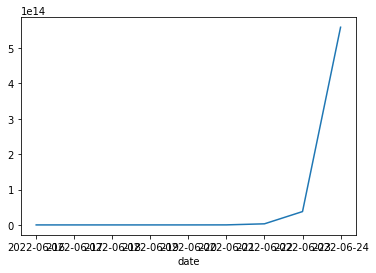

In [132]:
rc.groupby("date").agg({"profit_margin":"prod"}).profit_margin.cumprod().plot()

In [39]:
pd.set_option("display.max_rows",500)

In [134]:
rc.groupby("date").agg({"profit_margin":"prod"}).describe(percentiles=[i/10 for i in range(1,10)])

,profit_margin
count,9.000000
mean,67.544355
std,68.059580
min,12.113243
10%,14.274120
20%,19.162484
30%,24.881050
40%,30.834042
50%,37.727189
60%,44.562417


In [35]:
dtf = rc.groupby("date").agg({"profit_margin":"prod"})

In [46]:
rc.groupby("date").count().time.describe()

count    111.000000
mean     286.135135
std       84.503629
min      102.000000
25%      232.500000
50%      272.000000
75%      323.000000
max      545.000000
Name: time, dtype: float64

In [53]:
dtf.iloc[:90].cumprod()

,profit_margin
date,
2022-06-16,1.153249
2022-06-17,1.446578
2022-06-18,1.933595
2022-06-19,3.047081
2022-06-20,3.866001
2022-06-21,4.558421
2022-06-22,5.795318
2022-06-23,7.137676
2022-06-24,8.116137


In [52]:
50*450

22500

In [170]:
rc["week"] = rc.time.dt.weekofyear

/tmp/ipykernel_289911/1803472142.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  rc["week"] = rc.time.dt.weekofyear
/tmp/ipykernel_289911/1803472142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rc["week"] = rc.time.dt.weekofyear


In [171]:
rc

,status,time,price,type,take_profit,stop_loss,take_profit_ratio,stop_loss_ratio,result,date,binary_res,profit_margin,week
1,Closed,2022-06-16 08:41:00,22066.6,long,22196.845184,22108.994193,1.007493,0.999547,loss,2022-06-16,0,0.999397,24
3,Closed,2022-06-16 08:43:00,22102.6,short,22048.351096,22101.425446,1.004024,0.999219,loss,2022-06-16,0,0.999069,24
5,Closed,2022-06-16 08:46:00,22033.7,long,22138.262210,22061.258565,1.006622,0.999643,loss,2022-06-16,0,0.999493,24
7,Closed,2022-06-16 08:48:00,21967.4,long,22104.825972,22030.298155,1.006429,0.999664,loss,2022-06-16,0,0.999514,24
9,Closed,2022-06-16 08:50:00,21935.8,long,22057.567765,21979.877101,1.006702,0.999634,loss,2022-06-16,0,0.999484,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53099,Closed,2022-09-14 08:01:00,20350.0,long,20448.722368,20354.247406,1.008696,0.999415,loss,2022-09-14,0,0.999265,37
53101,Closed,2022-09-14 08:03:00,20373.1,short,20313.017492,20370.283459,1.004713,0.999088,loss,2022-09-14,0,0.998938,37
53103,Closed,2022-09-14 08:07:00,20348.3,long,20445.266433,20354.404616,1.008376,0.999450,loss,2022-09-14,0,0.999300,37
53105,Closed,2022-09-14 08:16:00,20336.2,long,20440.883154,20342.898583,1.009011,0.999381,loss,2022-09-14,0,0.999231,37


In [172]:
rc.groupby("week").agg({"profit_margin":"prod"})

,profit_margin
week,
24,2.982680
25,2.825546
26,1.842664
27,1.539185
28,1.792410
29,2.662918
30,1.732575
31,1.396443
32,1.684379


In [78]:
rc["profit"] = rc.profit_margin.cumprod()

/tmp/ipykernel_4564/105194822.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rc["profit"] = rc.profit_margin.cumprod()


<AxesSubplot:>

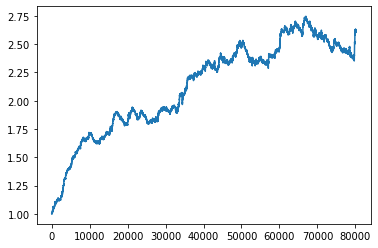

In [79]:
rc.profit.plot()

In [34]:
o1.shape
ohlc = o1[:4,:,:]
vol = o1[-1:,:,:]
ohlc = (ohlc-ohlc_mean)/ohlc_std
vol = (vol-vol_mean)/vol_std
on1 = np.concatenate((ohlc,vol),axis=0).reshape((1,*o1.shape))

In [37]:
torch.Tensor(on1).shape

torch.Size([1, 5, 32, 32])

In [43]:
dg =output.tolist()[0]

In [46]:
aa = dg[0]<dg[2]

In [47]:
aa

True